# This repository contains tools for single cell simulations in barrel cortex.

## Setup
 1. download and install Anaconda 2.7 https://www.continuum.io/Downloads
 2. install neuron such that you can import it as python module. Version 7.4 has been tested, newer versions are likely to work. Detailed installation instructions can be found at http://www.davison.webfactional.com/notes/installation-neuron-python/. If you use Ubuntu and you have trouble compling neuron, it has been reported that installing the following packages solves the problem: `sudo apt-get install bison flex g++ libxt-dev xorg-dev python-dev libncurses5-dev`
 3. Add the neuron folder to your PATH environment variable, such that you can run `nrnivmodl` anywhere
 3. install the following dependencies:
    - sumatra, *used for parameterfiles*: `pip install sumatra`
    - pandas 0.19.2, *data analysis library*: `conda install pandas==0.19.2`
    - dask 0.14.2, *dynamic task scheduling and "big data" extension of pandas*: `conda install dask==0.14.2`
    - distributed 1.15.2 *allows non-bloccking computations and brings dask to a cluster*: `conda install distributed=1.15.2`
    - seaborn: *statistical data visualization*: `conda install seaborn`
    - fasterners: *robust file based locking*: `pip install fasteners`
    - jinja2: *html template engine, required for embedded animations*: `pip install jinja2`
 4. clone or pull this repository: `git clone https://github.com/abast/in_silico_framework.git`. 
 5. add your in_silico_framework folder to the PYTHONPATH variable
 6. unzip the following folder: in_silico_framework/getting_started/barrel_cortex.zip such that the following file exists: `in_silico_framework/getting_started/barrel_cortex/nrCells.csv`
 6. Open the file model_data_base/simrun2/seed_manager and adjust the variable `path`. This will specify the location where used seeds are saved. Any location where you have write access is suitable.
 7. run the test suite: `python run_tests.py`. 
 
 Due to the statistical nature of the model, some tests might fail from time to time. These tests have the word _statistical_ in their description. If such a test fails, run the testsuite again. If that test fails again, there most likely is an issue. Tests, that do not have a _statistical_ flag in their description may never fail.

## Packages in this repository you will most likely directly interact with
**singlecell_input_mapper**: Module for generating anatomical models, i.e. determining number and location of synapses and number and location of presynaptic cells

**single_cell_parser**: High level interface to the NEURON simulator providing methods to perform single cell simulations with synaptic input. The anatomical constraints of the synaptic input are provided by the single_cell_input_mapper module.

**simrun2**: High level interface to the single_cell_parser module providing methods for common simulation tasks. It also provides methods for building reduced models mimicing the full compartmental model.

**model_data_base**: Flexible database whose API mimics a python dictionary. It provides efficient and scalable methods to store and access simulation results at a terrabyte scale. It also generates metadata, indicating when the data was put in the database and the exact version of the in_silico_framework that was used at this timepoint. Simulation results from the single_cell_parser module can be imported and converted to a high performance binary format. Afterwards the data is accessible using the pandas data analysis library and dask. 

**single_cell_analyzer**: Library for analysis of single_cell_parser results. Use this module, if you specifically want to analyze a single simulation run. If you want to analyze the results of many simulation trails, the recomended way is to import the simulation results in a model_data_base and use pandas and dask for the analysis afterwards.

## Other packages

**mechanisms**: NEURON mechanisms (Ion channels, synapses, ...) used by the neuron simulator. If you run `import mechanisms`, these mechanisms are beeing compiled. Make sure, that you have the nrnivmodl executable in your path, otherwise this will not work

**test_simrun2, test_model_data_base, ...**: tests for the respective modules. To run the testsuite, use `python run_tests.py`

## How should I interact with these packages?

The recommended way is to use the `Interface` module which glues together all these packages mentioned above to one *Application*: It provides the API necessary to perform simulation tasks and provides additional methods that improve interactivity.

In [78]:
import sys
sys.path.append('/nas1/Data_arco/project_src/in_silico_framework/')

In [79]:
import Interface as I

Now, you can access the relevant packages, functions and classes directly:

In [3]:
I.scp # single_cell_parser package
I.sca # single_cell_analyzer package
I.ModelDataBase # main class of model_data_base
I.map_singlecell_inputs # compute anatomical model for a given cell morphology in barrel cortex 
I.simrun_run_new_simulations # default function for running single cell simulations with well constrained synaptic input
I.mdb_init_simrun_general.init # default method to initialize a model data base with existing simulation results
I.mdb_init_simrun_general.optimize # converts the data to speed optimized compressed binary format
I.synapse_activation_binning_dask # parallelized binning of synapse activation data
I.rm_get_kernel # create reduced lda model from simulation data

I.silence_stdout # context manager and decorator to silence functions
I.cache # decorator to cache functions

I.cluster() # get distributed.Client() object for parallel execution

I.np # numpy
I.pd # pandas
I.dask # dask
I.distributed # distributed
I.sns # seaborn
# ...

<module 'seaborn' from '/nas1/Data_arco/prgr/Anaconda/lib/python2.7/site-packages/seaborn/__init__.pyc'>

Use autocompletion of IPython to find the other modules. To view the documentation, use a questionamrk, e.g.

In [4]:
I.mdb_init_simrun_general.init?

# Quickstart: How to run a simulation?

To run single cell simulations, we first need a hoc morphology file of that cell. Additionally, we need to know, how to distribute ion channels on that morphology, such that the cell has the desired biophysical properties. 

In the getting started subfolder of this repository, there is such a hoc-morphology and the corresponding parameter file. 
    - anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc
    - biophysical_constraints/86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param
    
**Let's have a closer look at the parameters.**
    

In [3]:
from getting_started import getting_started_dir # path to getting started folder
cell_param = I.os.path.join(getting_started_dir, \
                            'biophysical_constraints', \
                            '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')
cell_param = I.scp.build_parameters(cell_param) # this is the main method to load in parameterfiles

`cell_param` is a nested dictionary. The biophysical parameters are described in the *neuron* key. Here, we specify ion channel conductances for all structures of the cell:

In [4]:
cell_param.neuron.keys()

['Myelin', 'Soma', 'AIS', 'filename', 'Dendrite', 'ApicalDendrite']

The key *filename* points to the hoc morphology file. The others define ion channel conductances for the respective part of the cell. Let's figure out, what channels can be found in the basal dendrite:

In [5]:
cell_param.neuron.Dendrite

{'mechanisms': {'global': {},
  'range': {'Ih': {'gIhbar': 0.0002, 'spatial': 'uniform'},
   'pas': {'e': -90.0, 'g': 6.31e-05, 'spatial': 'uniform'}}},
 'properties': {'Ra': 100.0, 'cm': 2.0}}

Here you see that we only have the passive conductance and If channels, both uniformly distributed along the dendrite. There are much more channels in the apical dendrite. A comprehensive description of the other parts of the cell parameter file can be found here: #todo

## **Now, we can do some current injection experiments to analyze the biophysical properties of the model.** 

In [6]:
# set up cell. This creates a lot of (interesting) diagnostic output. Remove the context manager to see it
with I.silence_stdout:
    cell = I.scp.create_cell(cell_param.neuron)

Let's figure out some general properties of the cell

In [7]:
print 'total length = {:.0f} micron'.format(sum([sec.L for sec in cell.sections]))
print 'total dendritic length = {:.0f} micron'.format(sum([sec.L for sec in cell.sections \
                                                           if sec.label in ['Soma', 'Dendrite', 'ApicalDendrite']]))
print 'soma area = {:.0f} micron^2'.format(sum([sec.area for sec in cell.sections if sec.label == 'Soma']))
print 'apical dendrite area = {:.0f} micron^2'.format(sum([sec.area for sec in cell.sections \
                                                           if sec.label == 'ApicalDendrite']))

total length = 16340 micron
total dendritic length = 15290 micron
soma area = 916 micron^2
apical dendrite area = 16855 micron^2


<a id='WhyWeNeedScaling'></a>
The respective hoc morphology has a very thin apical dendrite which does not allow electric coupling between apical dendrite and soma. We figured that it is necessary to scale up the diameter of the trunc.

In [8]:
# load scaled hoc morphology
cell_param.neuron.filename = I.os.path.join(getting_started_dir, 'anatomical_constraints', \
                            '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc')
with I.silence_stdout:
    cell = I.scp.create_cell(cell_param.neuron)
print 'apical dendrite area = {:.0f} micron^2'.format(sum([sec.area for sec in cell.sections \
                                                           if sec.label == 'ApicalDendrite']))

apical dendrite area = 27212 micron^2


Now, we put a pipette at the soma of the cell and inject a short rectangular current

In [9]:
import neuron
h = neuron.h

In [10]:
iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 150 # give the cell time to reach steady state
iclamp.dur = 5 # 5ms rectangular pulse
iclamp.amp = 1.9 # 1.9 ?? todo ampere

CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.19 s


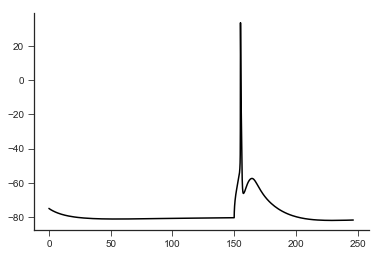

In [11]:
%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 
%matplotlib inline
I.sns.set_style('ticks')
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k')
I.sns.despine()

How does the cell respond to different amplitudes of the step current?

In [11]:
cell_param.sim.tStop = 3000
iclamp.dur = 2000
iclamp.delay = 500
simresult = {}
for amp in [0.619, 0.793, 1.507]:
    iclamp.amp = amp
    I.scp.init_neuron_run(cell_param.sim, vardt=True)
    simresult[amp] = I.np.array(cell.tVec), I.np.array(cell.soma.recVList[0])

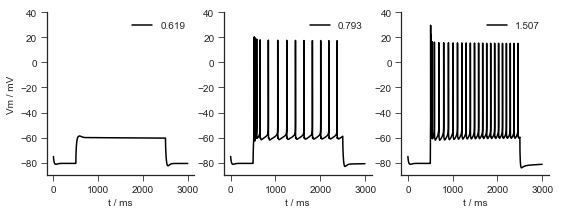

In [14]:
fig = I.plt.figure(figsize = (9,3), dpi = 200)
for lv, k in enumerate(sorted(simresult.keys())):
    ax = fig.add_subplot(1,3,lv+1)
    ax.plot(*simresult[k], label = k, c = 'k')
    ax.legend(loc = 'upper right')
    ax.set_ylim([-90, 40])
    ax.set_xlabel('t / ms')
    if lv == 0:
        ax.set_ylabel('Vm / mV')
I.sns.despine()

Now let's place a pipette on the apical trunk at a soma distance of 620 microns and inject current synchronously at this position and at the soma. For the current at the soma, we choose a rectangular pulse again. The current at the apical injection site should resemble the shape of a evoked post synaptic potential (epsp). Have a look at the folder mechanisms/synapses to see how epsp is implemented in hoc code.

In [12]:
# map between sections and somadistance
sec_dist_dict = {cell.distance_to_soma(sec, 1.0): sec for sec in cell.sections}

def get_section_at_distance(cell, dist):
    dummy = {k - dist: v for k,v in sec_dist_dict.iteritems() if k > dist}
    closest_sec = dummy[min(dummy)]
    x = (dist - cell.distance_to_soma(closest_sec, 0.0)) / closest_sec.L
    return x, closest_sec

In [13]:
cell_param.sim.tStop = 500
x, sec = get_section_at_distance(cell, 620)

iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 295 # give the cell time to reach steady state
iclamp.dur = 5 # 5ms rectangular pulse
iclamp.amp = 1.9 # 1.9 ?? todo ampere

iclamp2 = h.epsp(x, sec=sec)
iclamp2.onset = 300
iclamp2.imax = 0.5
iclamp2.tau0 = 1.0 # rise time constant
iclamp2.tau1 = 5 # decay time constant
cell.iclamp2 = iclamp2

%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 

CPU times: user 2.14 s, sys: 16 ms, total: 2.16 s
Wall time: 2.16 s


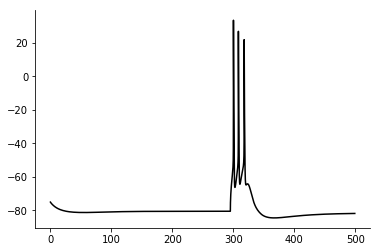

In [21]:
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k')
I.sns.despine()

So far, we have only visualized the somatic membrane potential. Now, we create a short animation, where the whole dendrite is visualized (x-axis: soma distance of dendrite segment, y-axis: Vm)

In [18]:
mdb = I.ModelDataBase('/home/abast/my_mdb/') # create a ModelDataBase to save .png-frames of the animation

see section [ModelDataBase](#ModelDataBase) for a more detailed descritpion

files are here: /home/abast/my_mdb/burst_trail_video_lnKNWe_/animation_gE2IWf/*.png



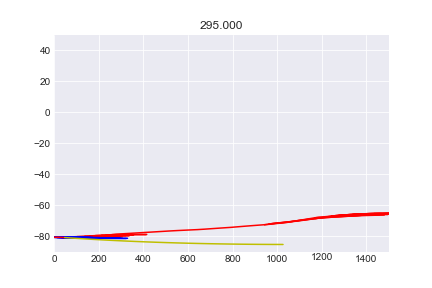
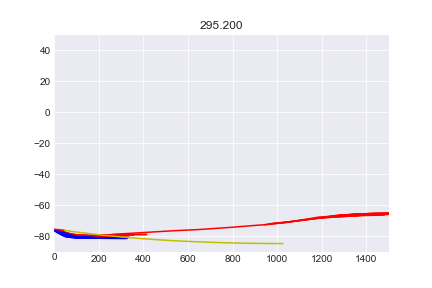
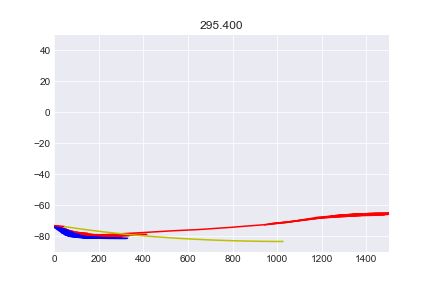
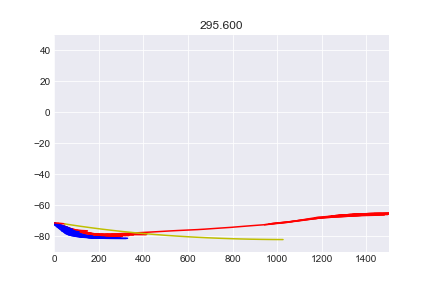
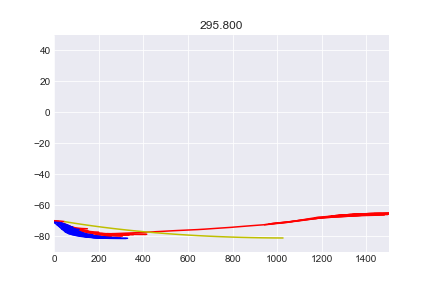
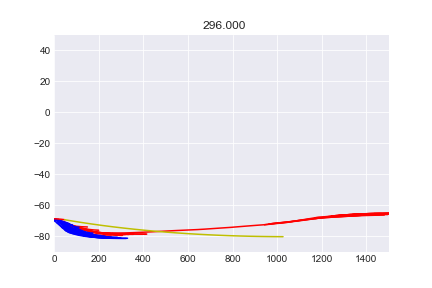
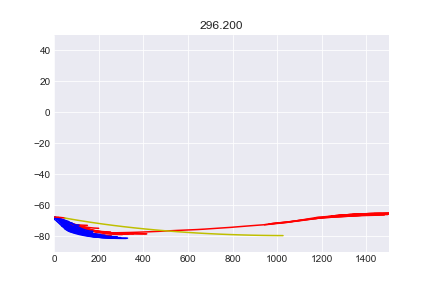
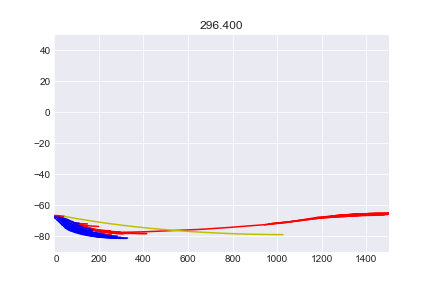
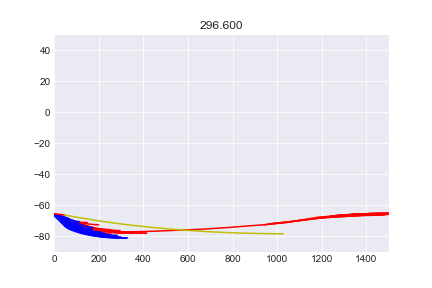
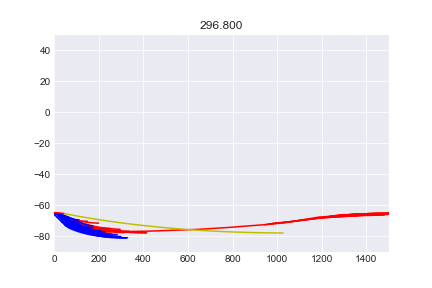
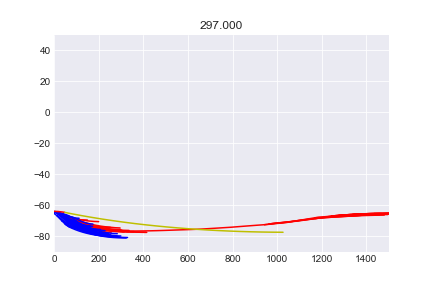
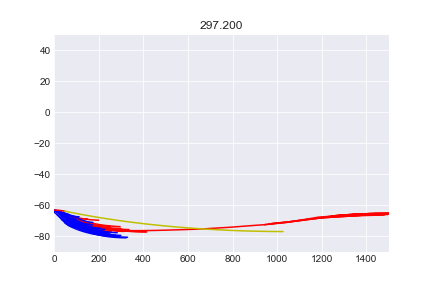
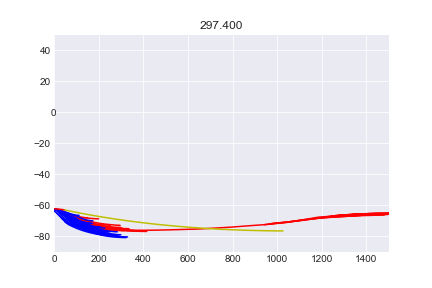
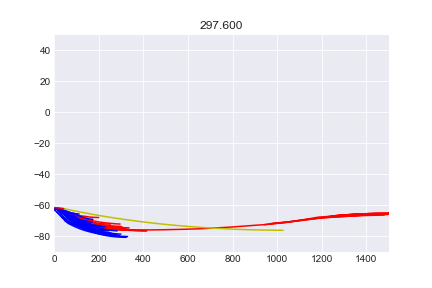
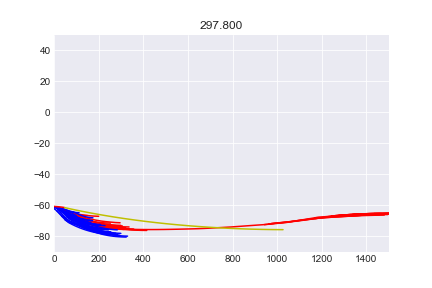
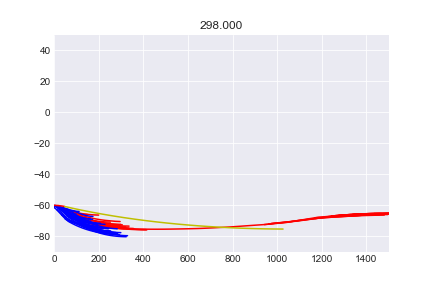
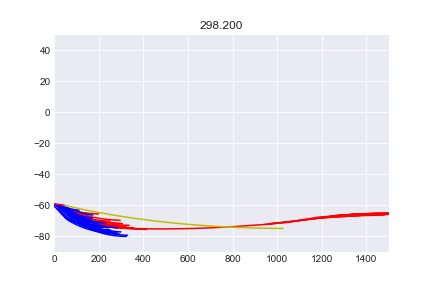
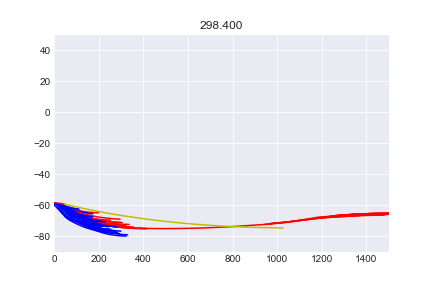
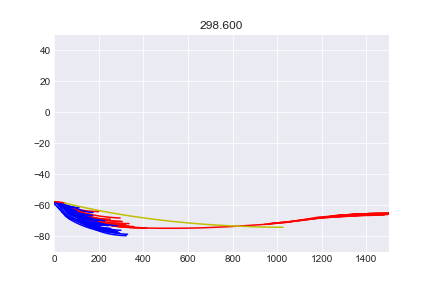
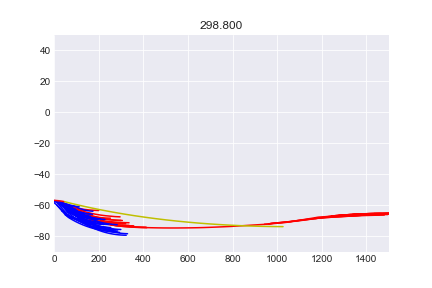
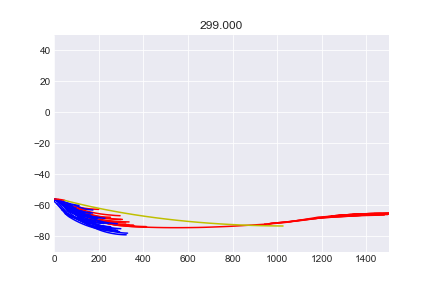
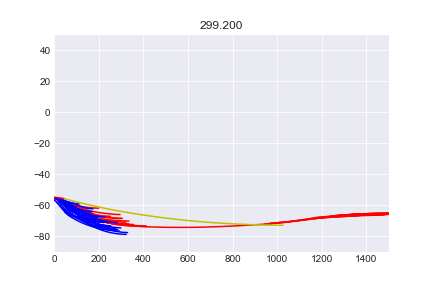
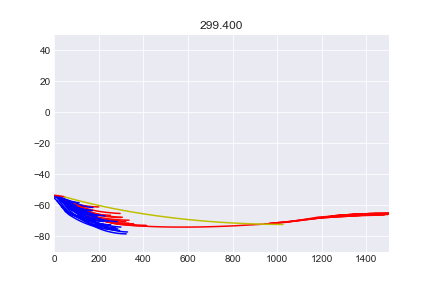
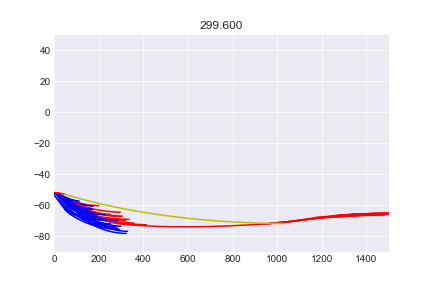
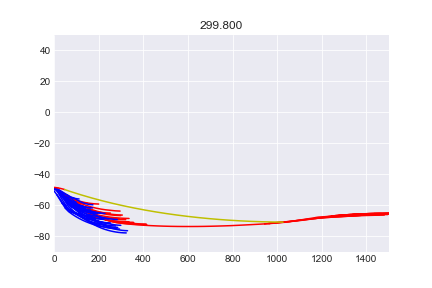
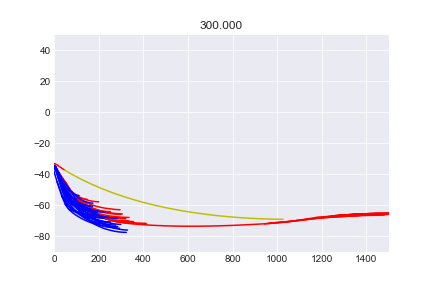
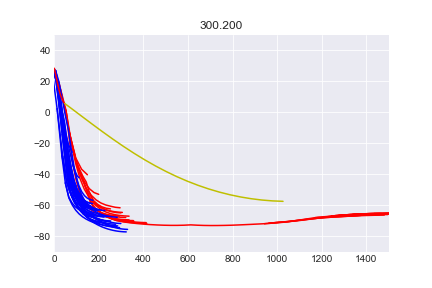
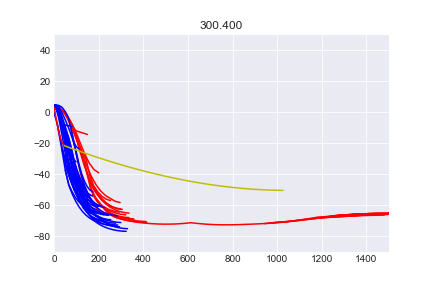
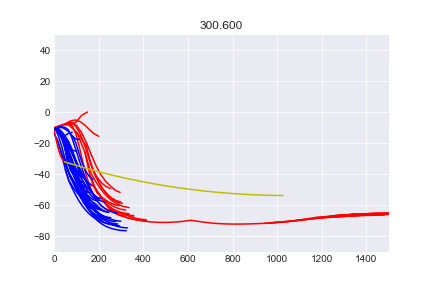
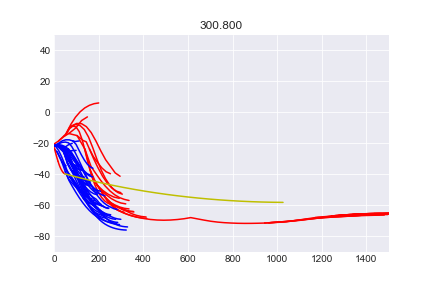
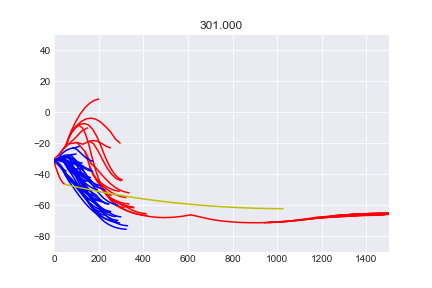
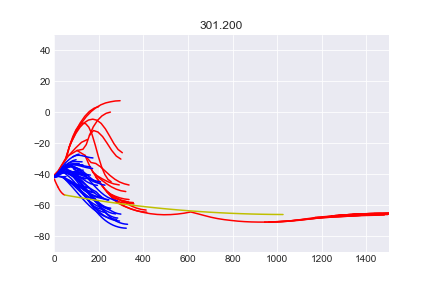
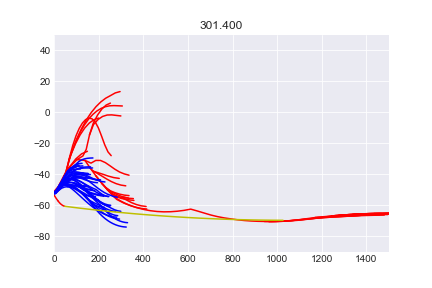
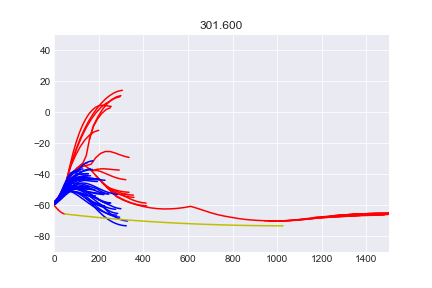
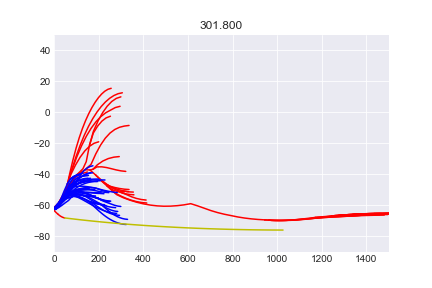
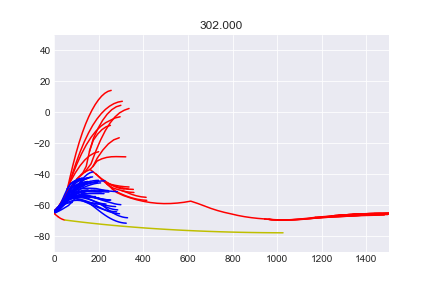
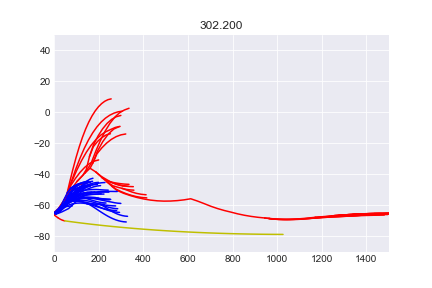
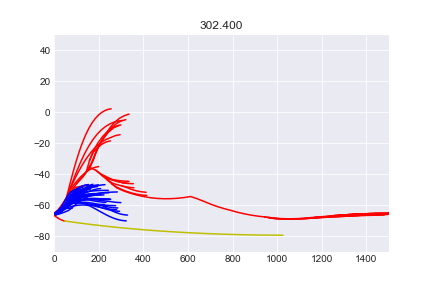
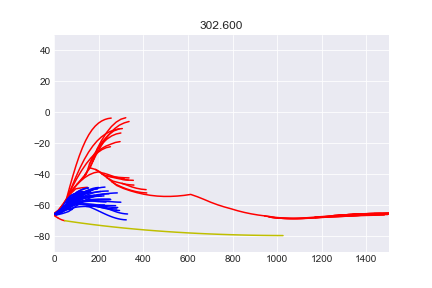
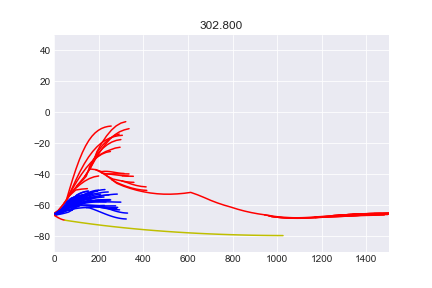
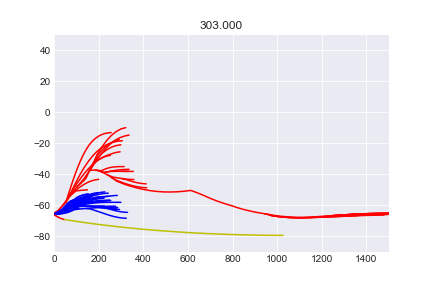
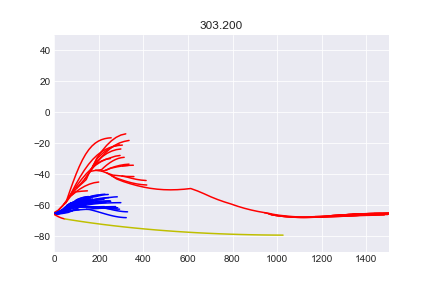
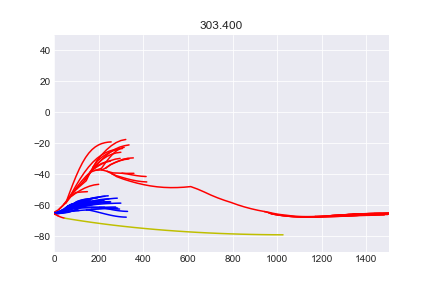
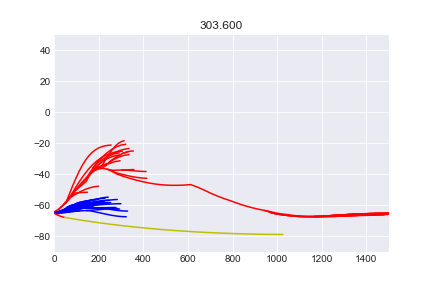
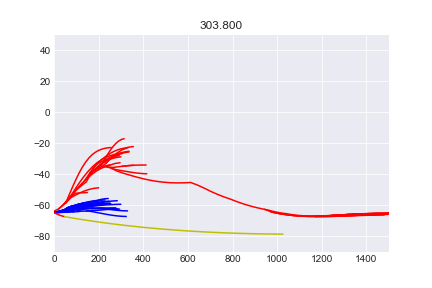
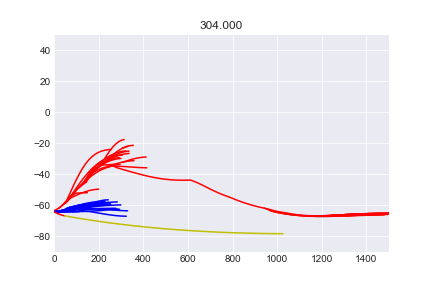
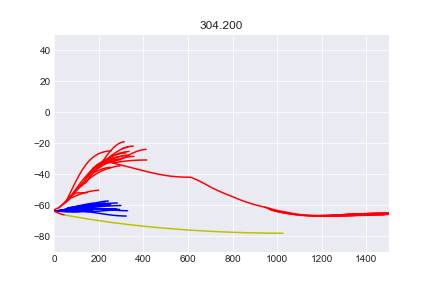
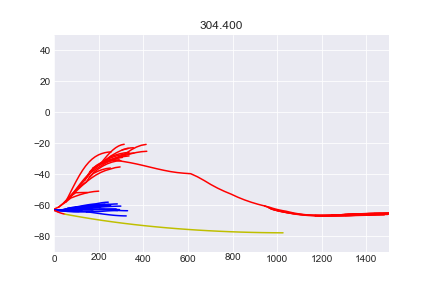
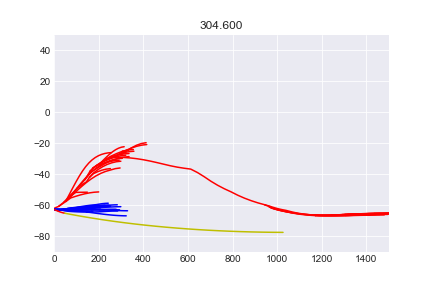
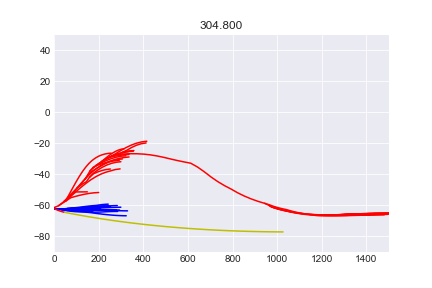
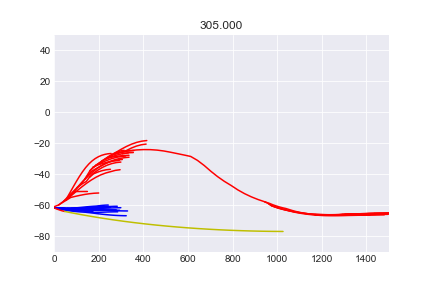
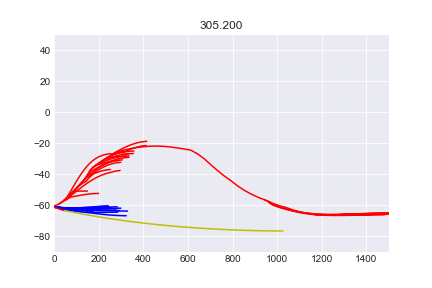
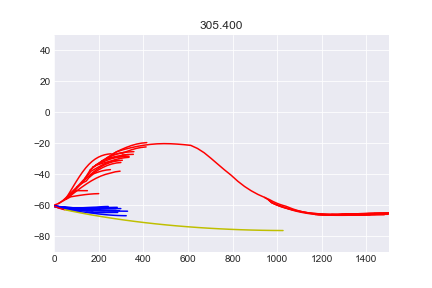
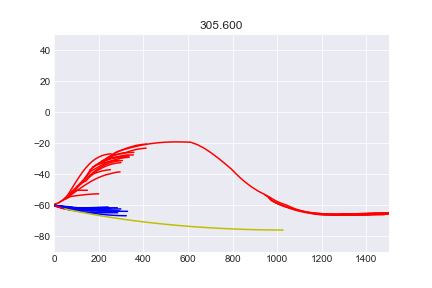
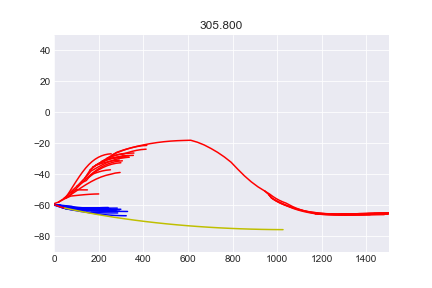
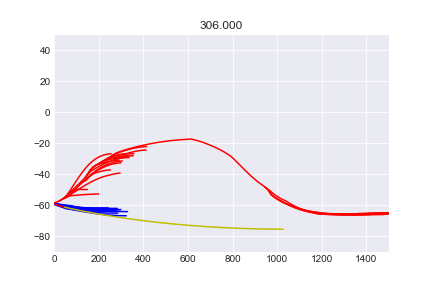
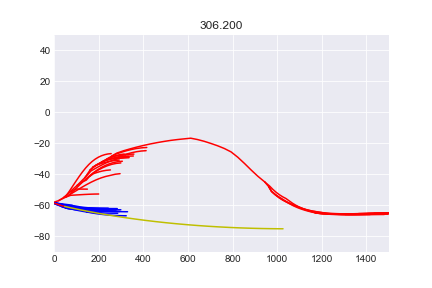
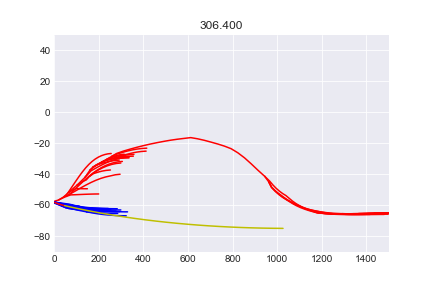
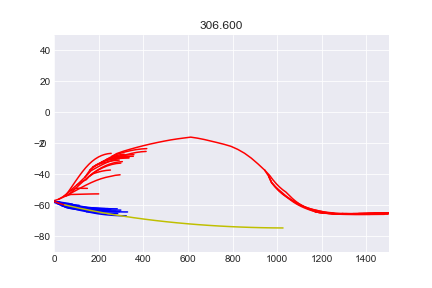
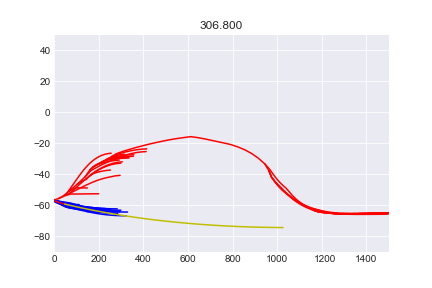
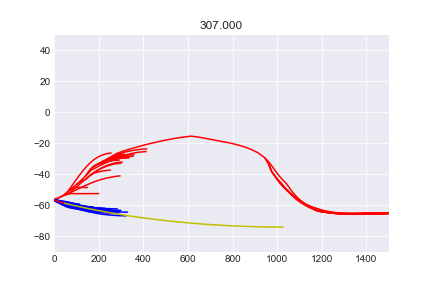
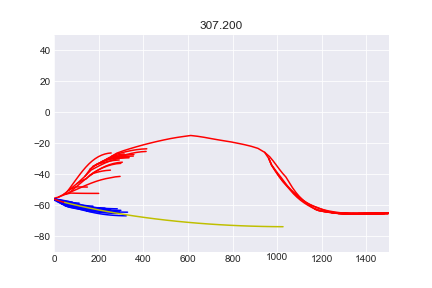
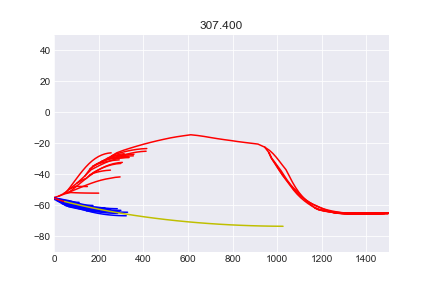
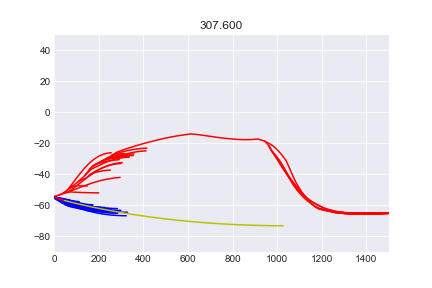
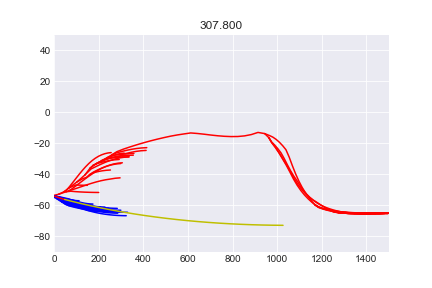
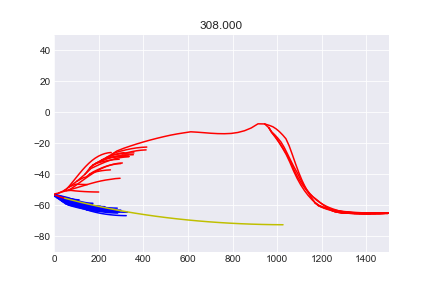
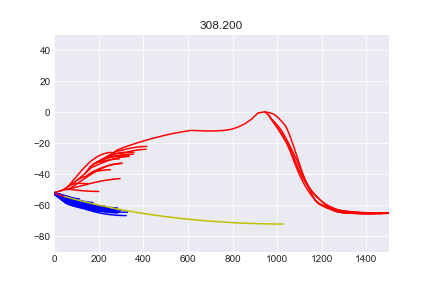
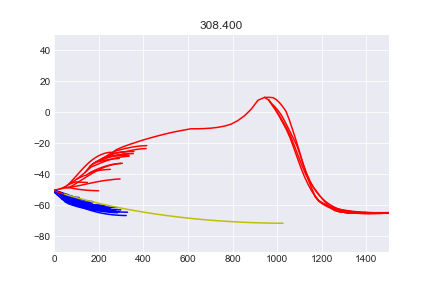
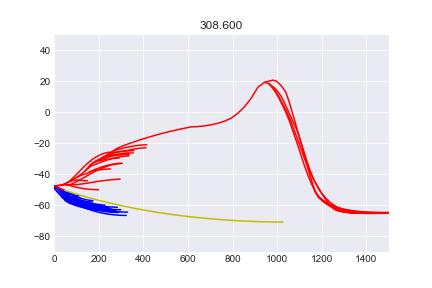
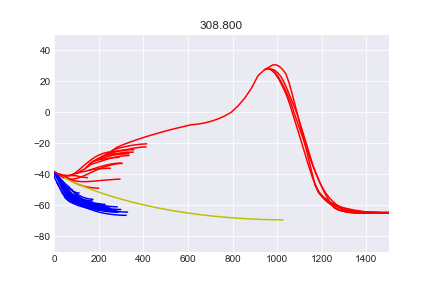
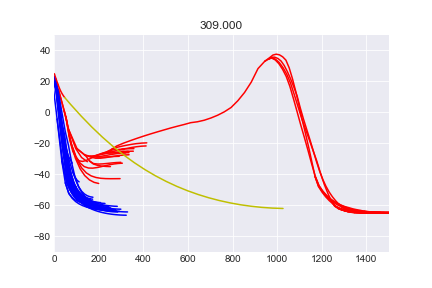
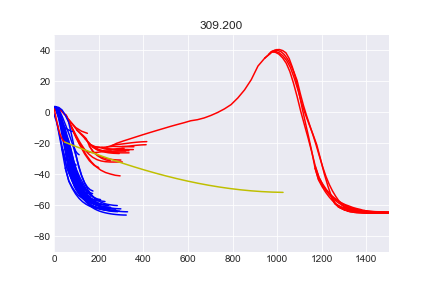
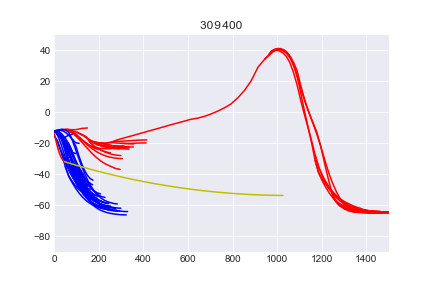
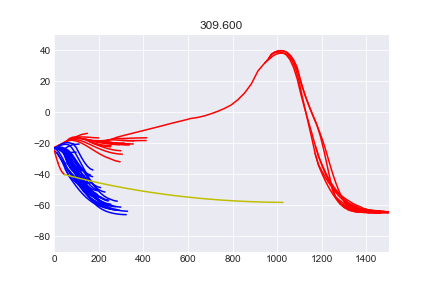
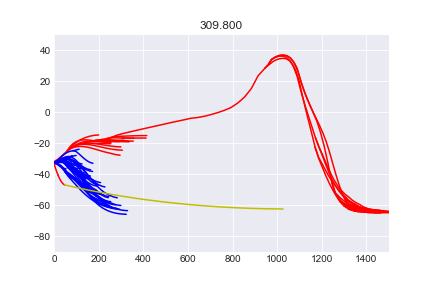
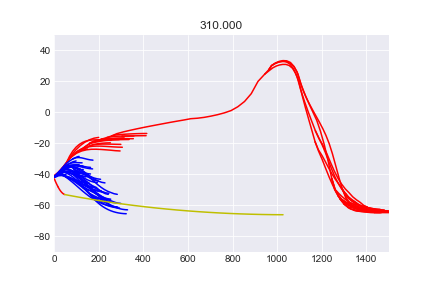
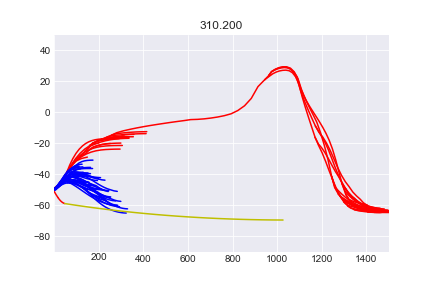
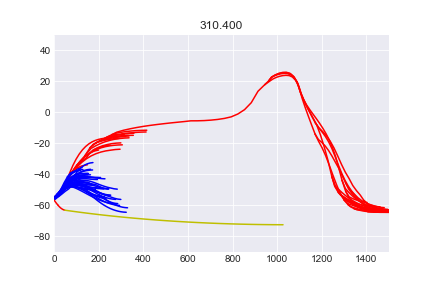
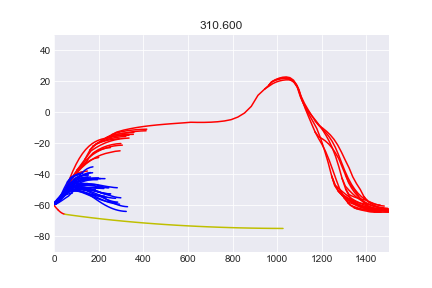
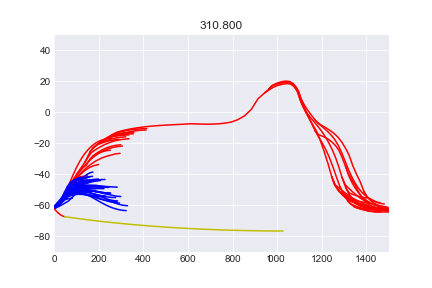
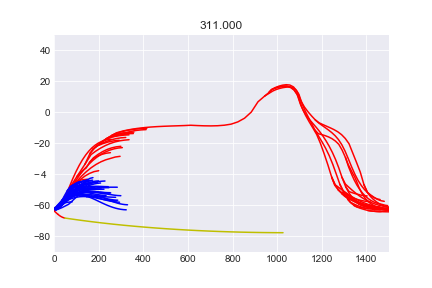
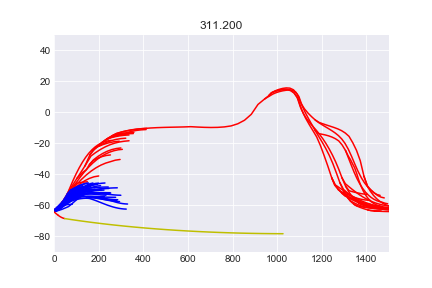
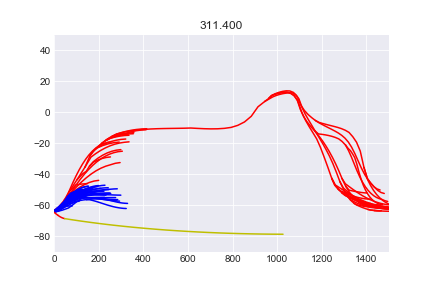
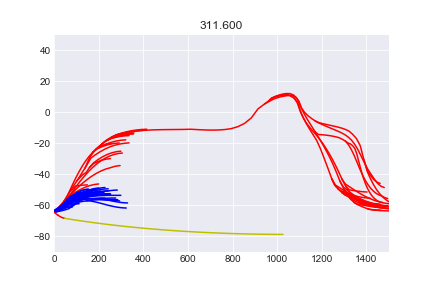
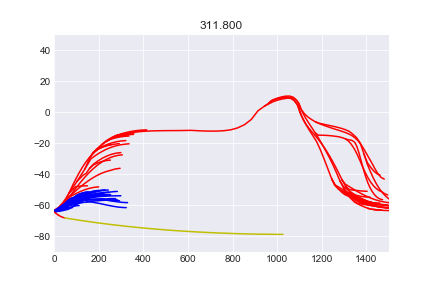
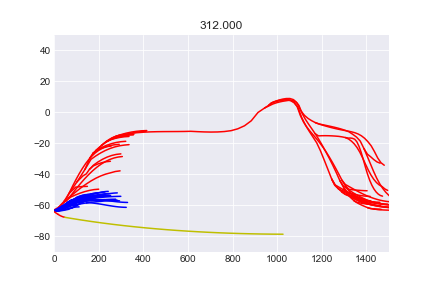
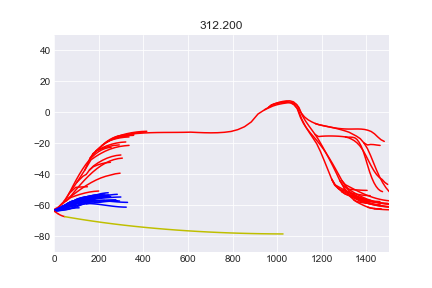
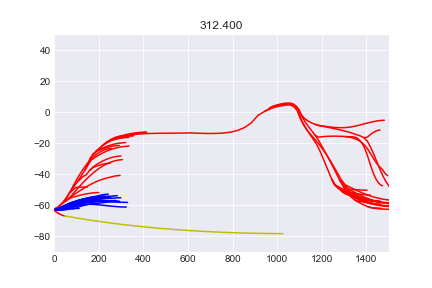
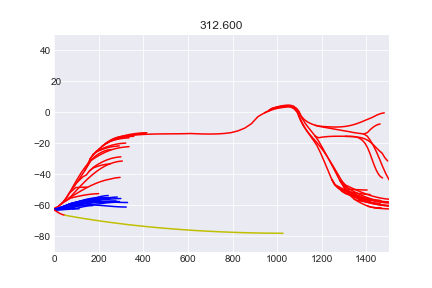
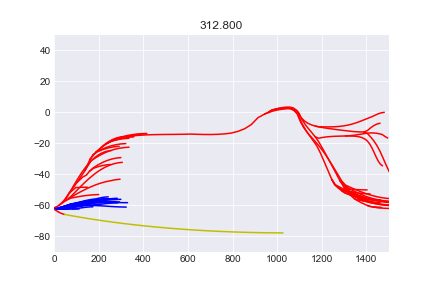
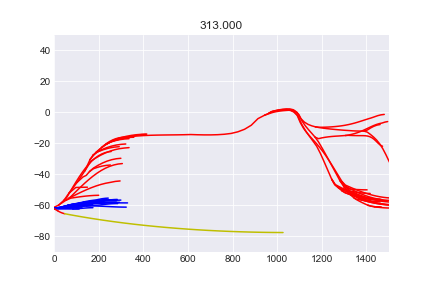
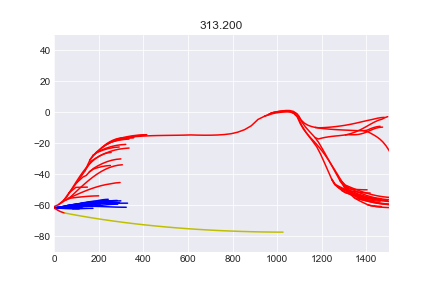
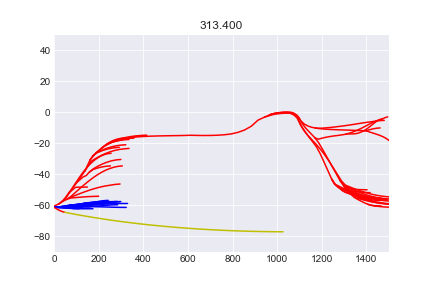
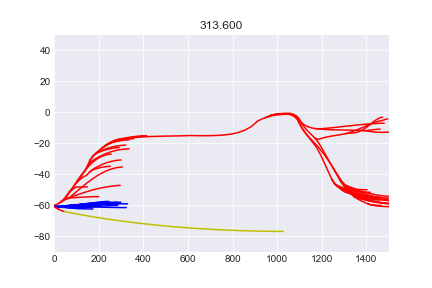
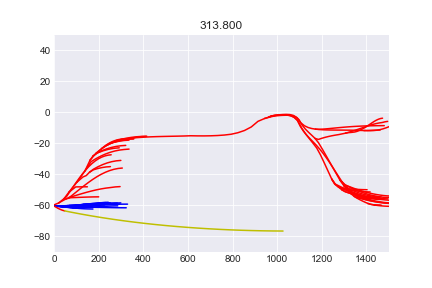
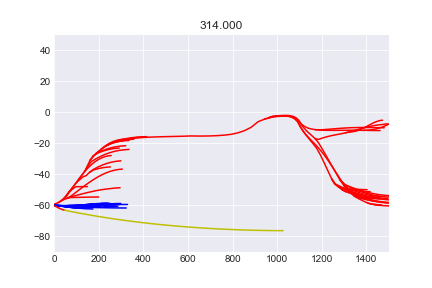
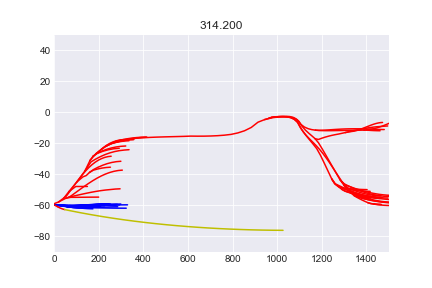
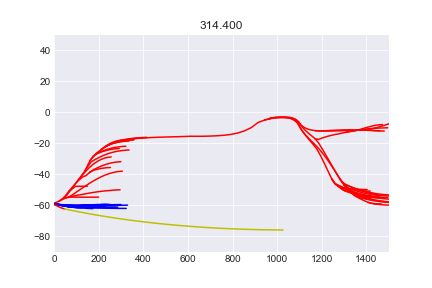
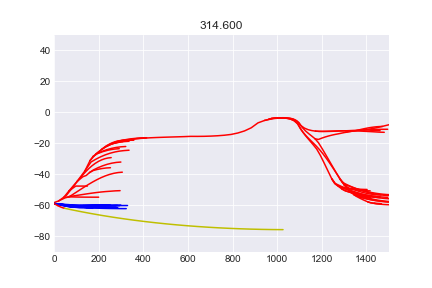
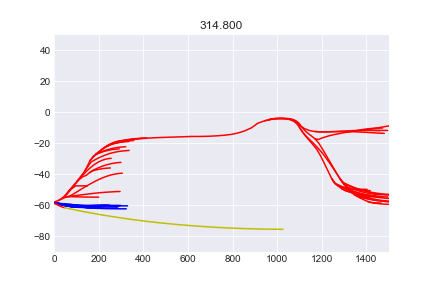
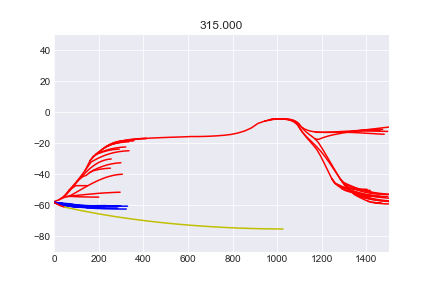
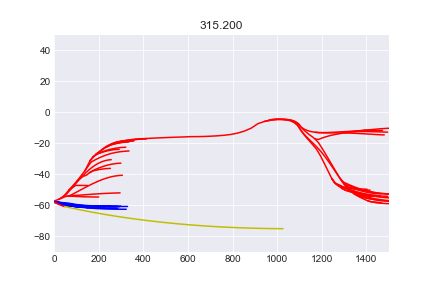
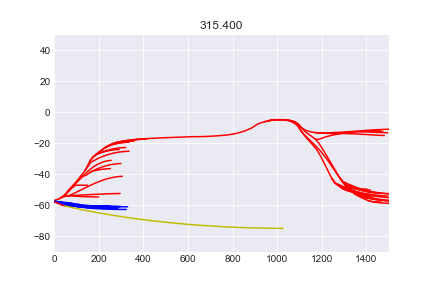
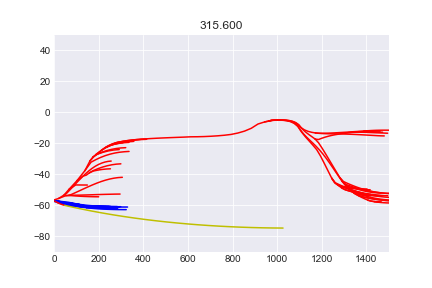
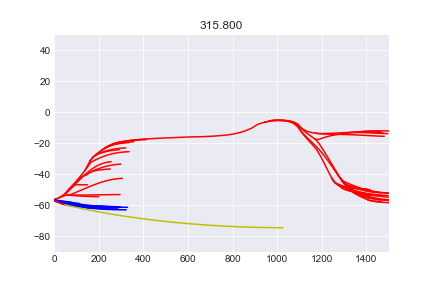
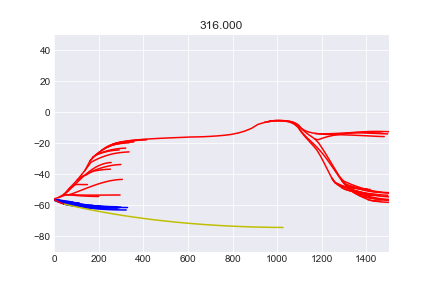
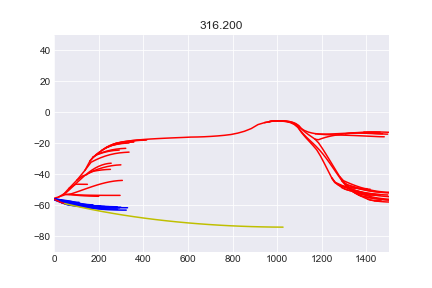
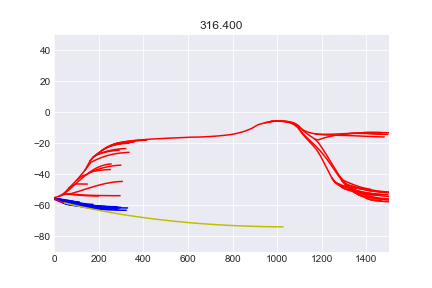
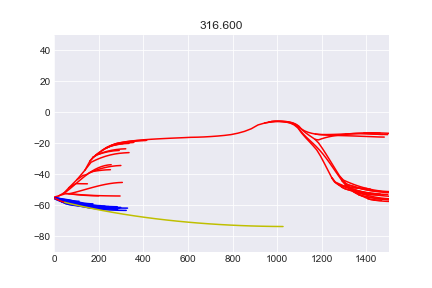
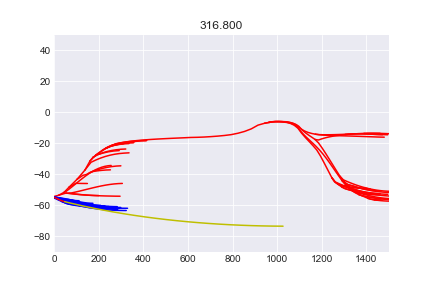
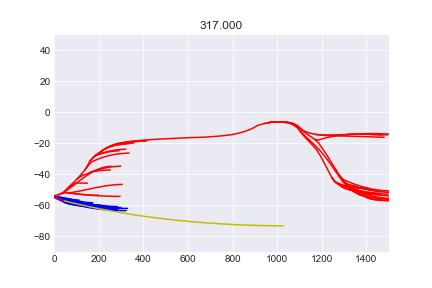
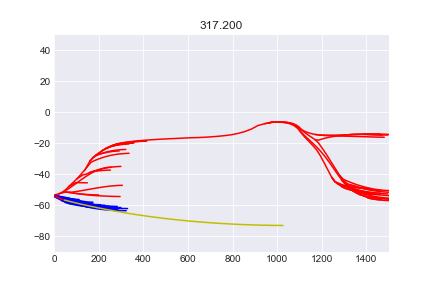
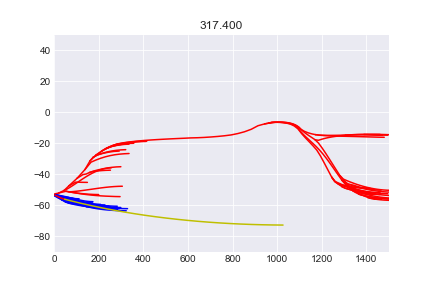
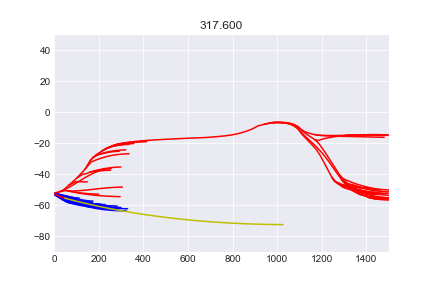
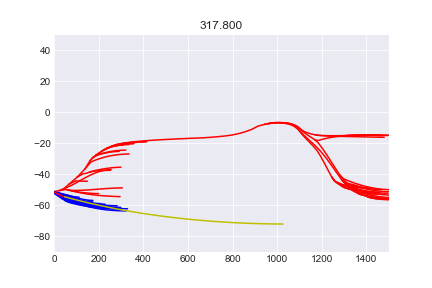
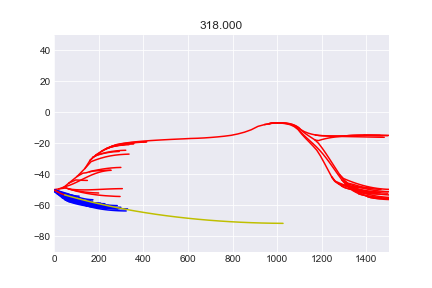
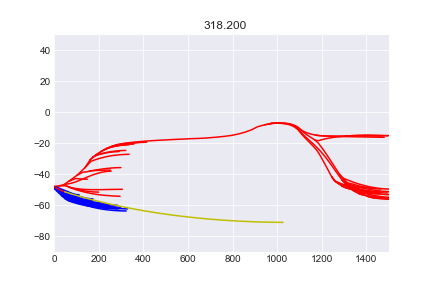
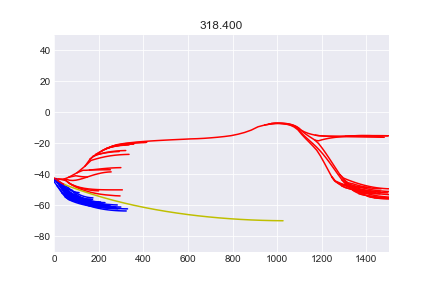
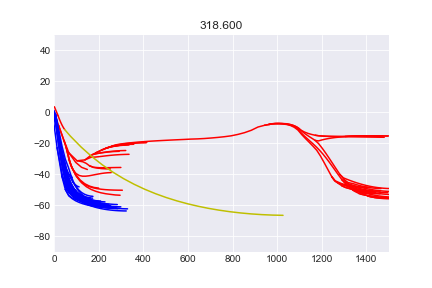
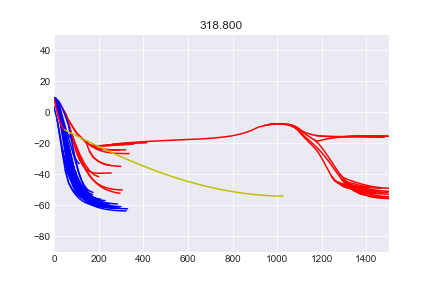
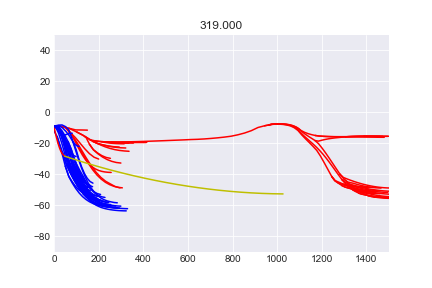
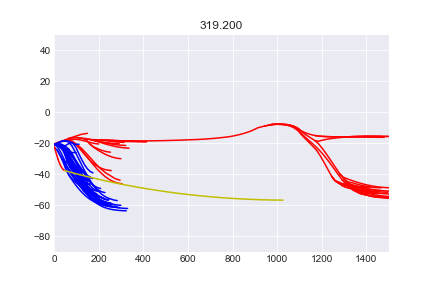
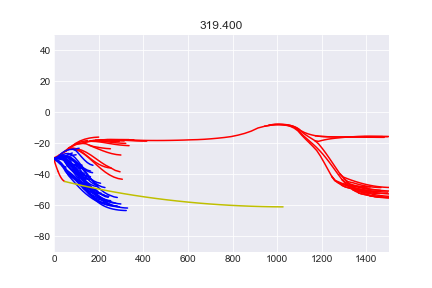
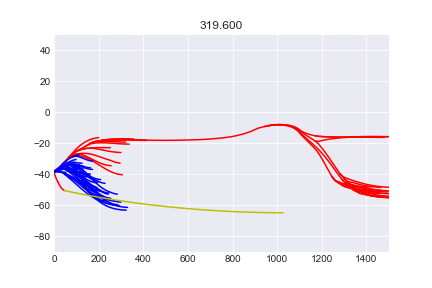
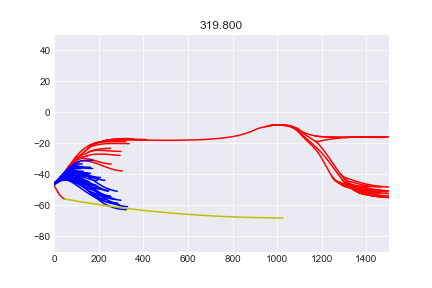
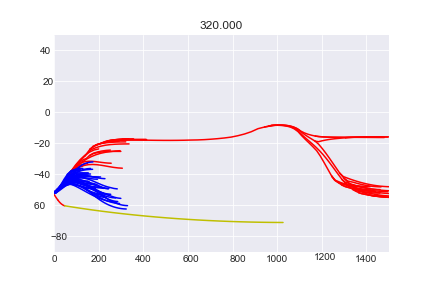
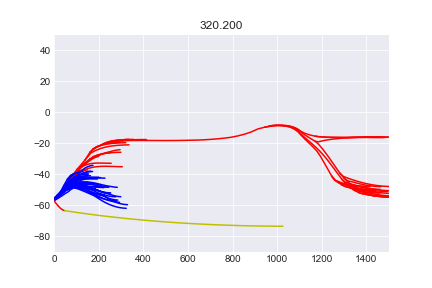
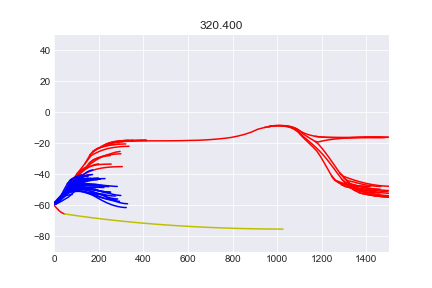
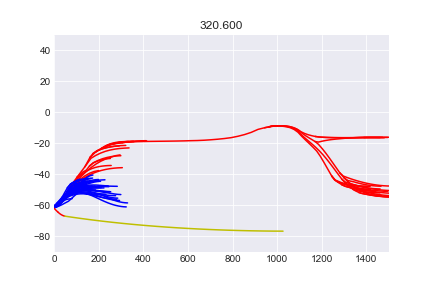
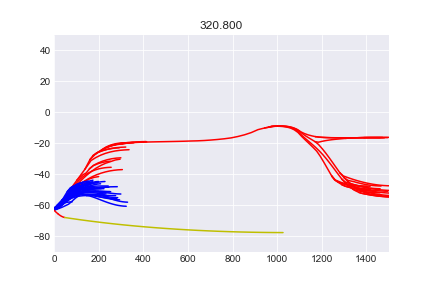
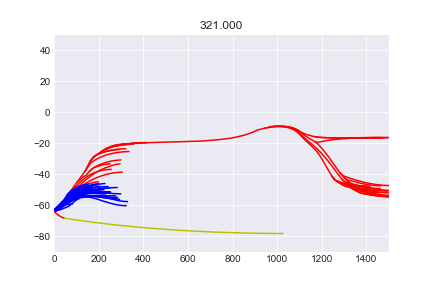
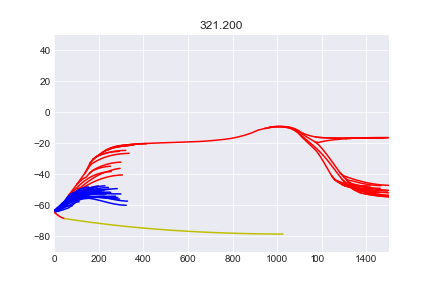
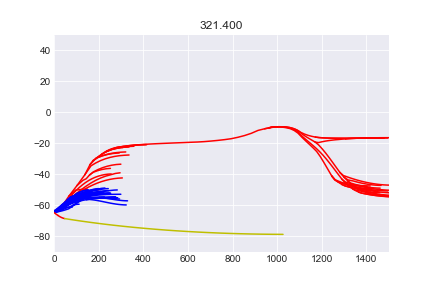
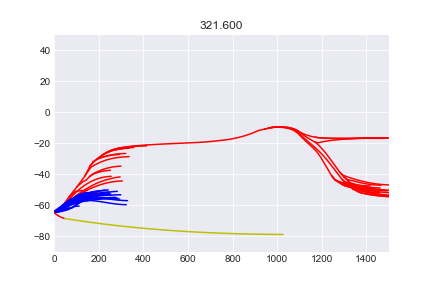
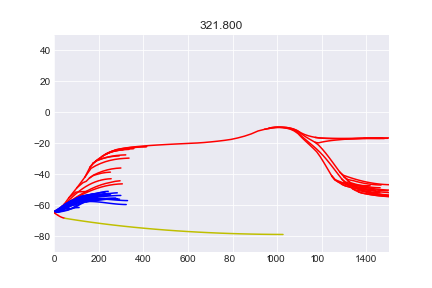
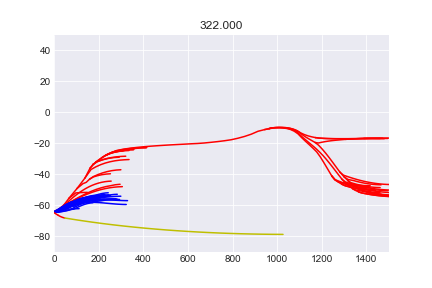
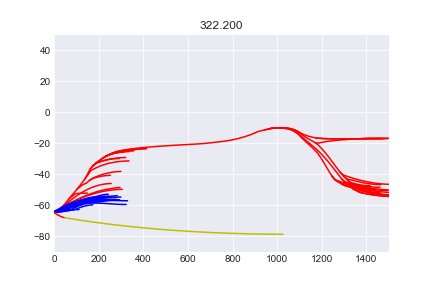
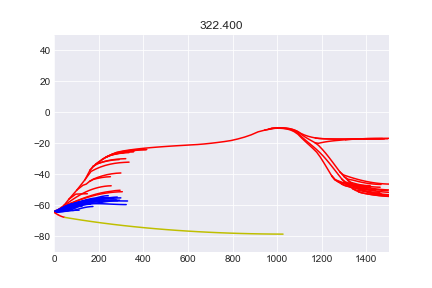
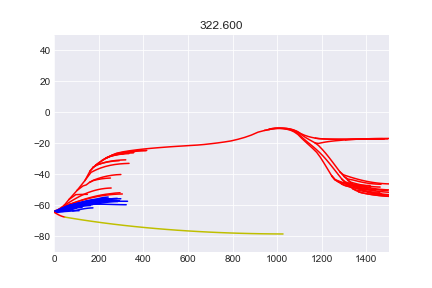
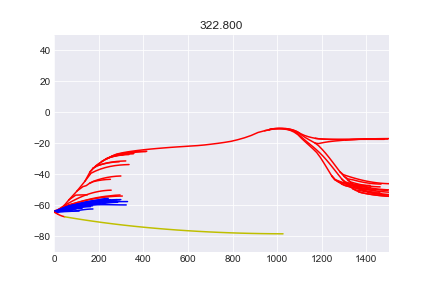
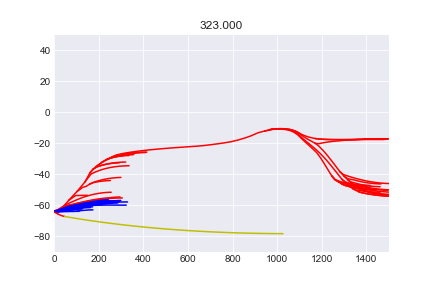
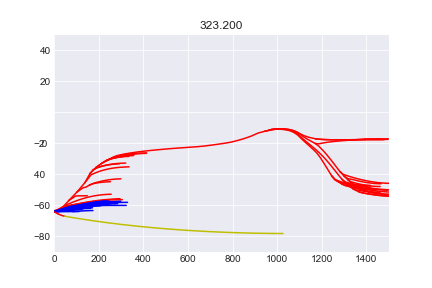
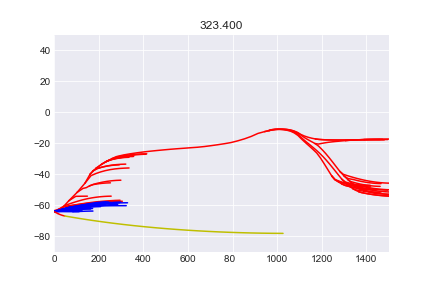
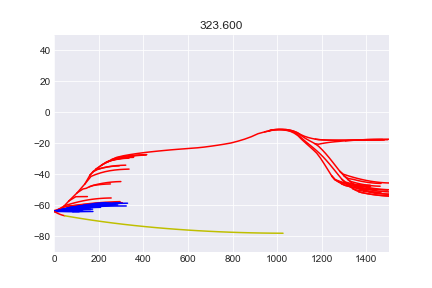
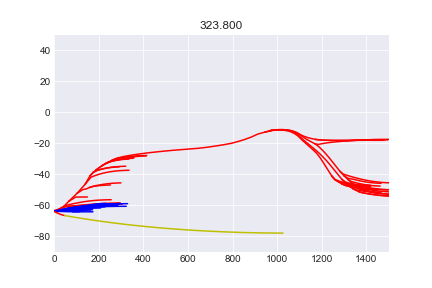
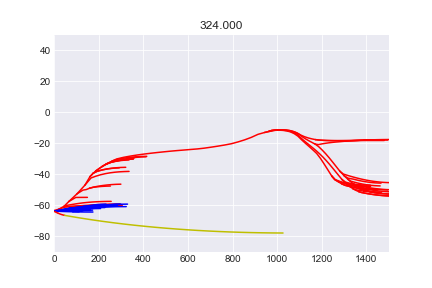
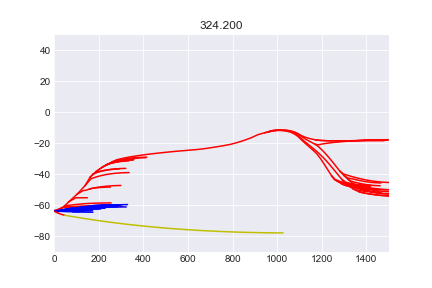
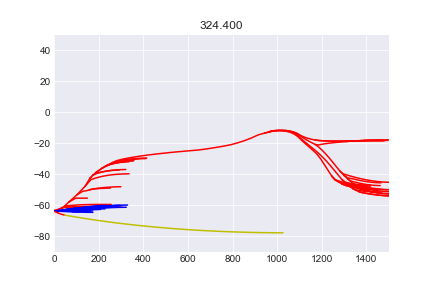
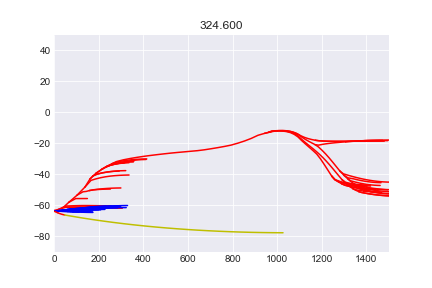
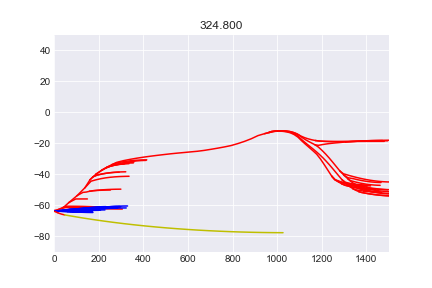
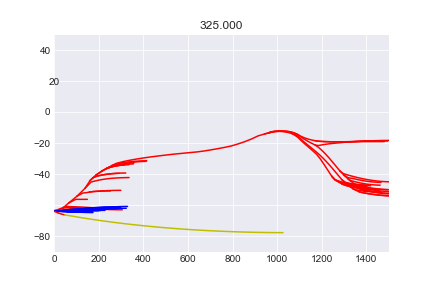
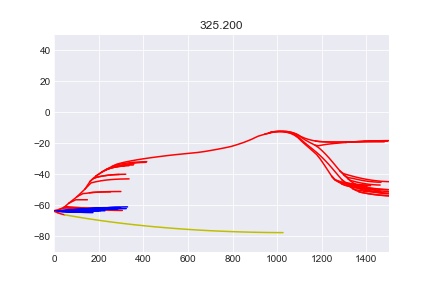
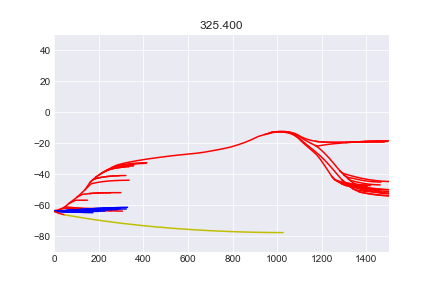
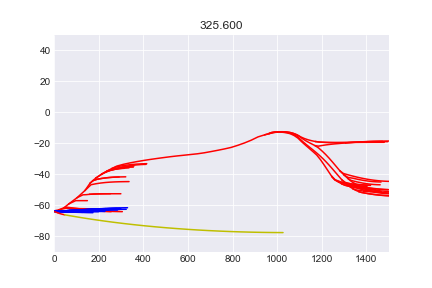
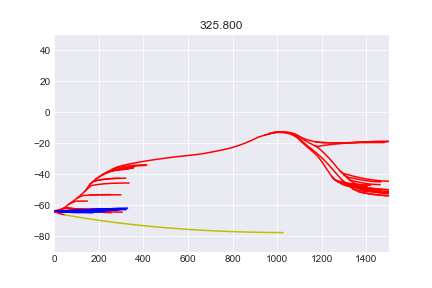
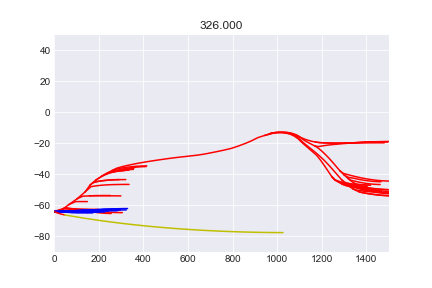
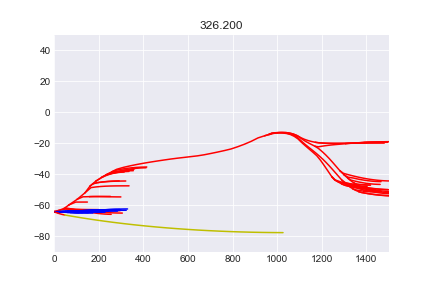
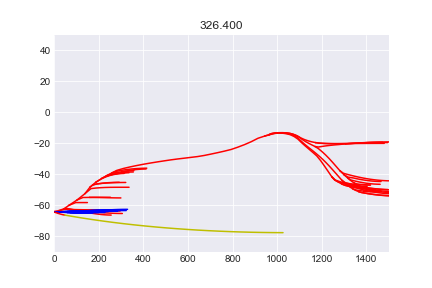
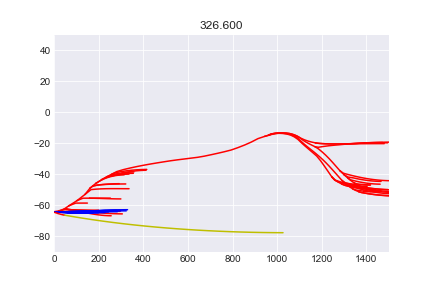
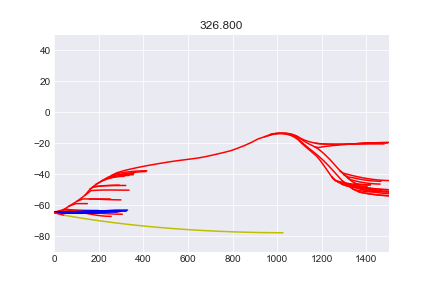
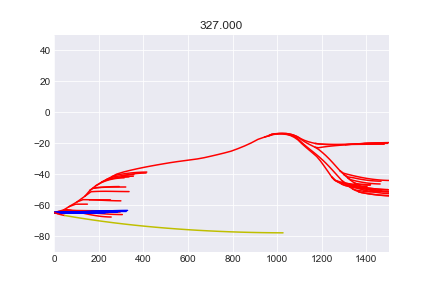
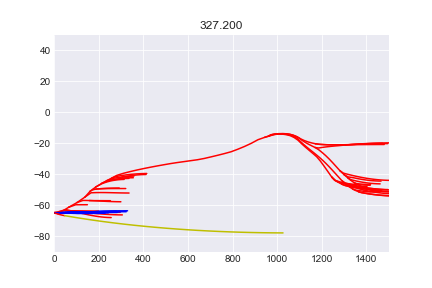
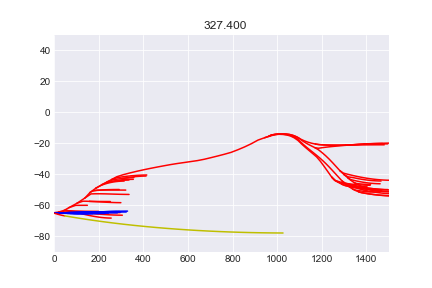
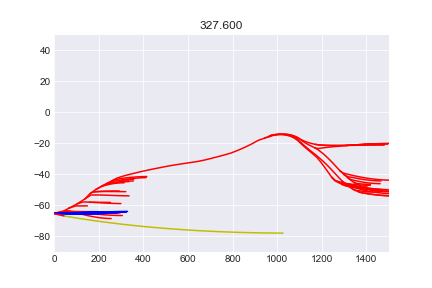
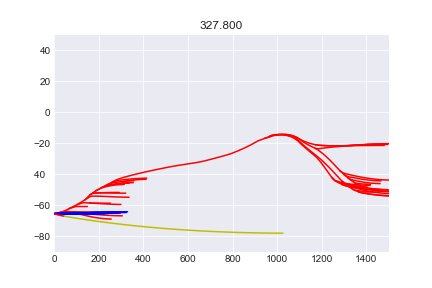
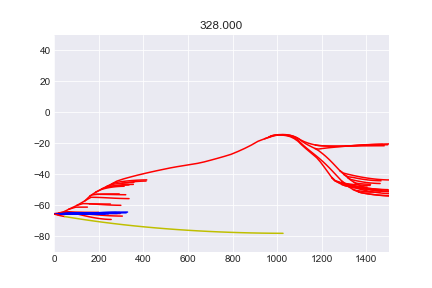
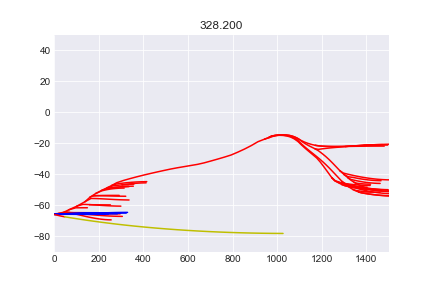
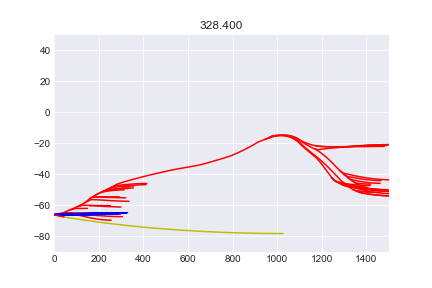
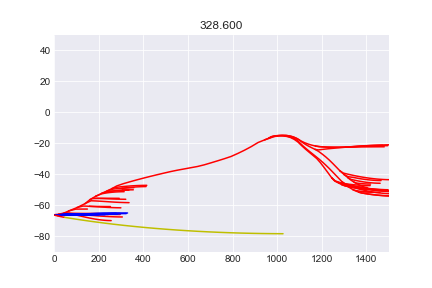
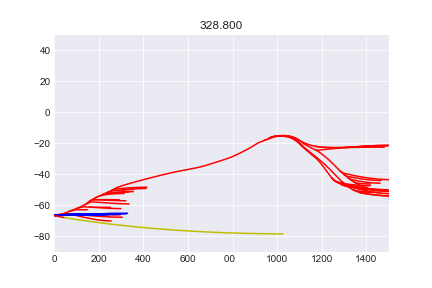
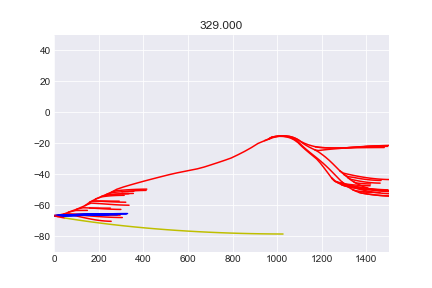
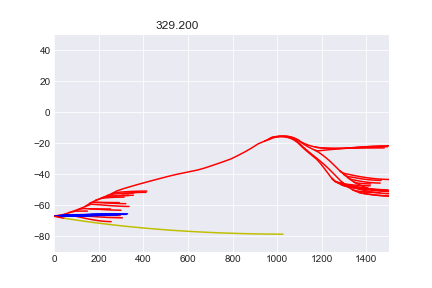
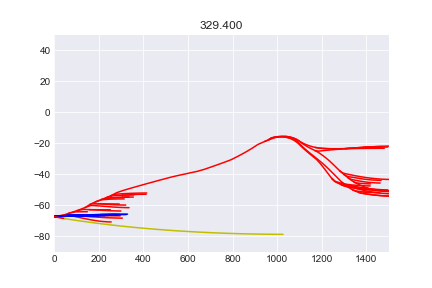
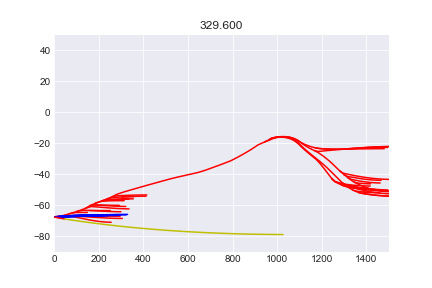
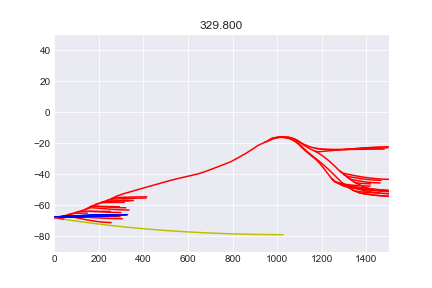
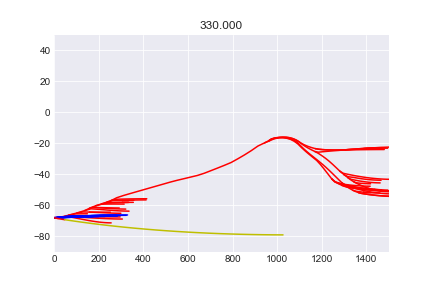
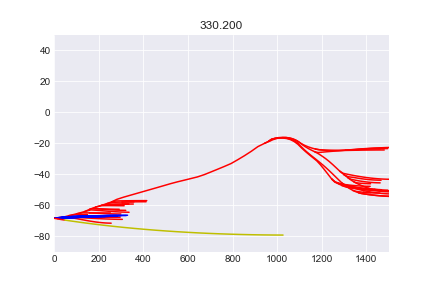
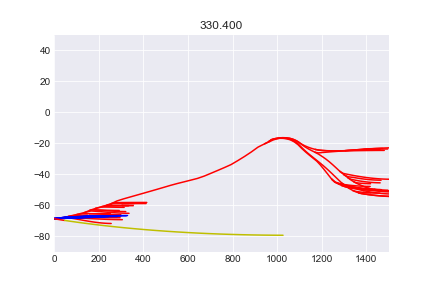
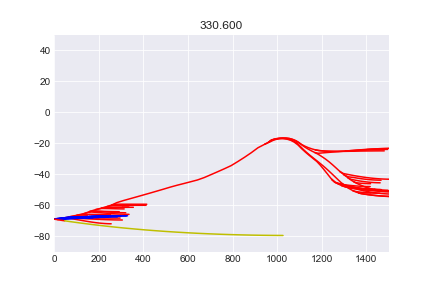
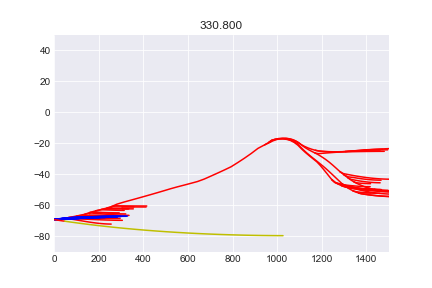
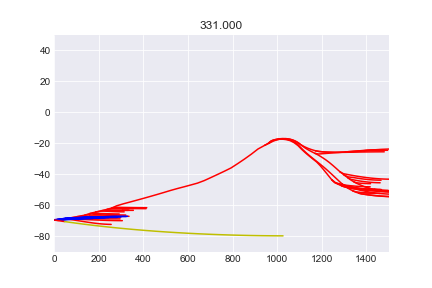
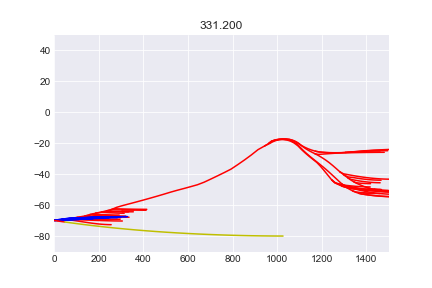
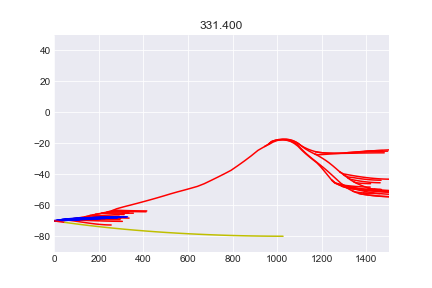
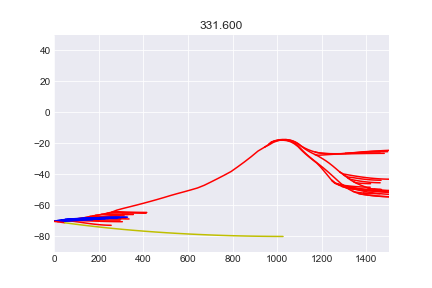
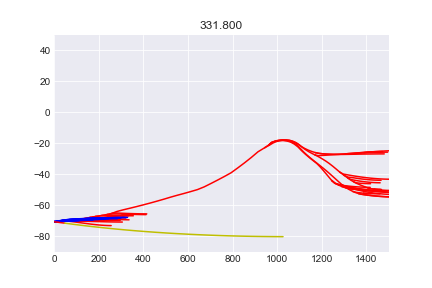
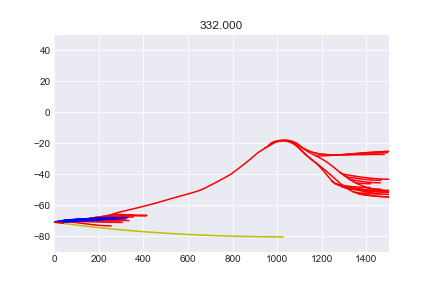
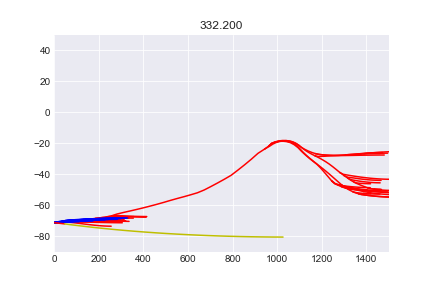
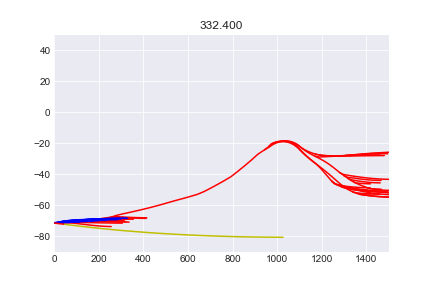
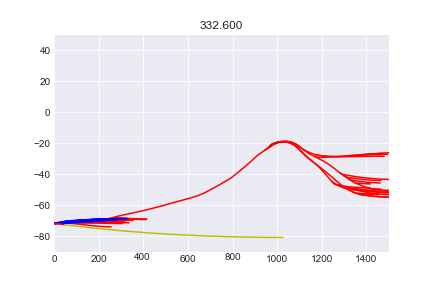
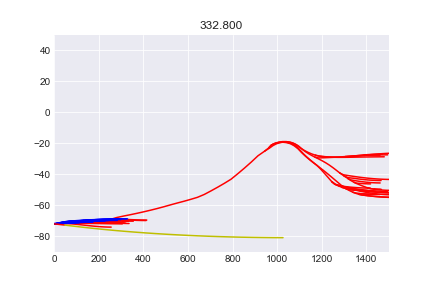
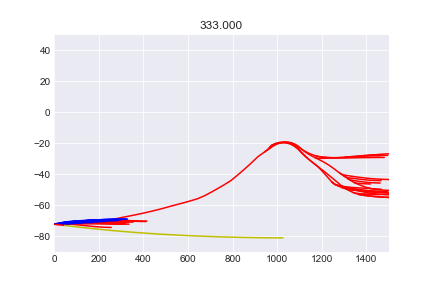
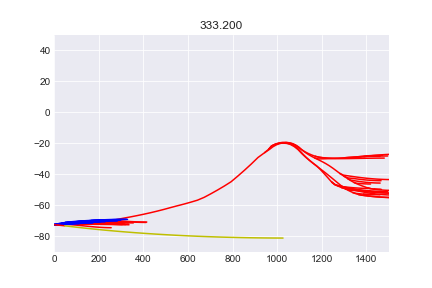
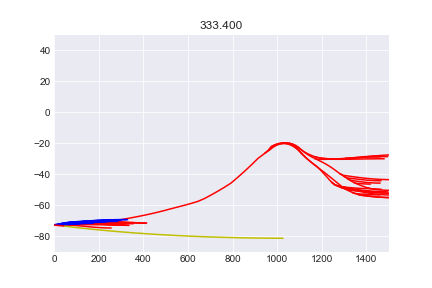
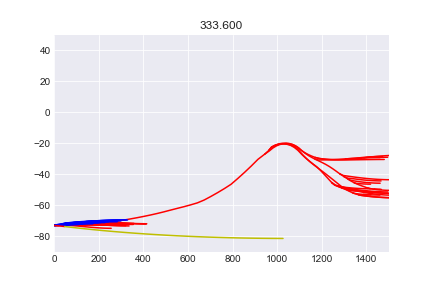
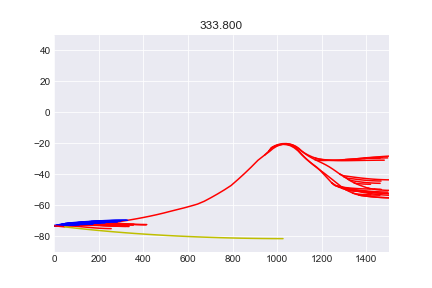
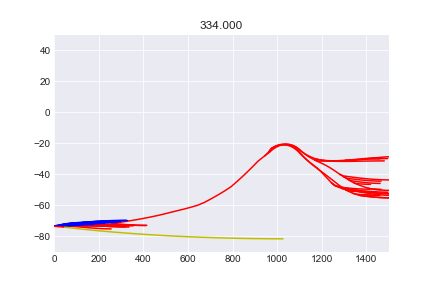
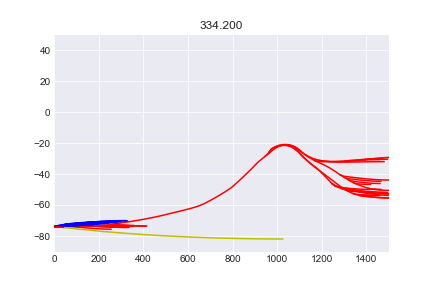
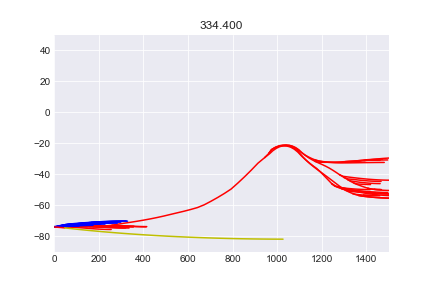
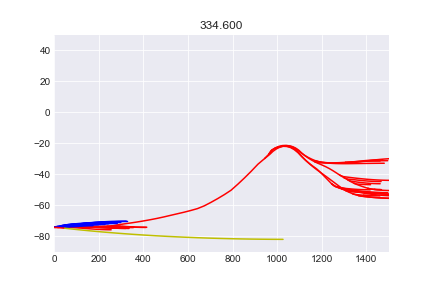
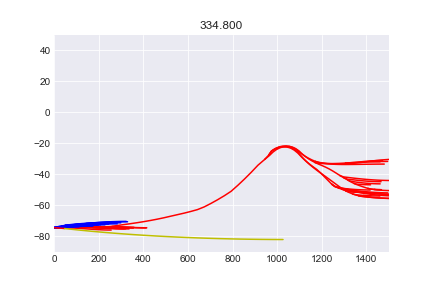
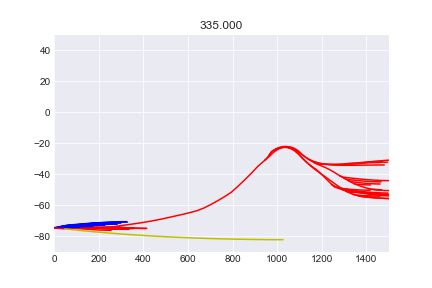
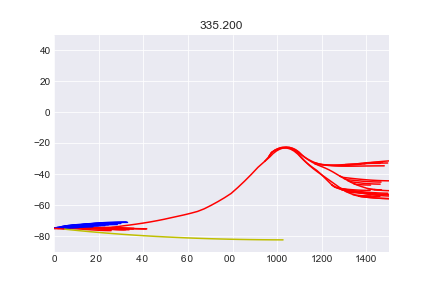
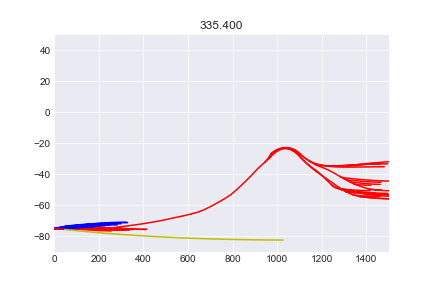
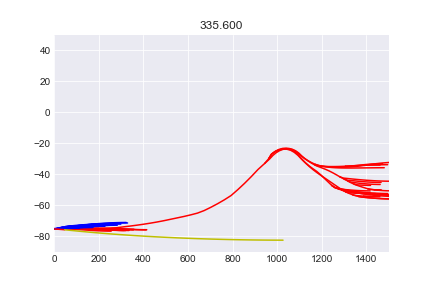
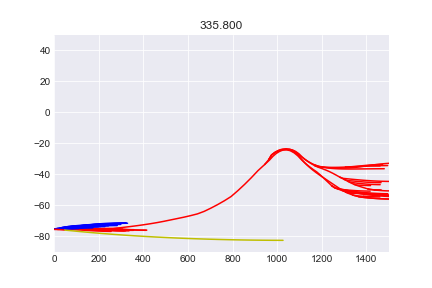
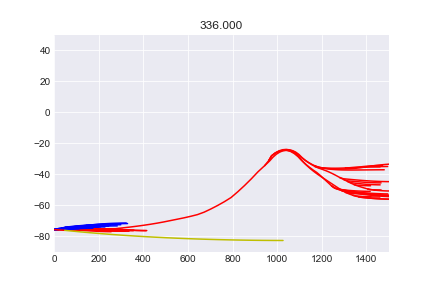
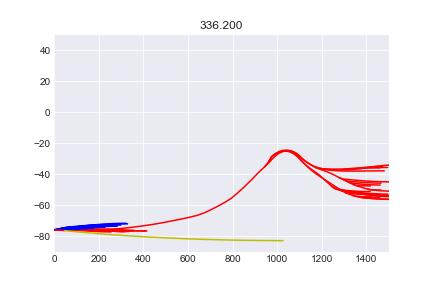
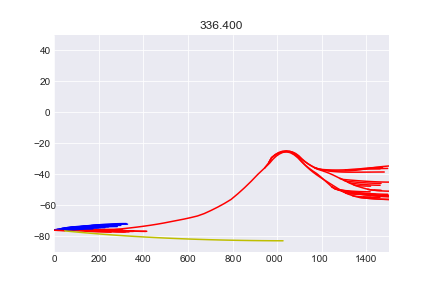
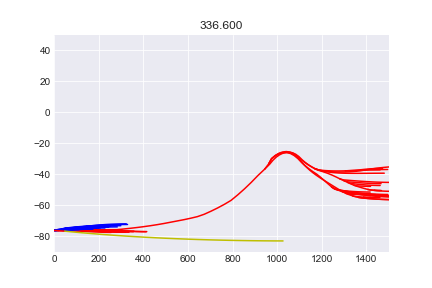
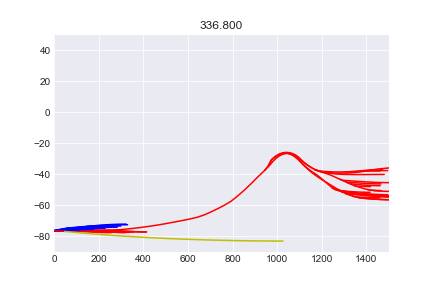
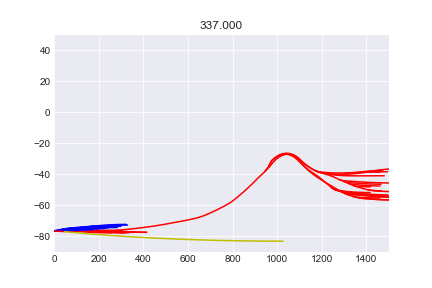
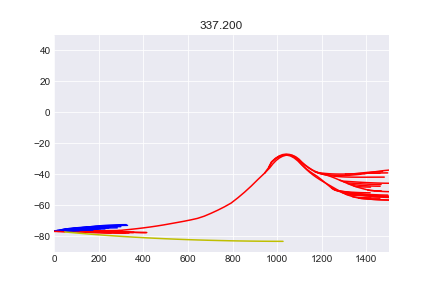
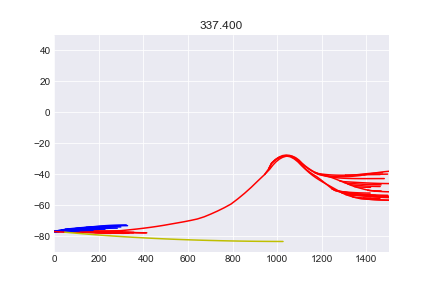
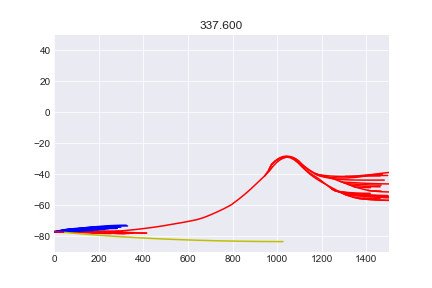
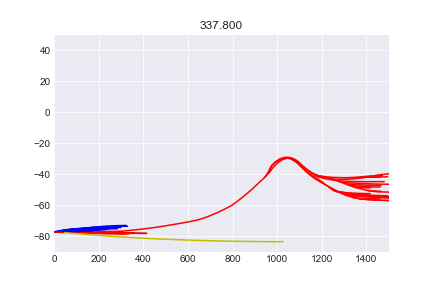
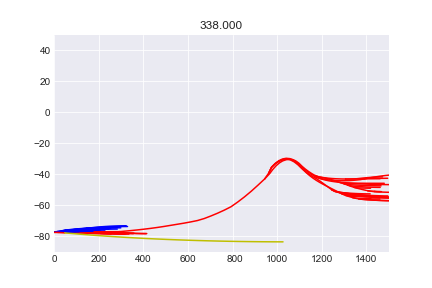
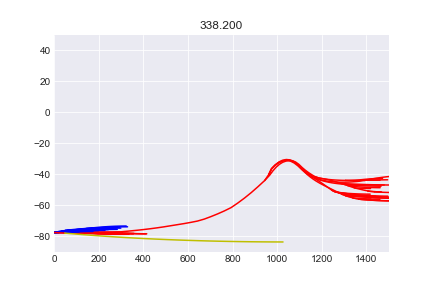
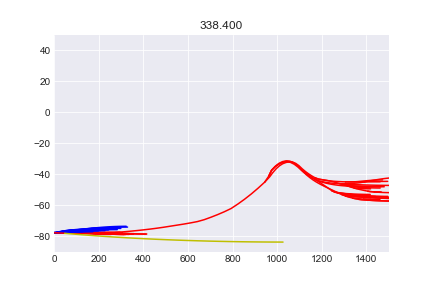
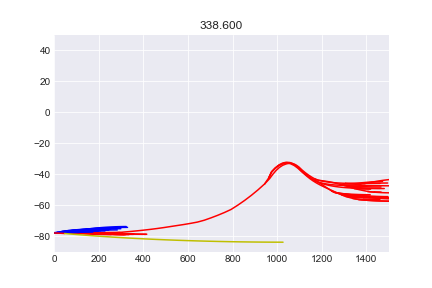
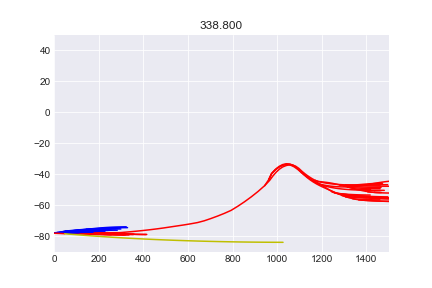
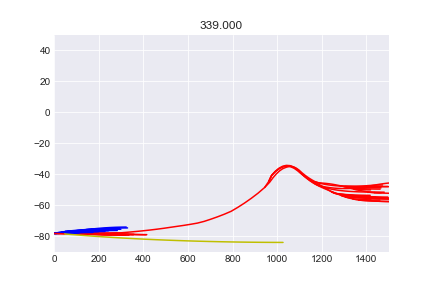
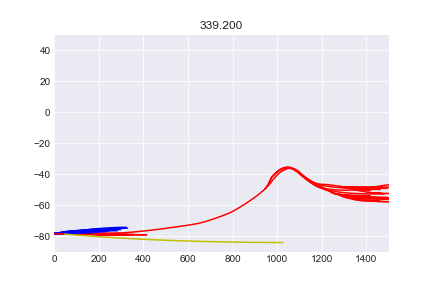
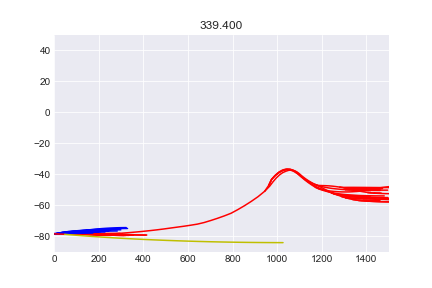
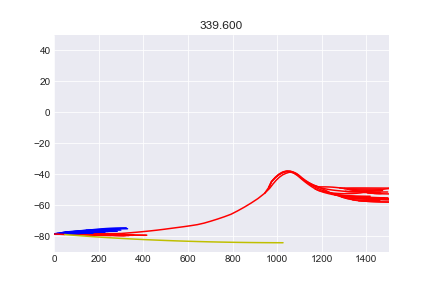
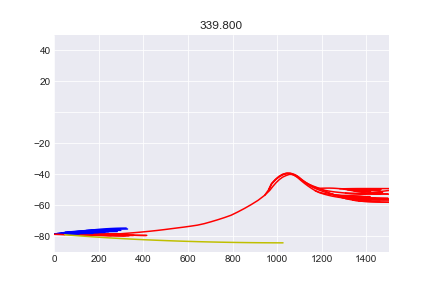
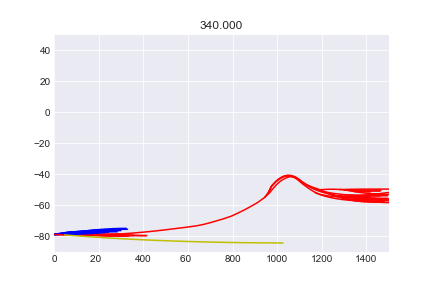
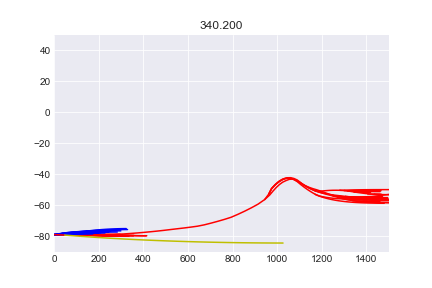
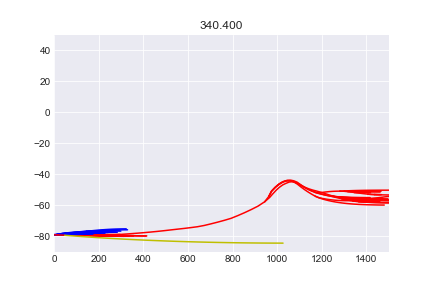
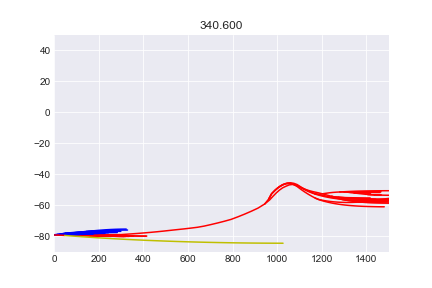
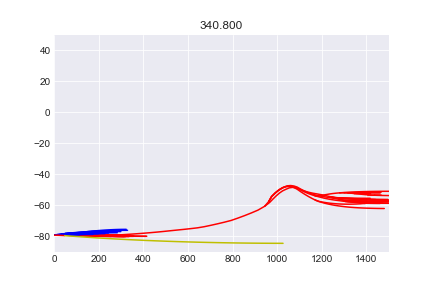
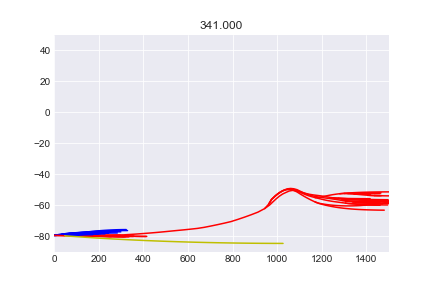
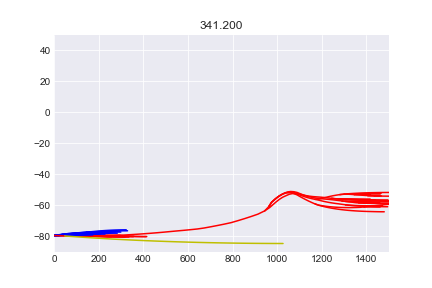
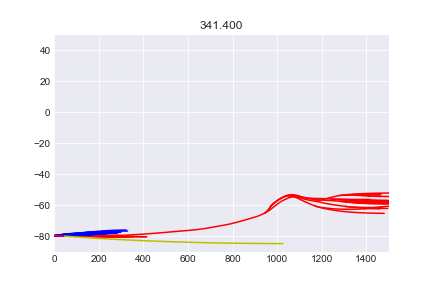
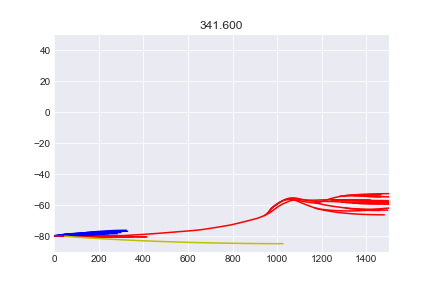
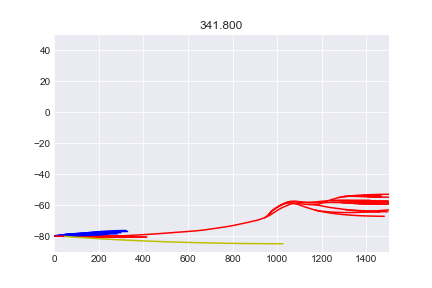
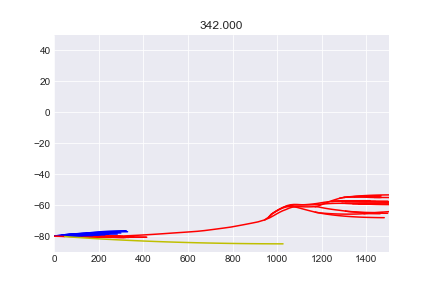
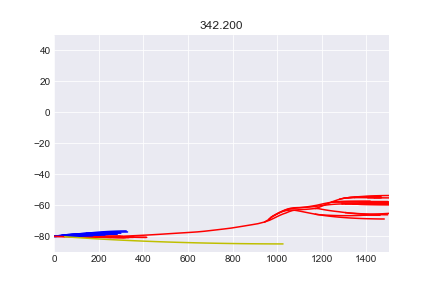
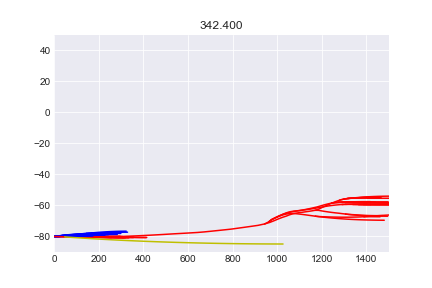
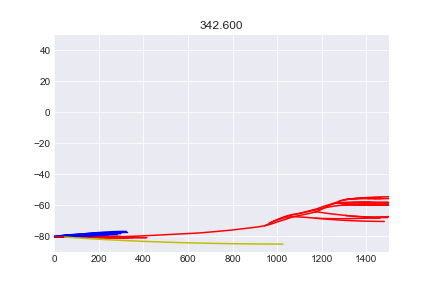
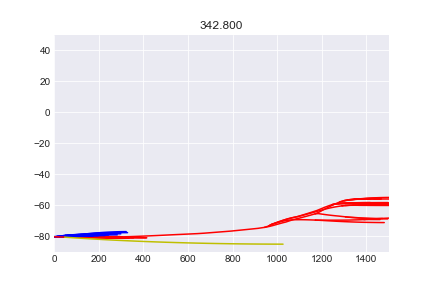
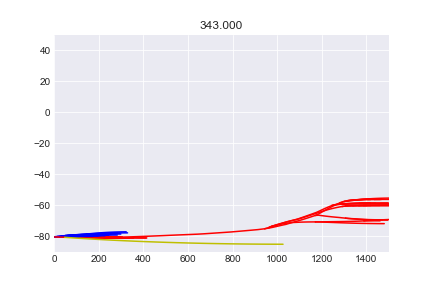
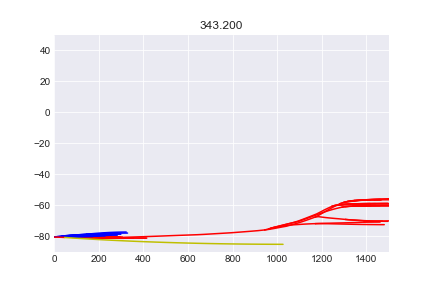
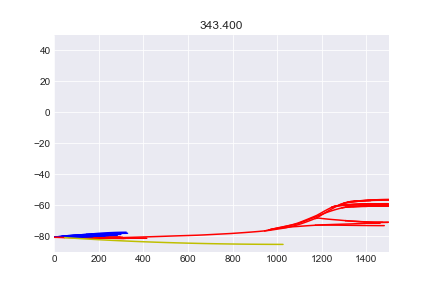
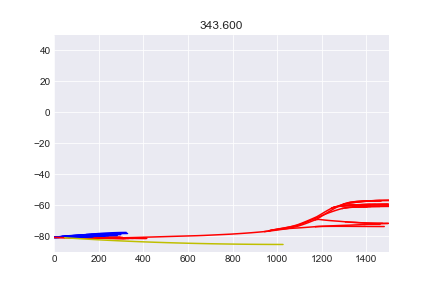
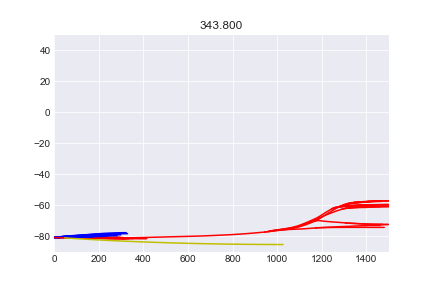
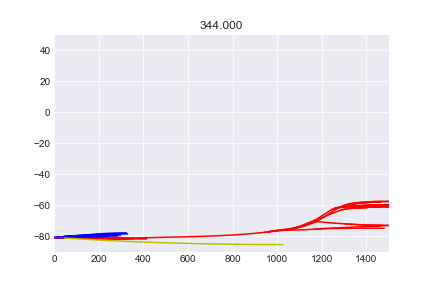
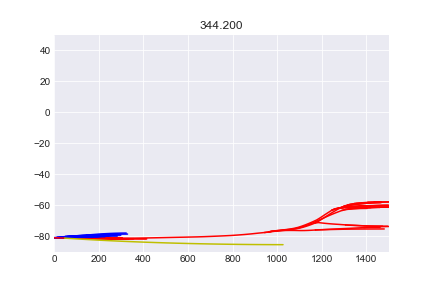
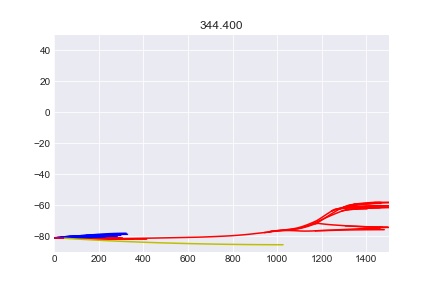
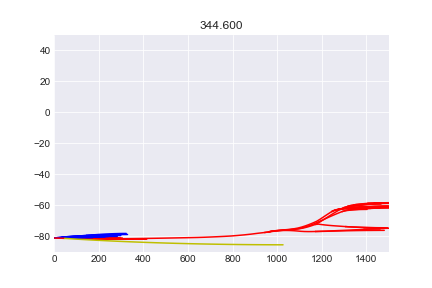
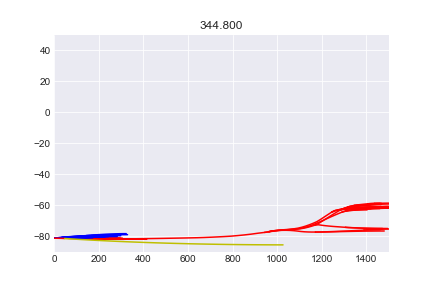
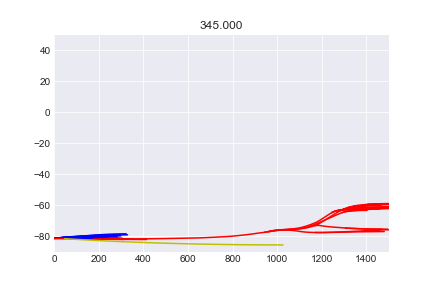
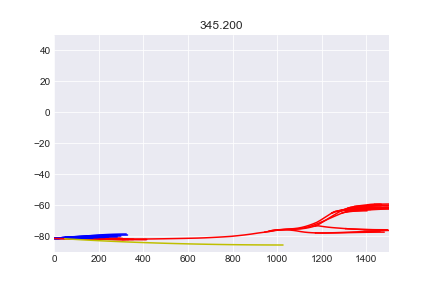
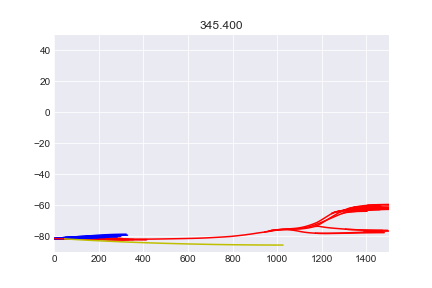
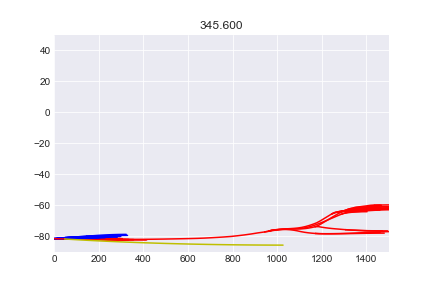
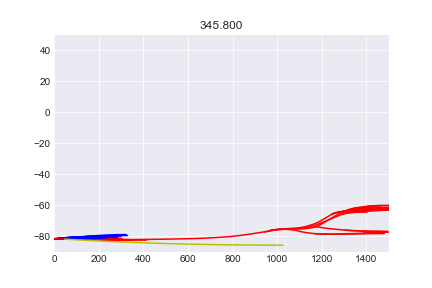
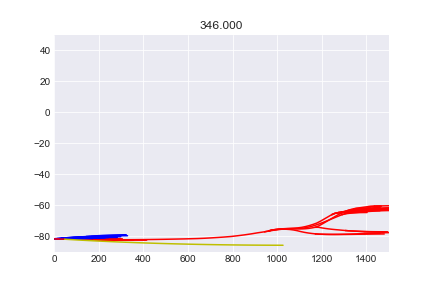
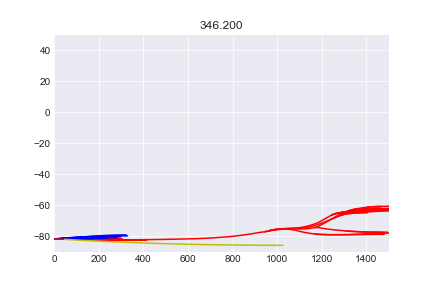
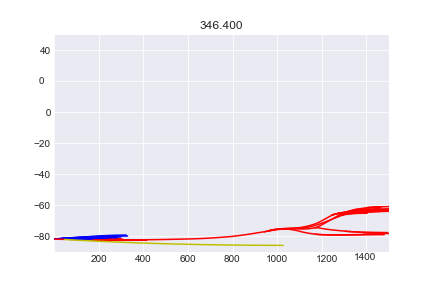
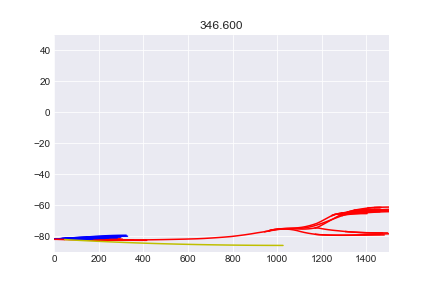
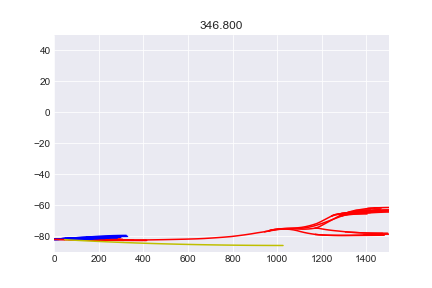
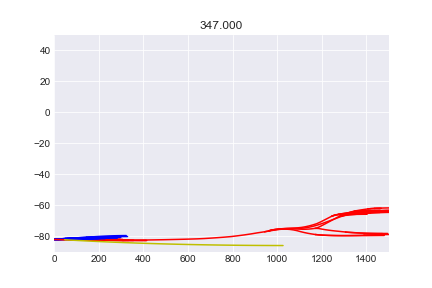
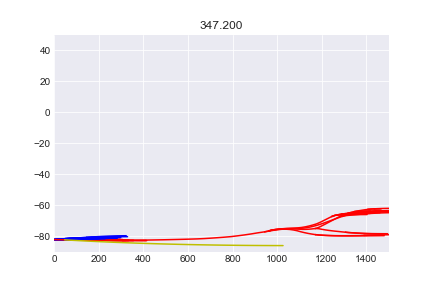
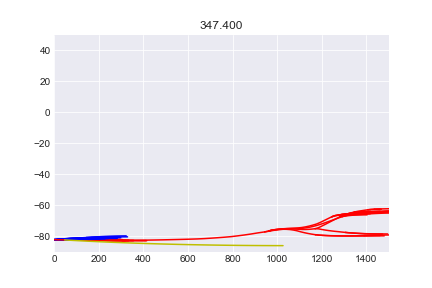
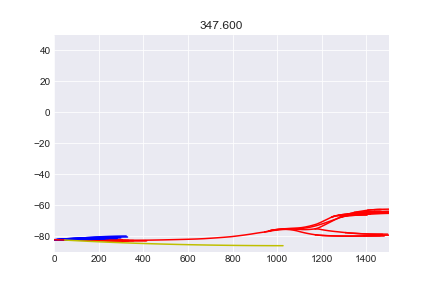
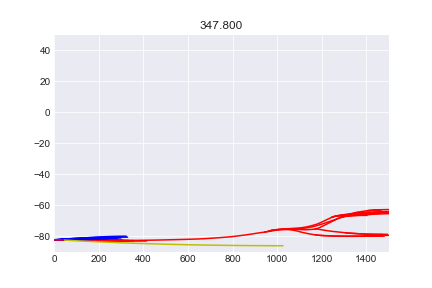
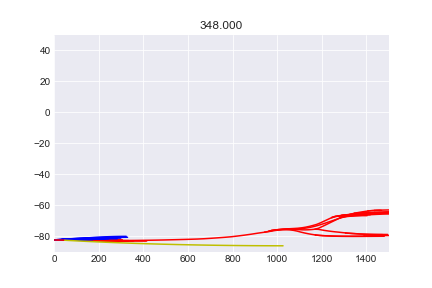
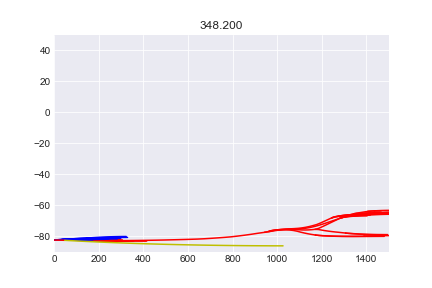
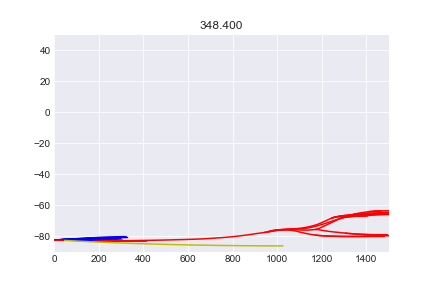
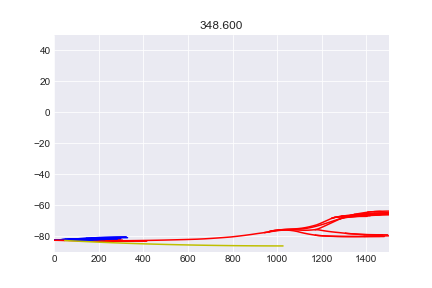
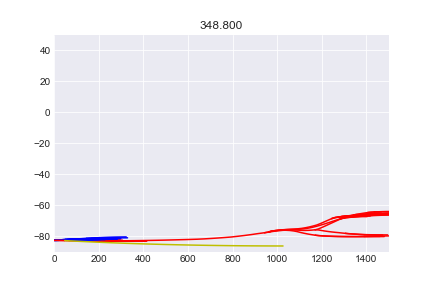
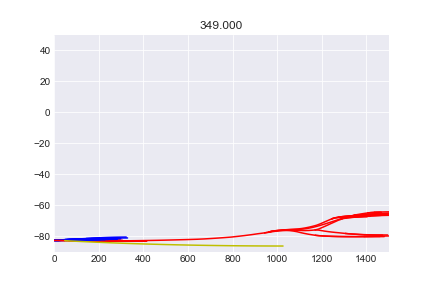
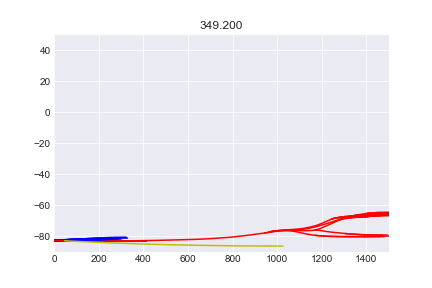
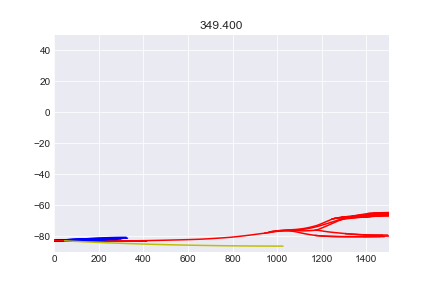
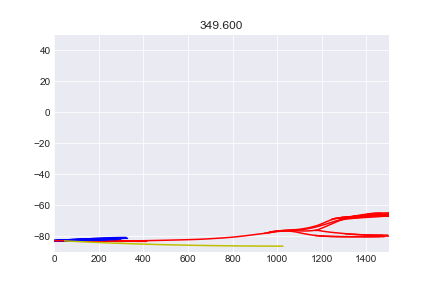
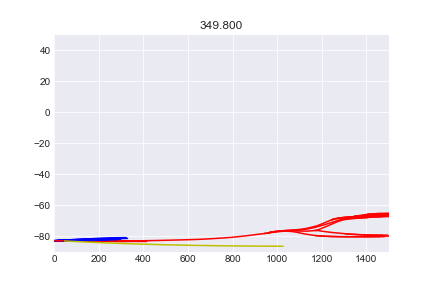

In [24]:
if not 'burst_trail_video' in mdb.keys():
    I.scp.init_neuron_run(cell_param.sim, vardt=False) # fixed step size necessary for animation
    I.cell_to_animation(cell, \
                        xlim = [0,1500], \
                        ylim = [-90, 50], \
                        tstart = 295, \
                        tend = 350, \
                        tstep = 0.2, \
                        outdir = mdb.create_managed_folder('burst_trail_video'))
I.display_animation(mdb['burst_trail_video'].join('*', '*.png'), embedded=True)

We can also visualize current through ion channels. Let's have a look at the calcium current through low voltage activated calcium channels:

files are here: /home/abast/my_mdb/burst_trail_ca_current_video_p2inhJ_/animation_uq_p2E/*.png



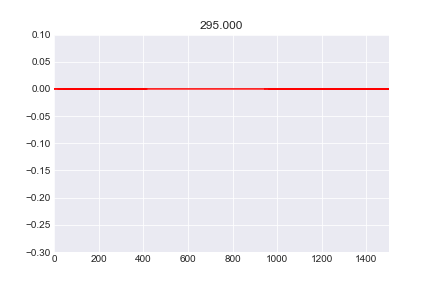
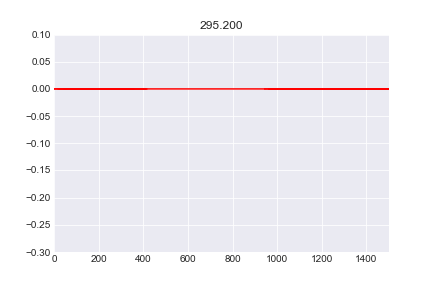
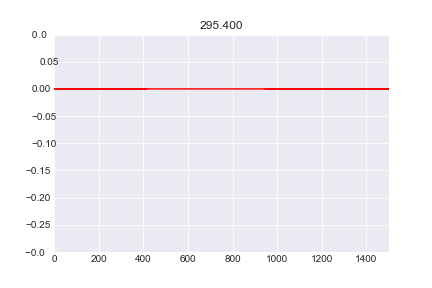
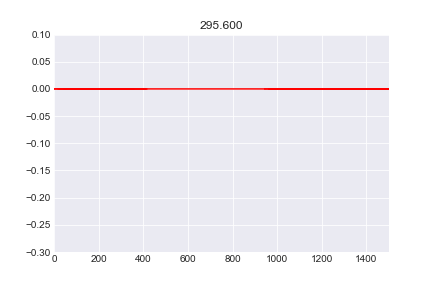
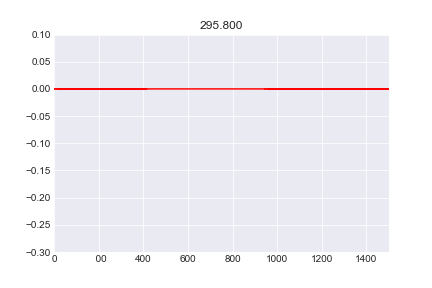
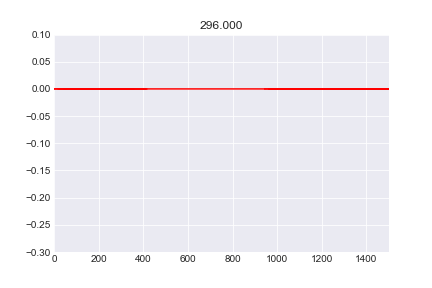
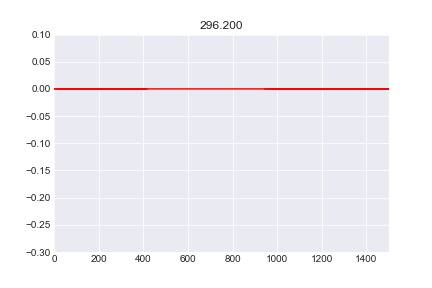
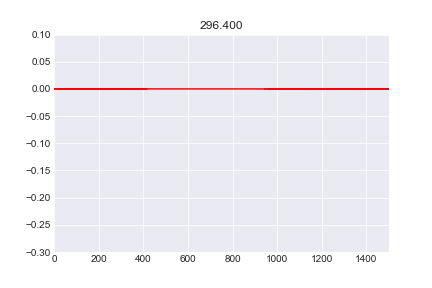
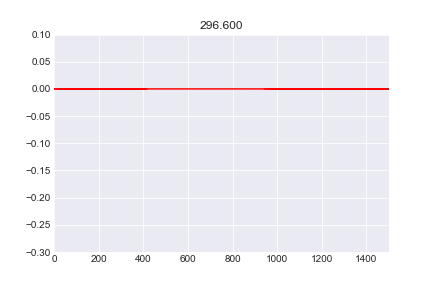
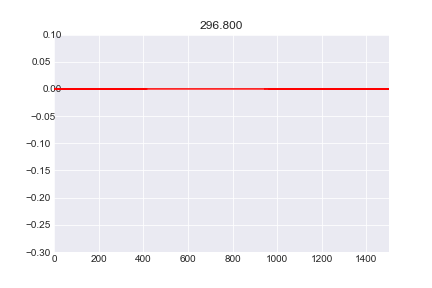
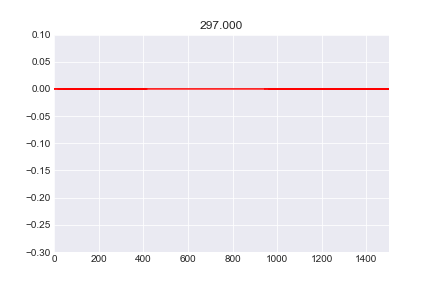
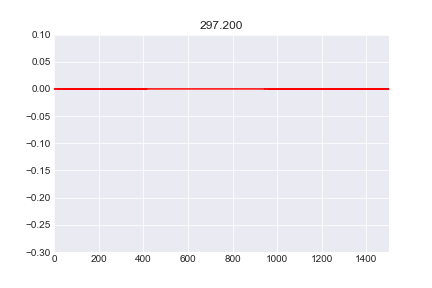
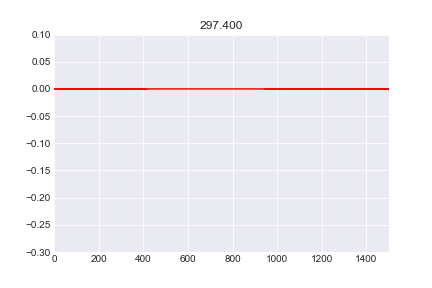
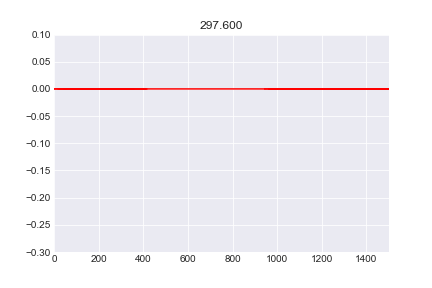
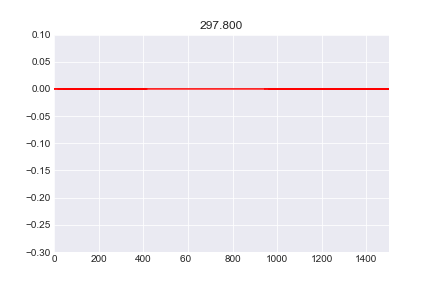
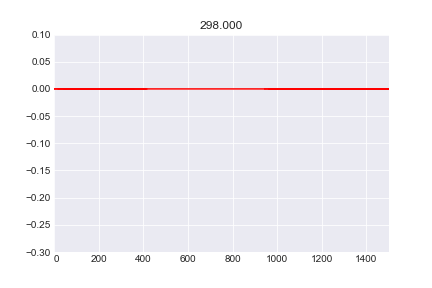
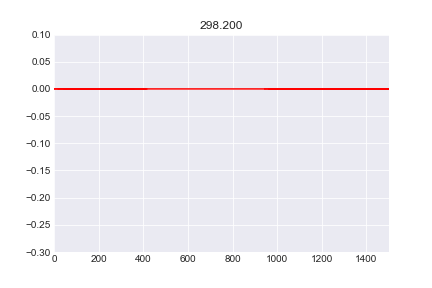
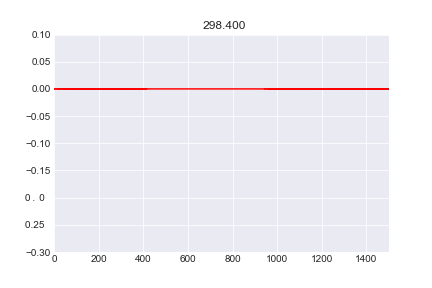
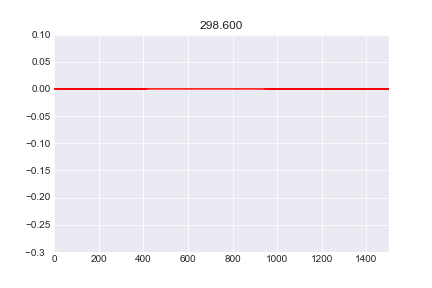
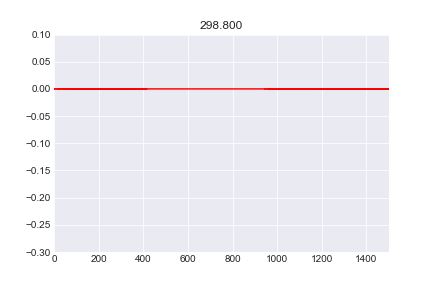
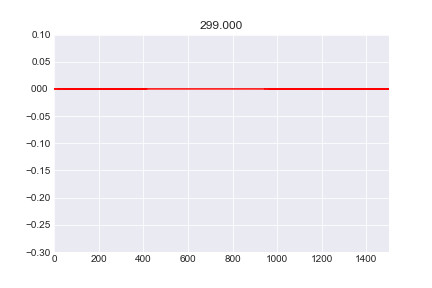
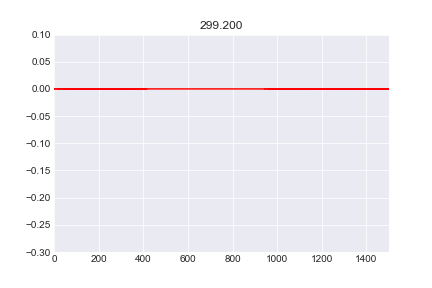
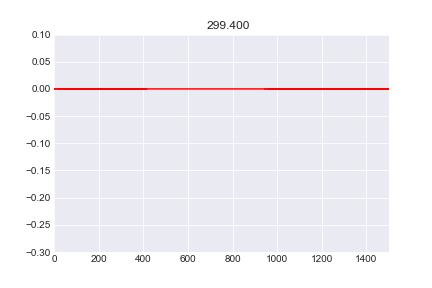
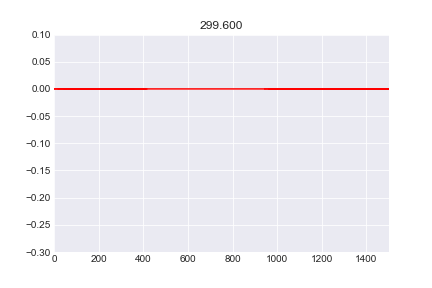
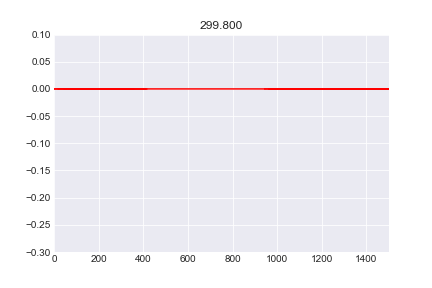
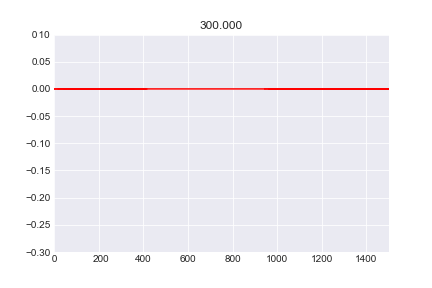
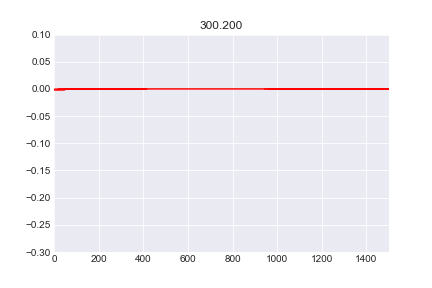
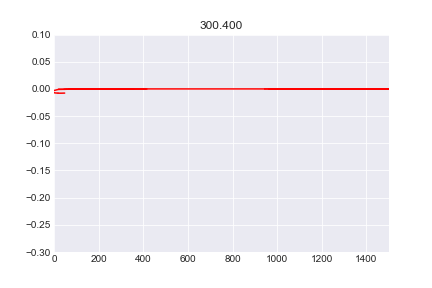
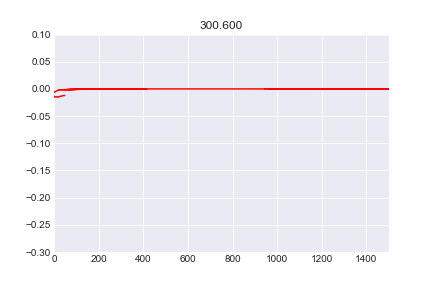
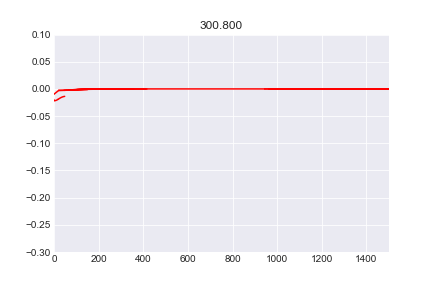
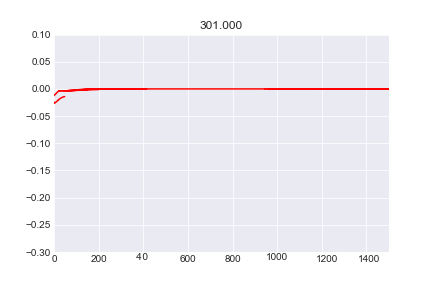
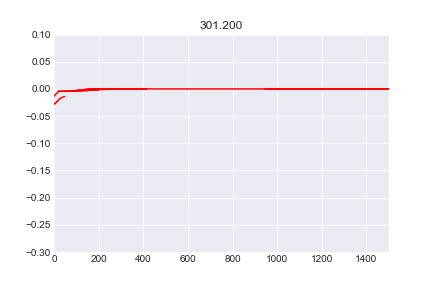
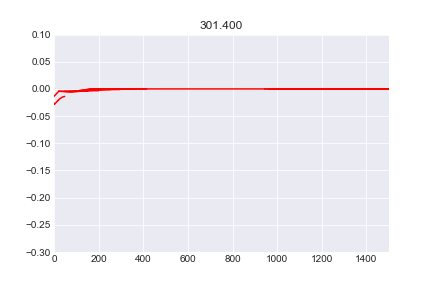
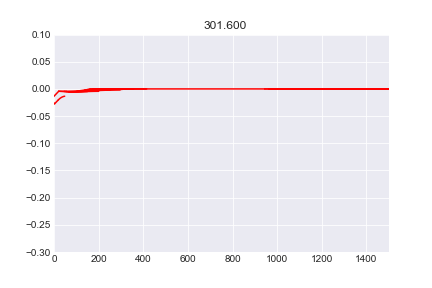
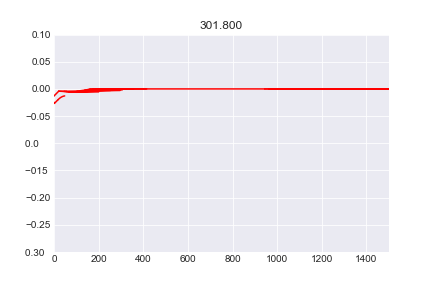
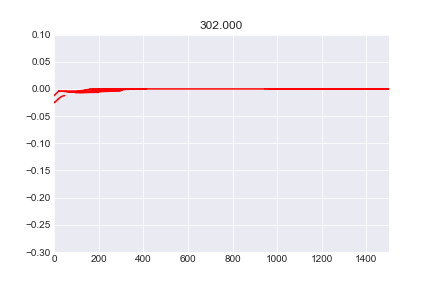
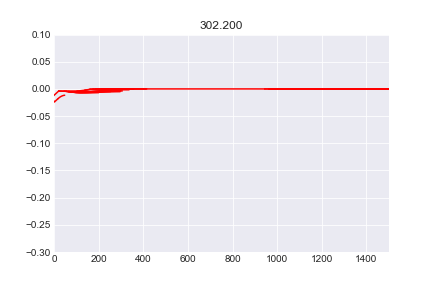
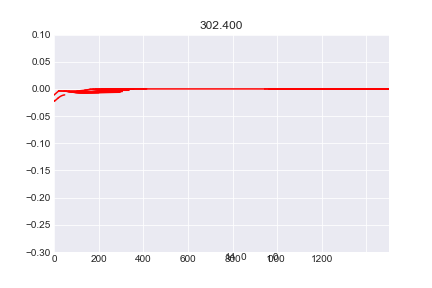
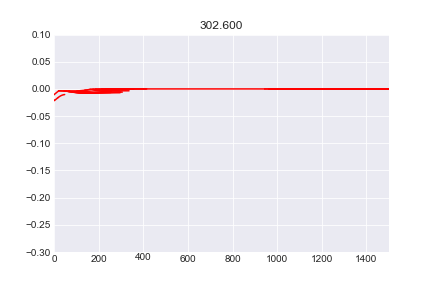
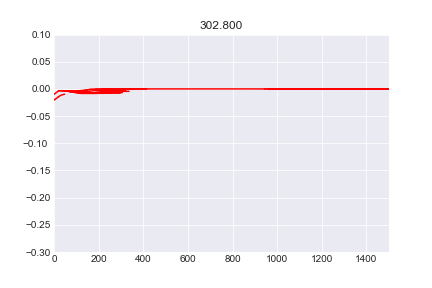
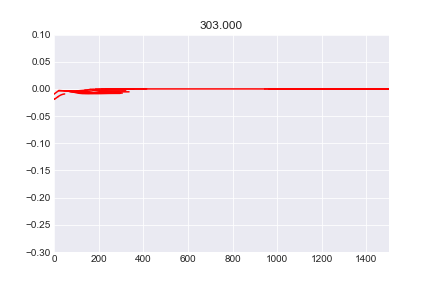
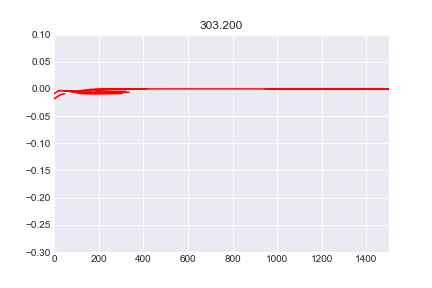
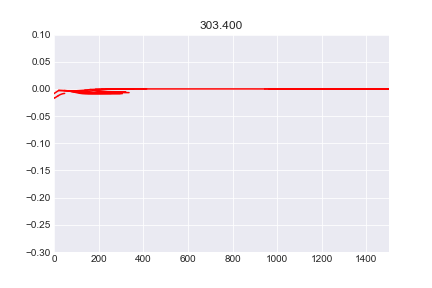
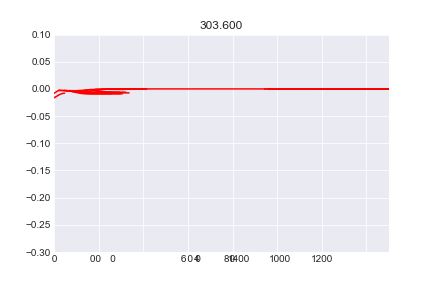
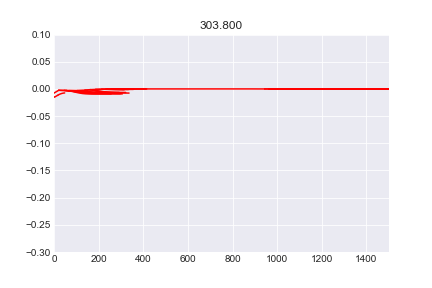
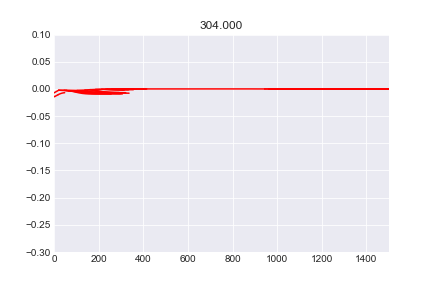
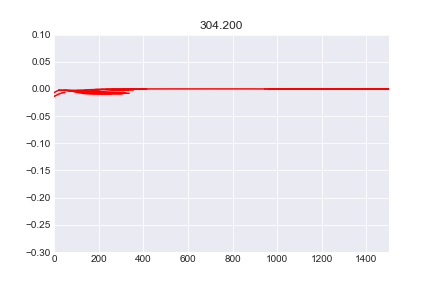
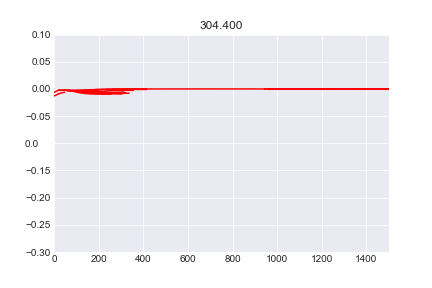
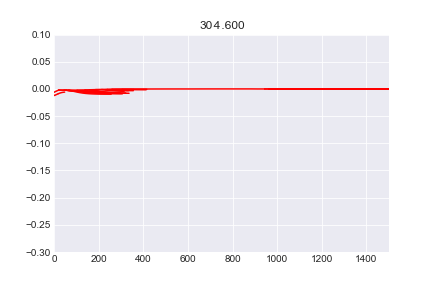
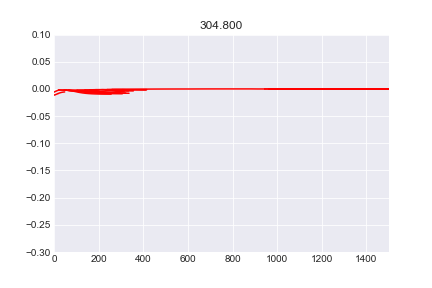
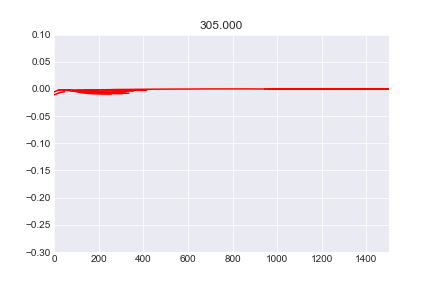
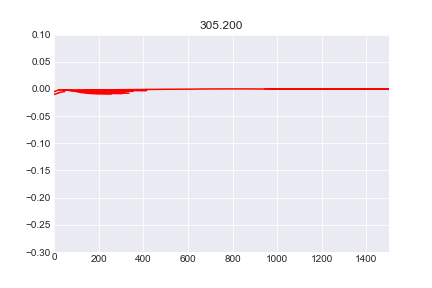
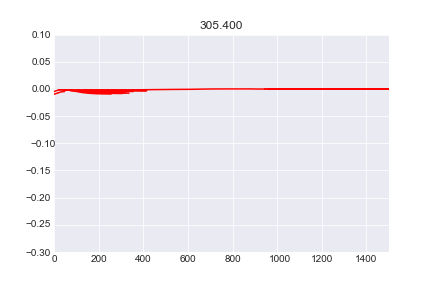
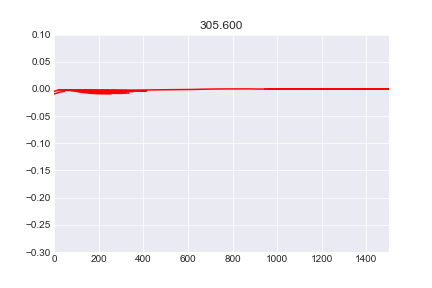
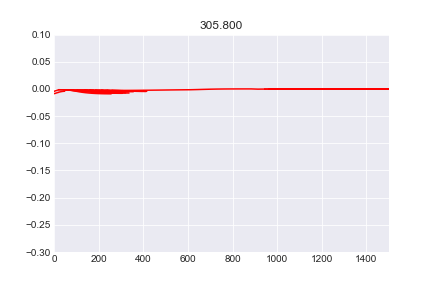
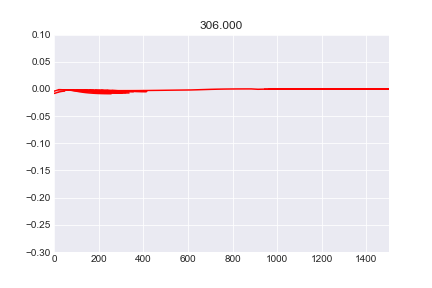
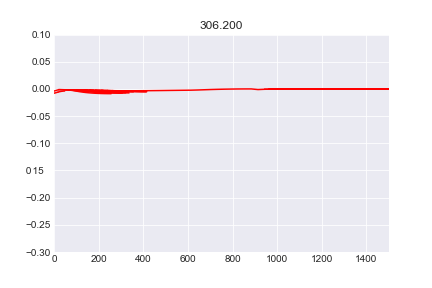
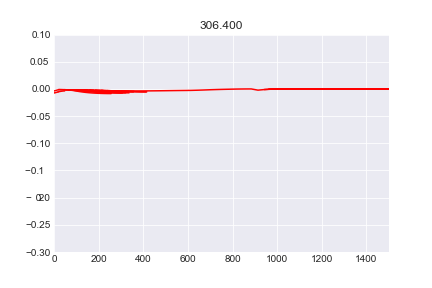
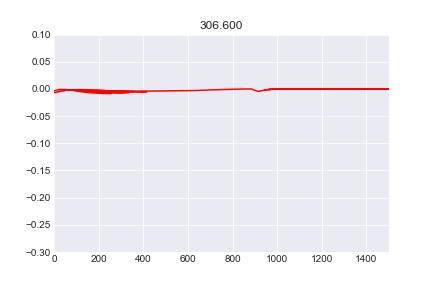
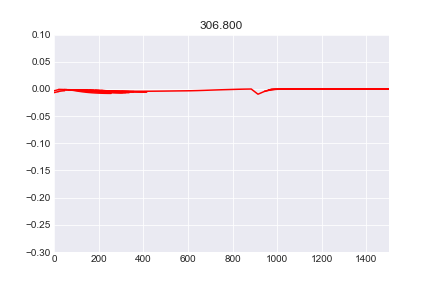
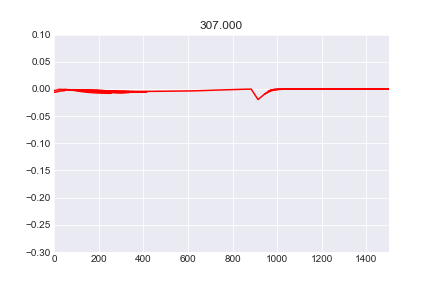
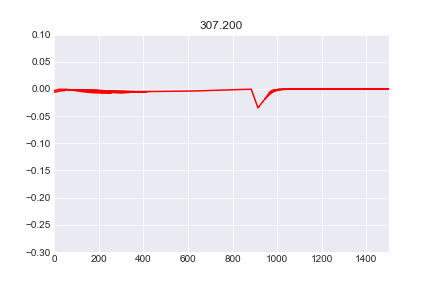
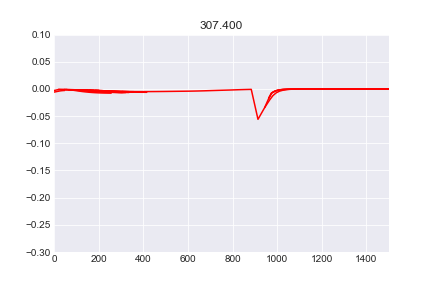
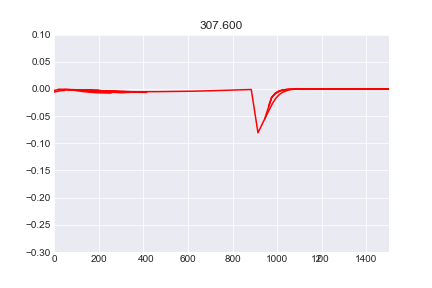
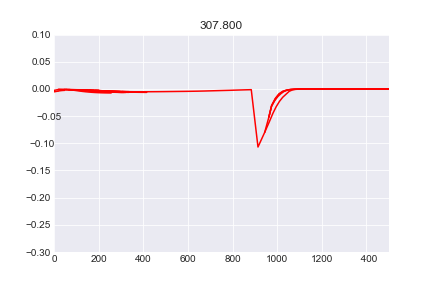
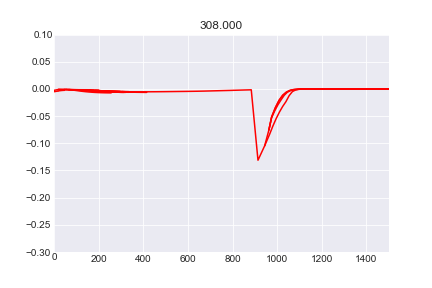
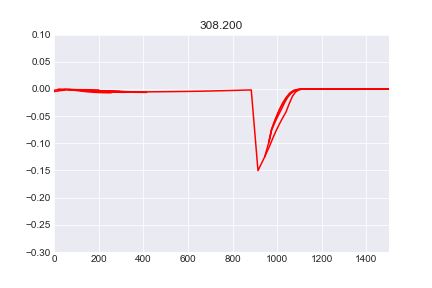
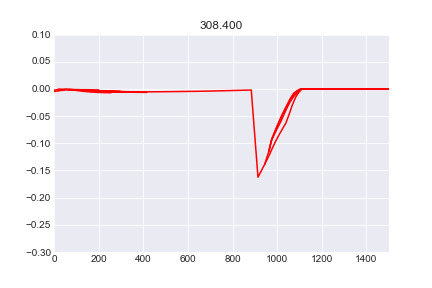
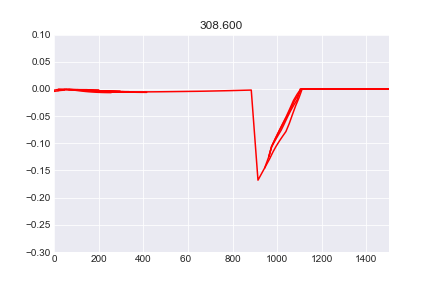
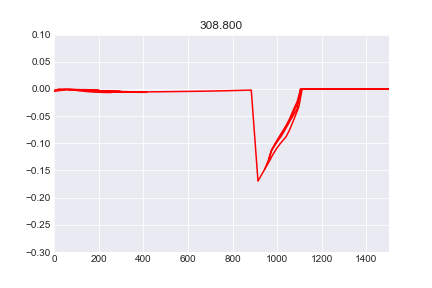
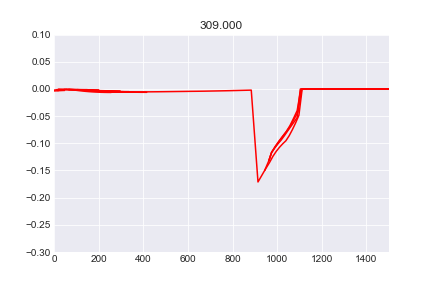
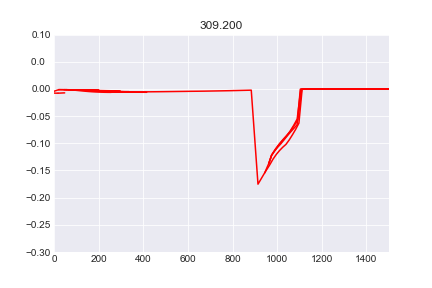
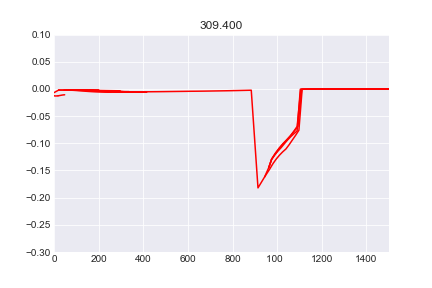
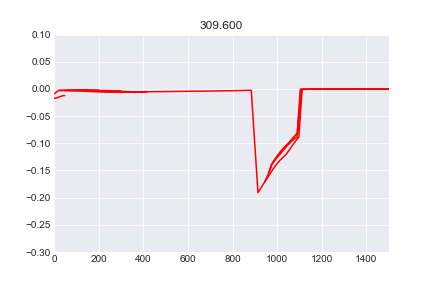
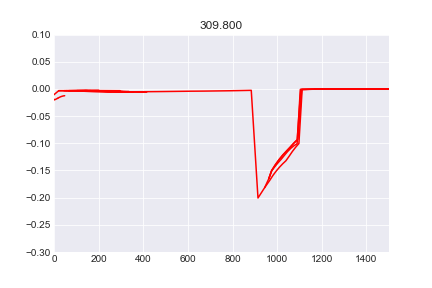
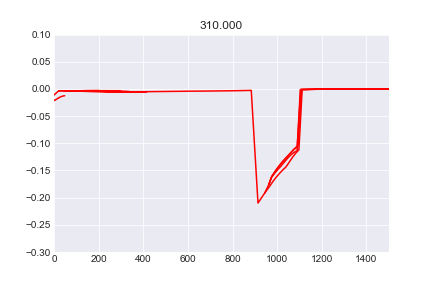
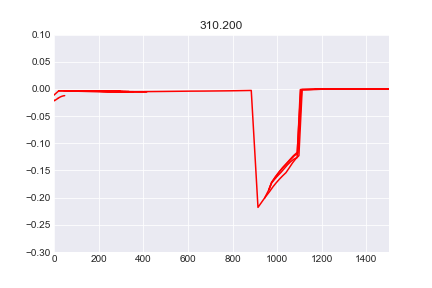
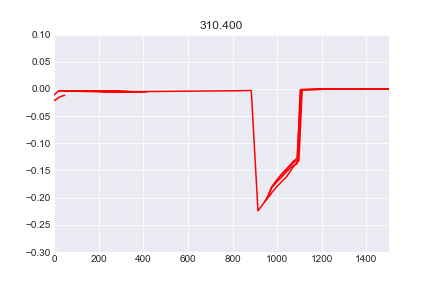
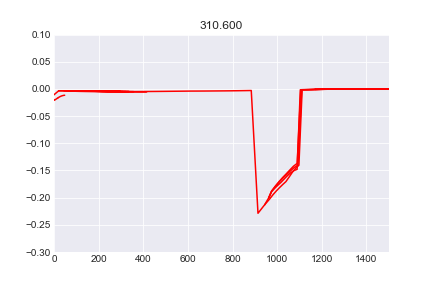
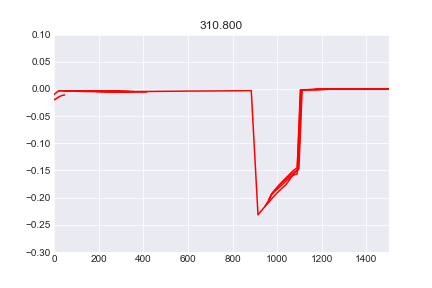
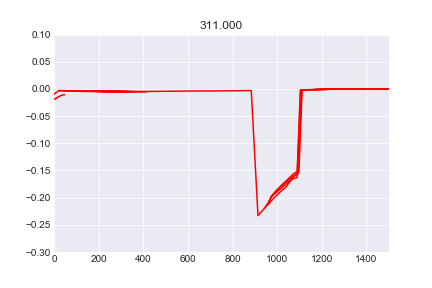
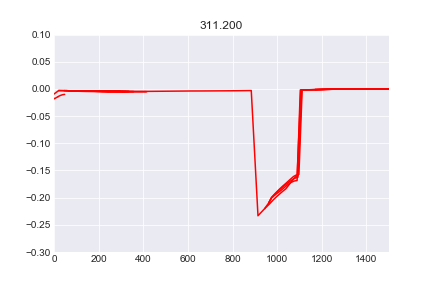
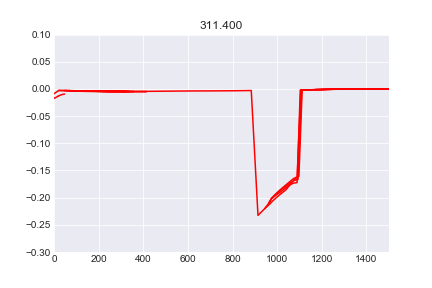
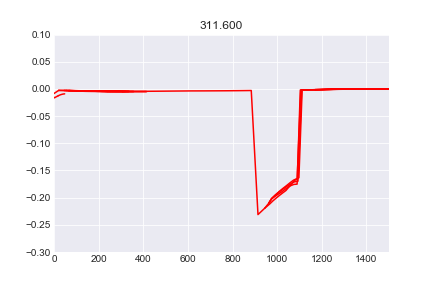
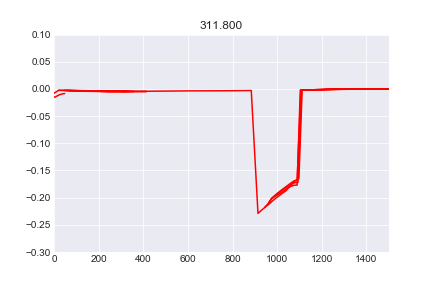
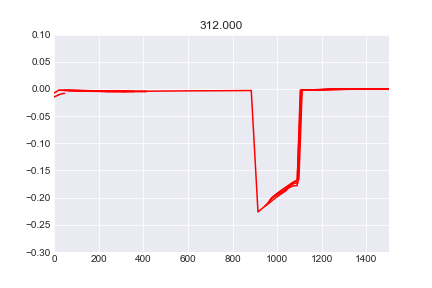
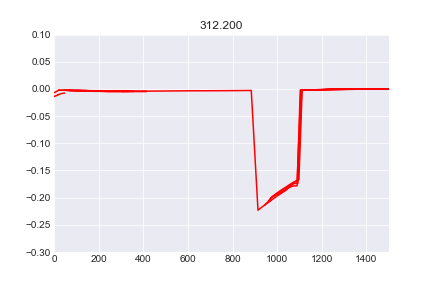
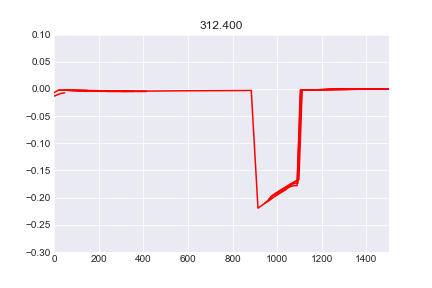
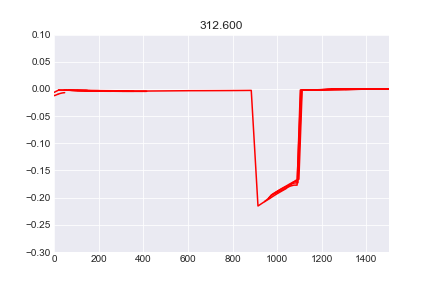
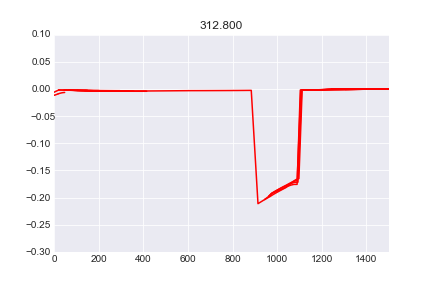
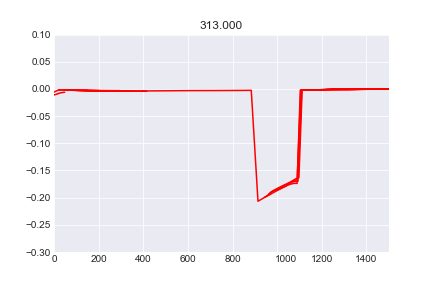
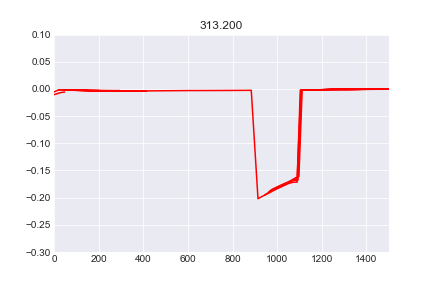
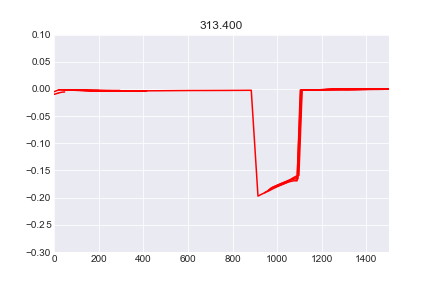
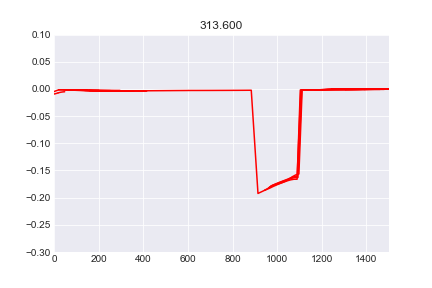
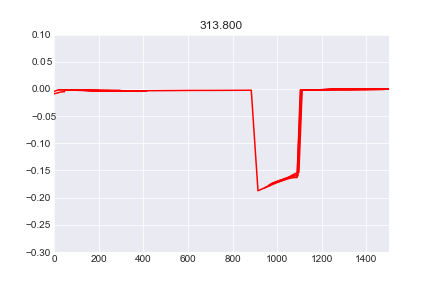
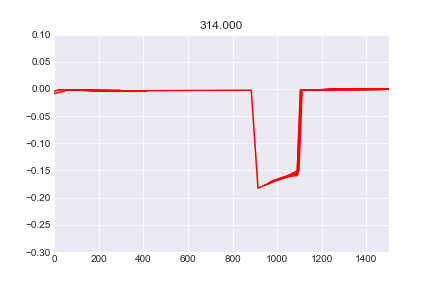
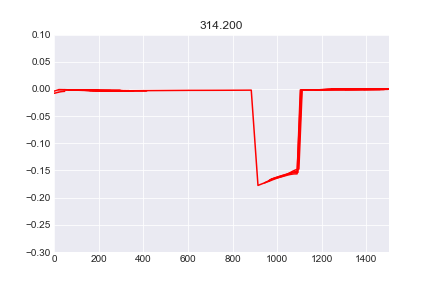
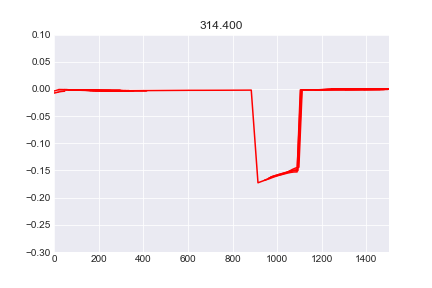
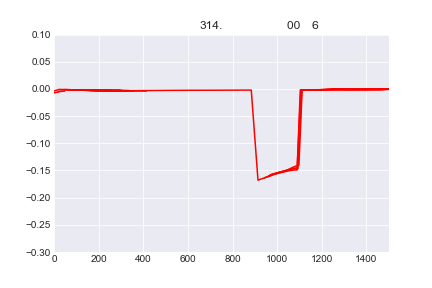
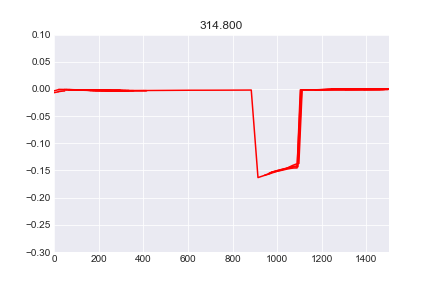
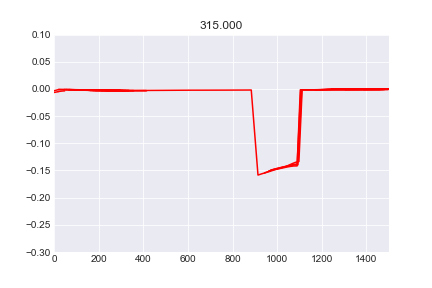
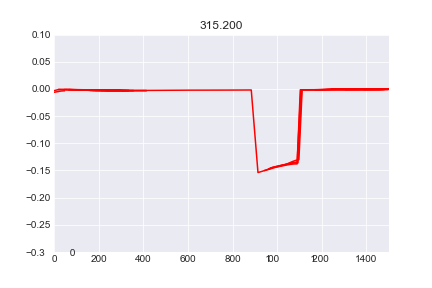
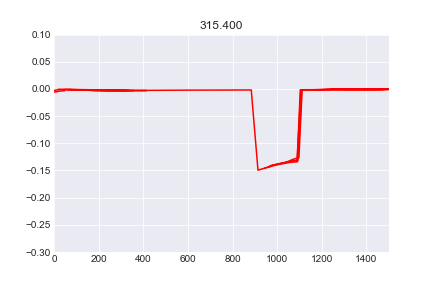
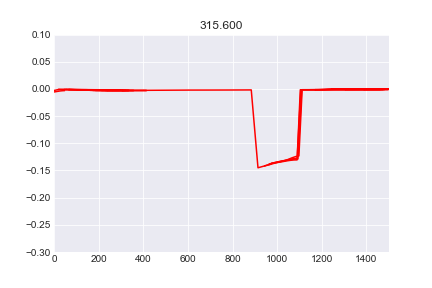
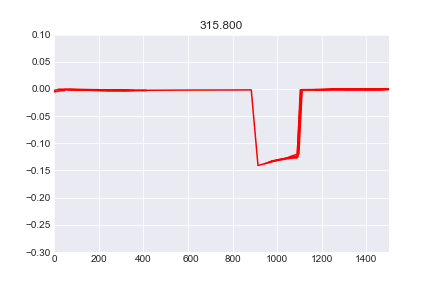
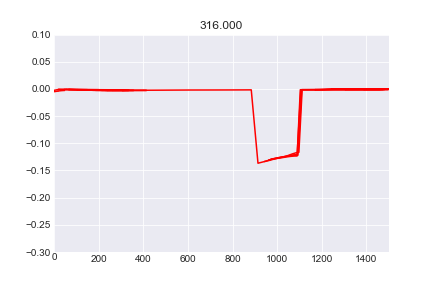
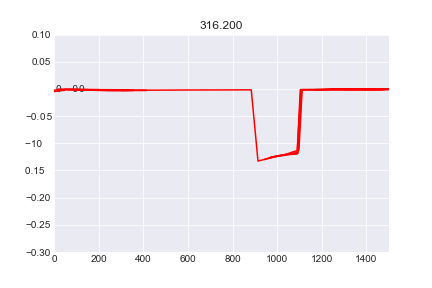
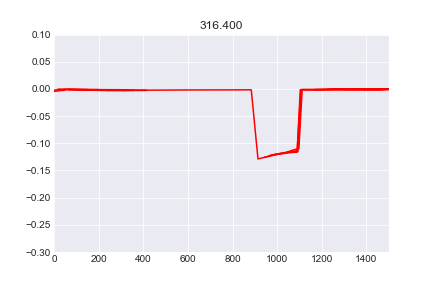
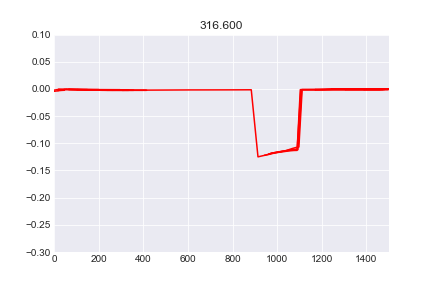
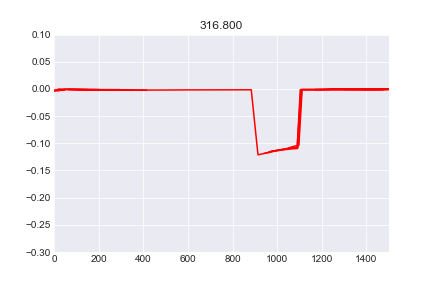
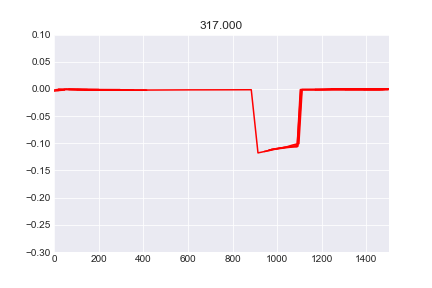
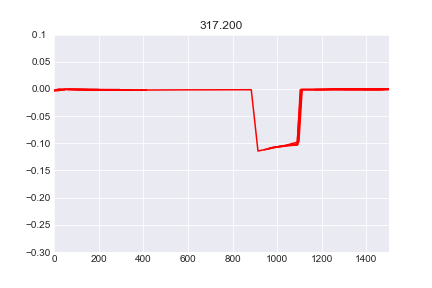
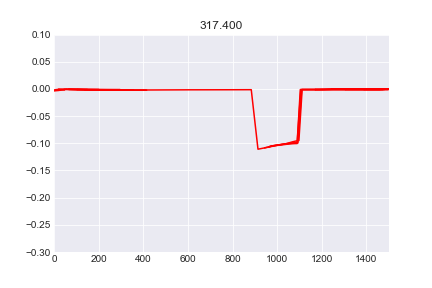
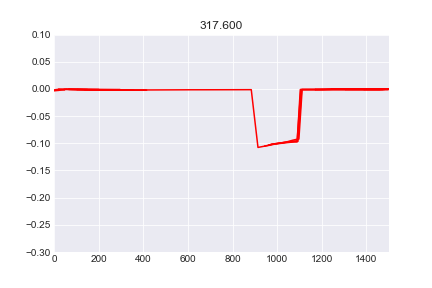
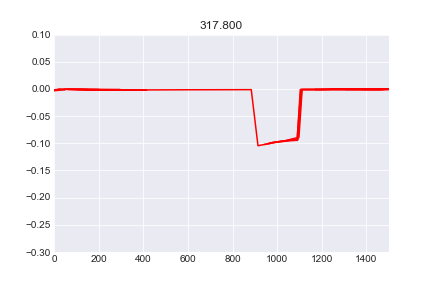
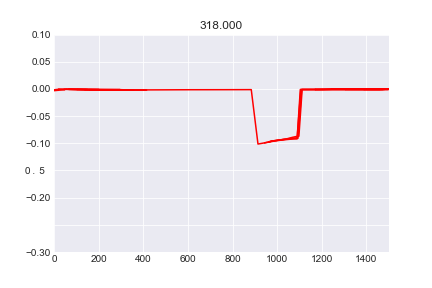
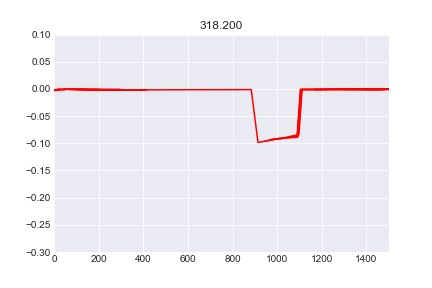
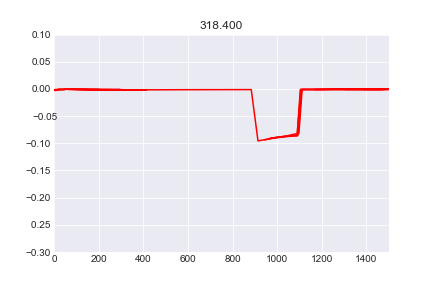
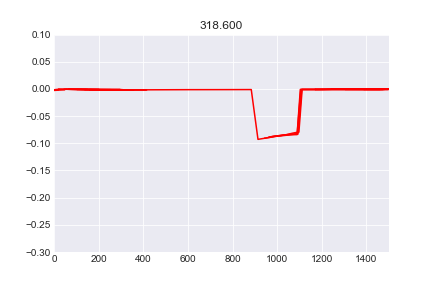
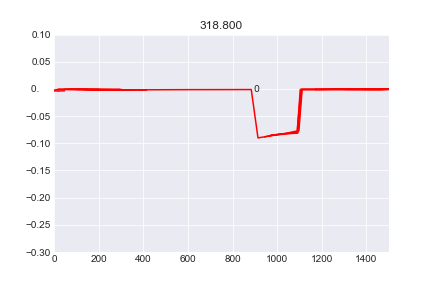
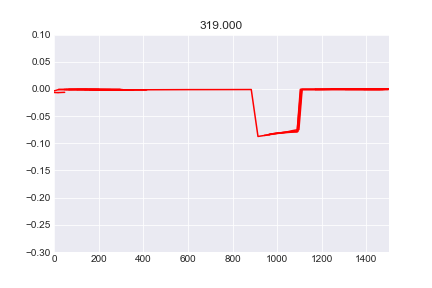
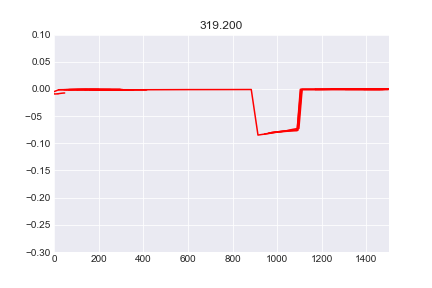
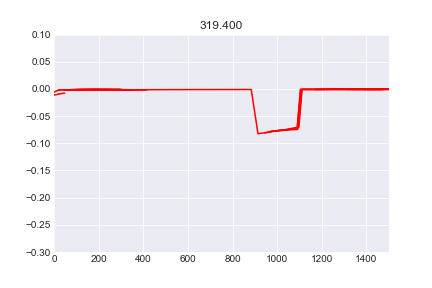
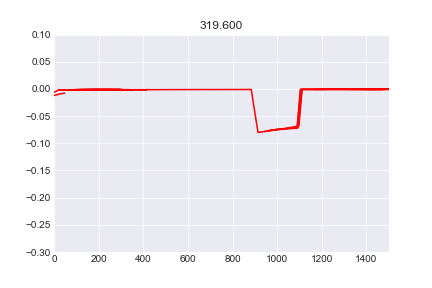
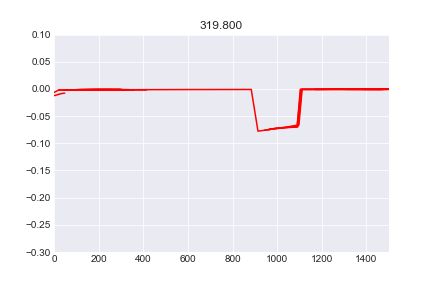
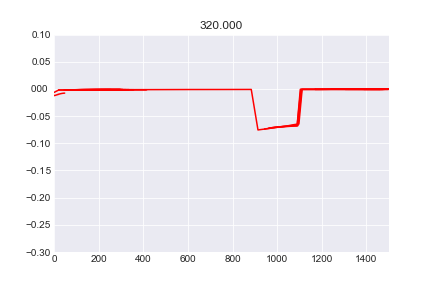
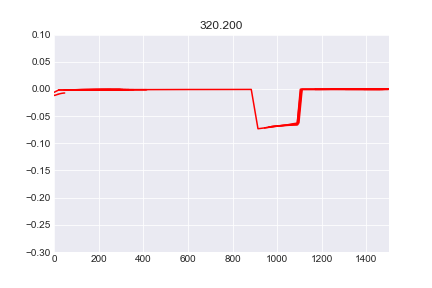
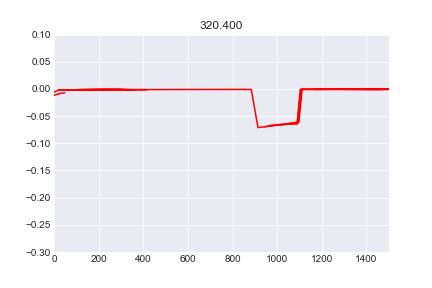
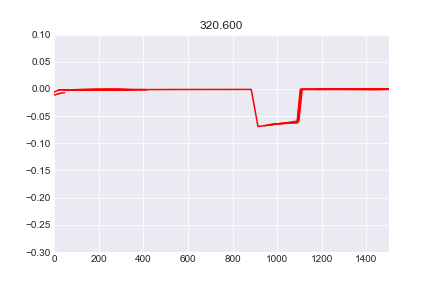
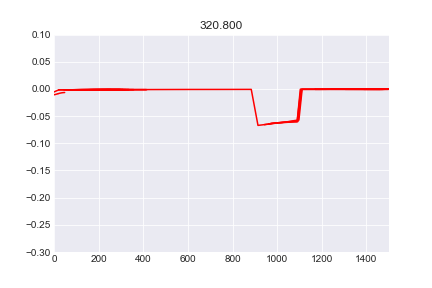
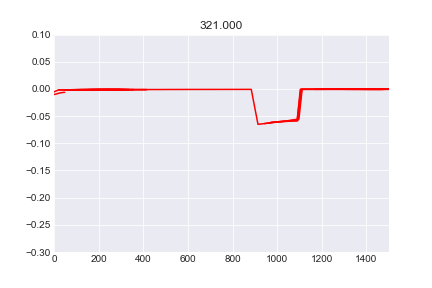
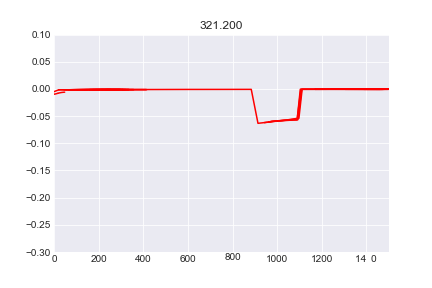
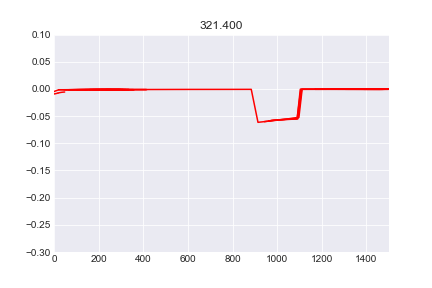
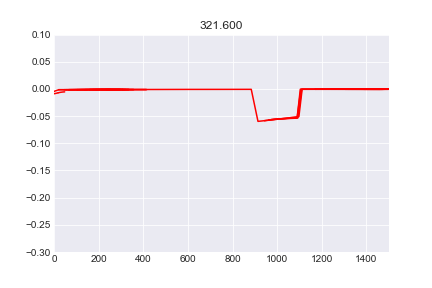
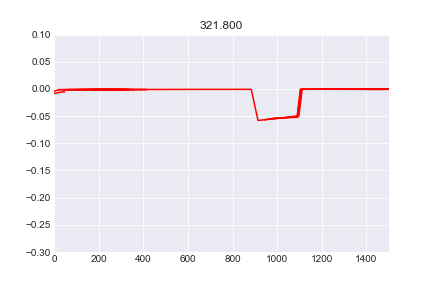
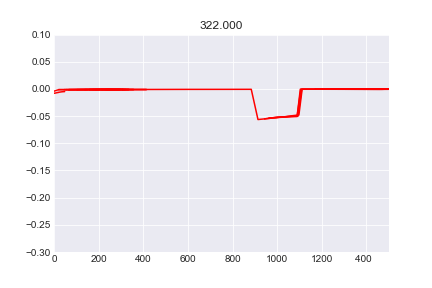
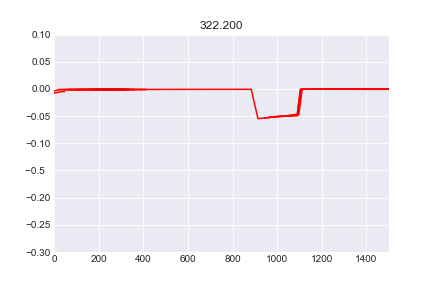
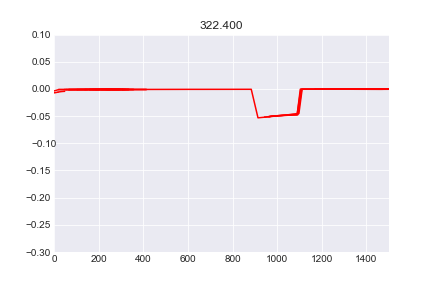
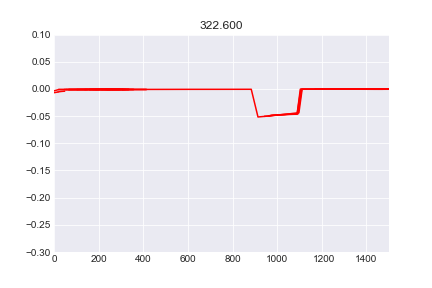
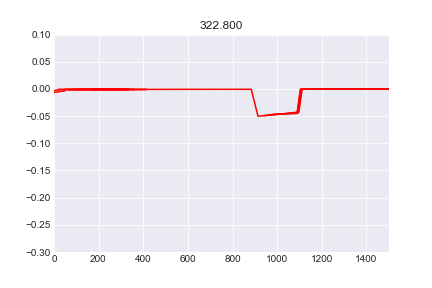
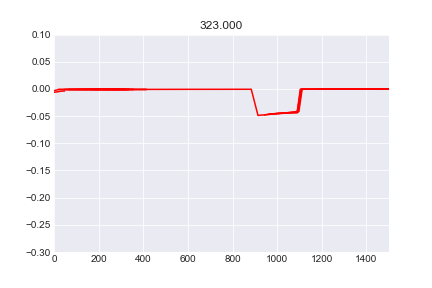
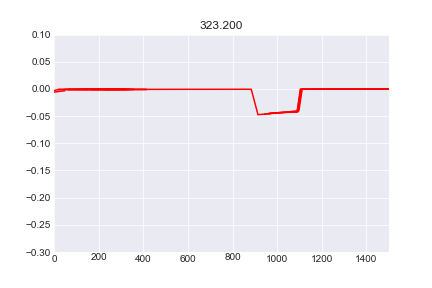
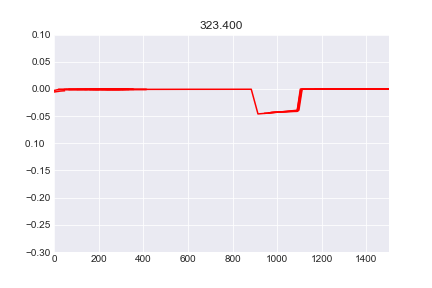
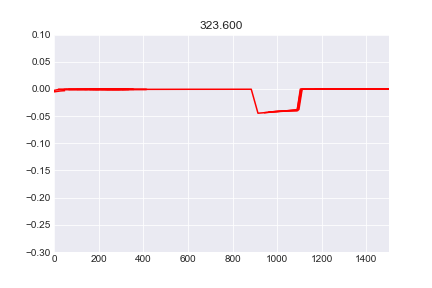
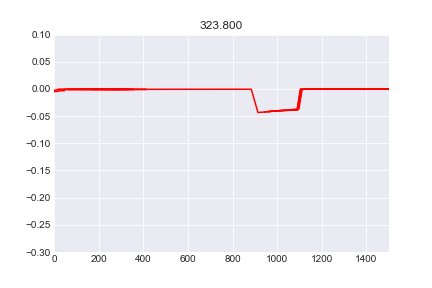
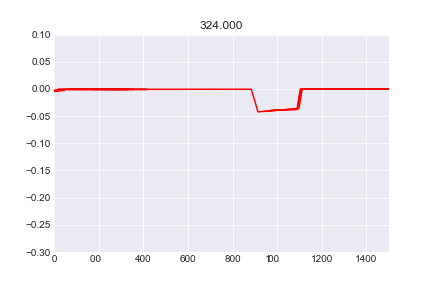
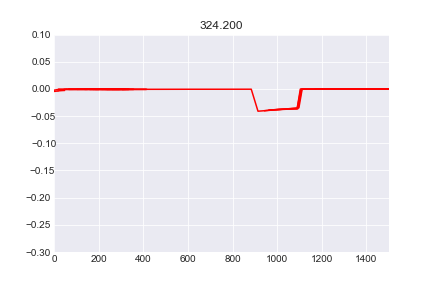
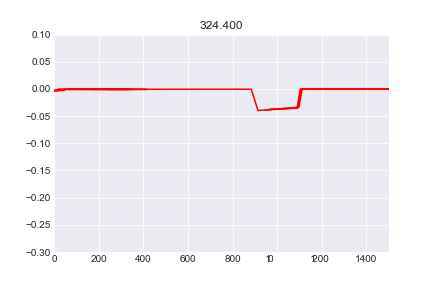
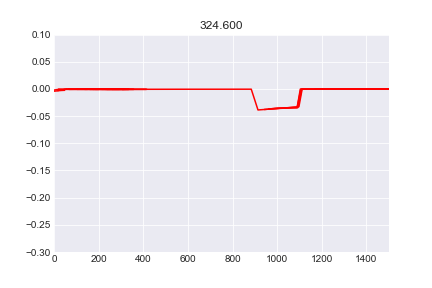
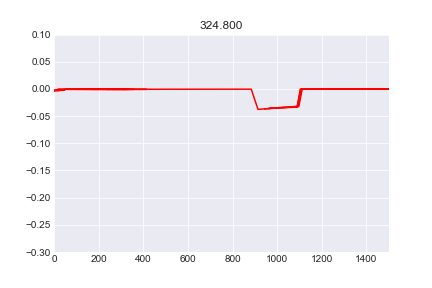
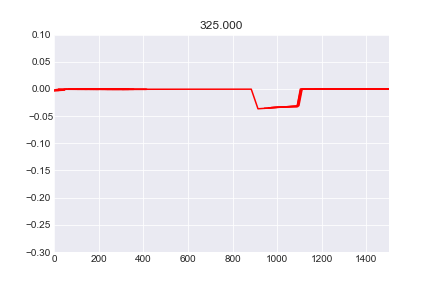
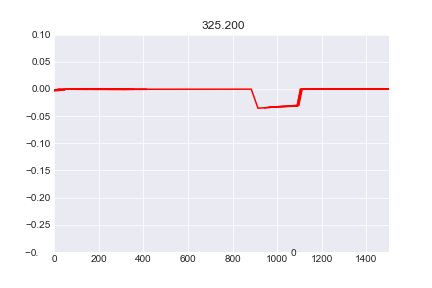
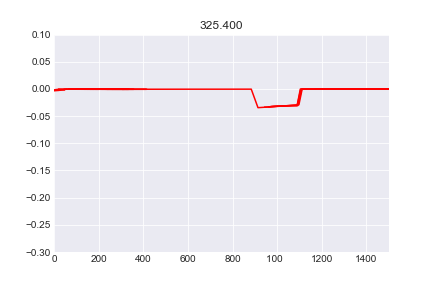
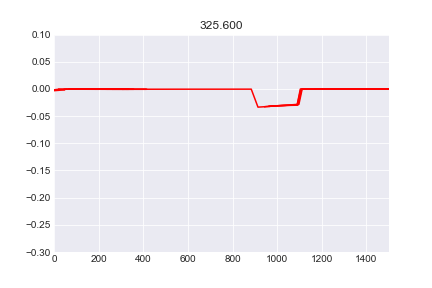
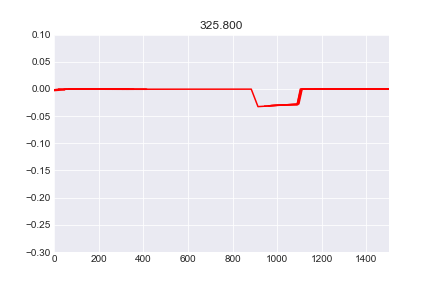
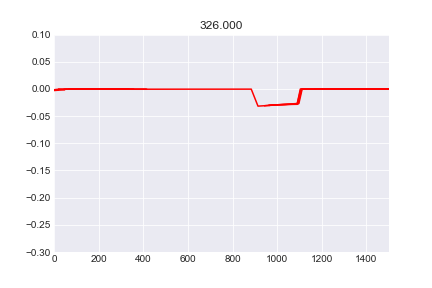
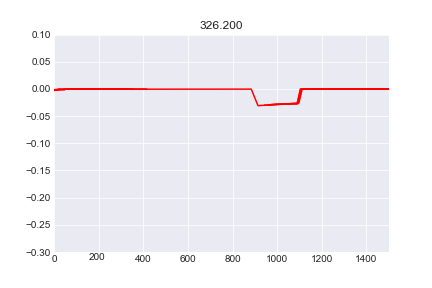
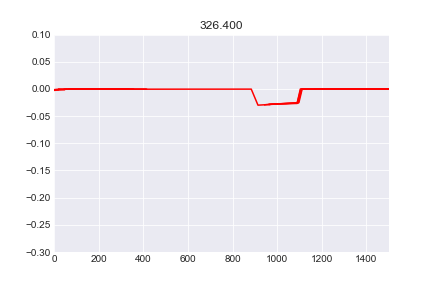
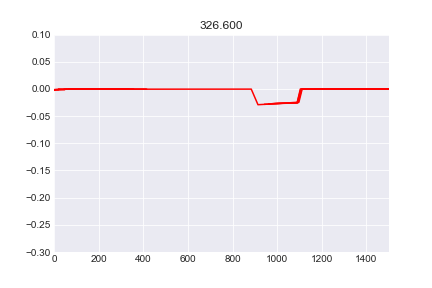
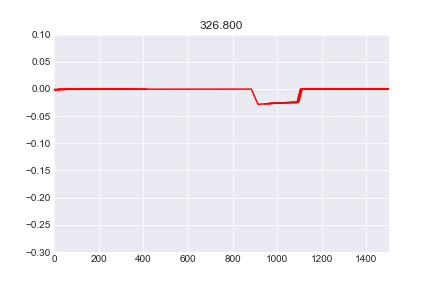
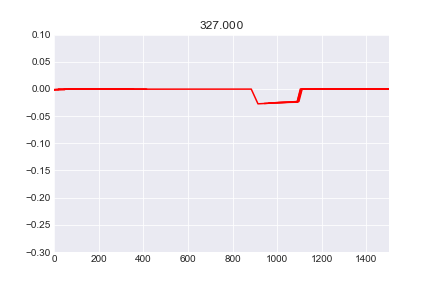
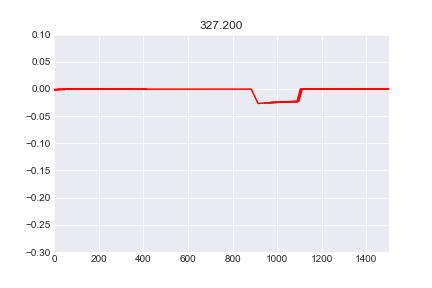
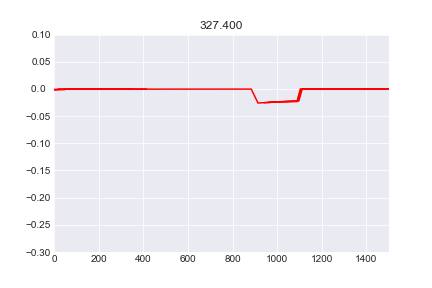
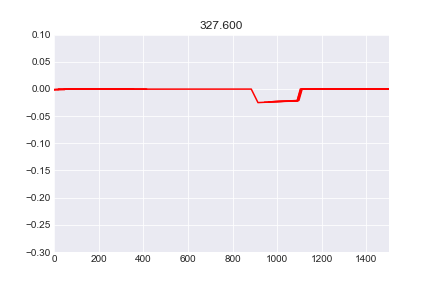
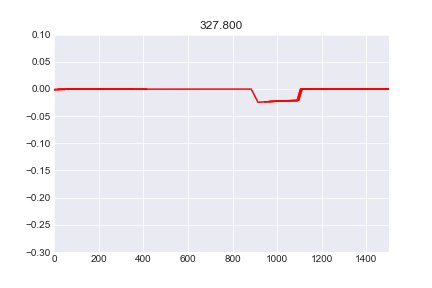
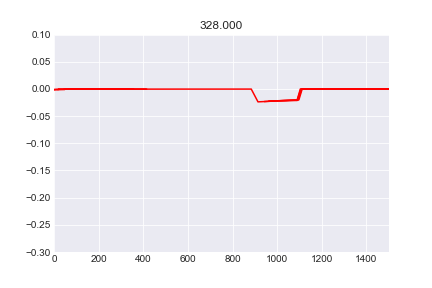
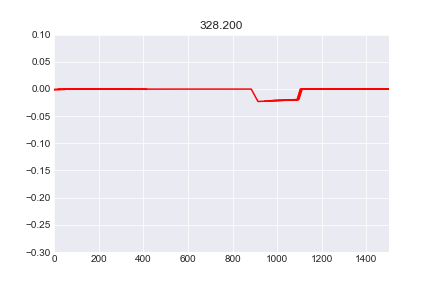
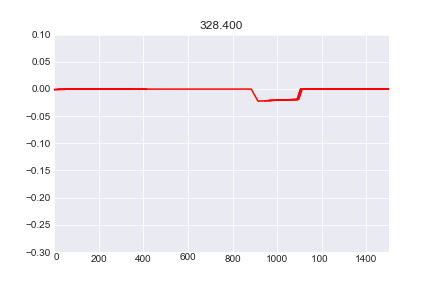
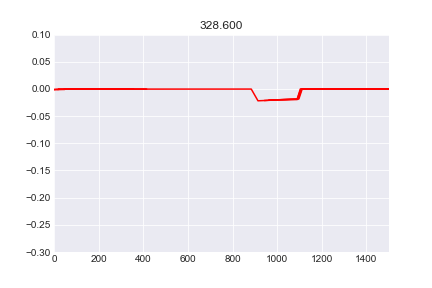
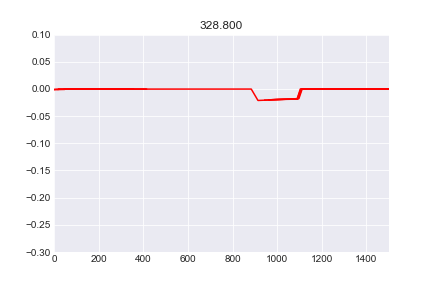
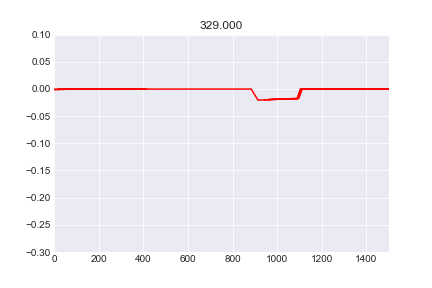
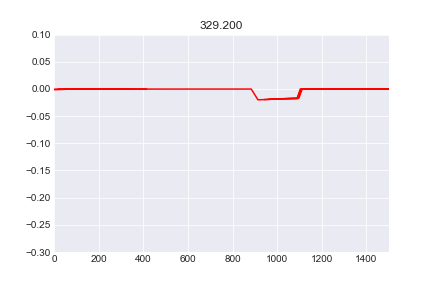
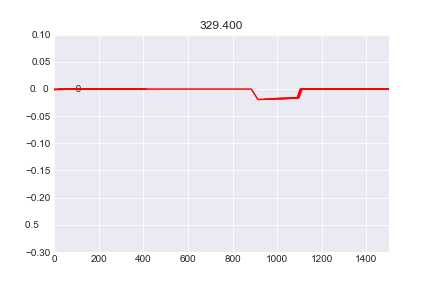
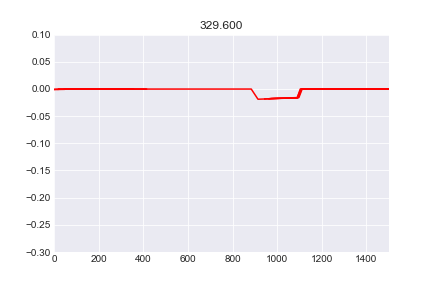
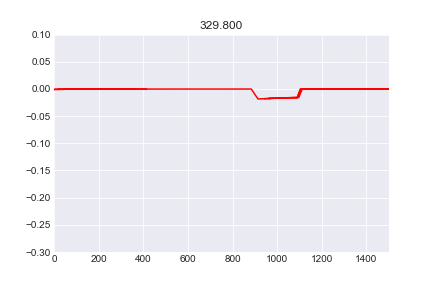
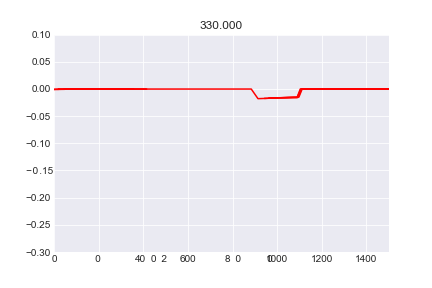
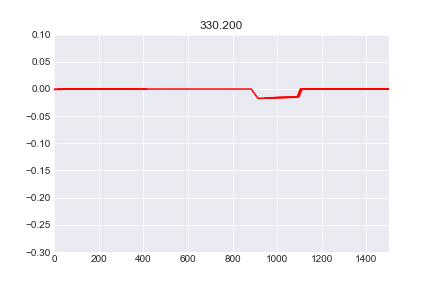
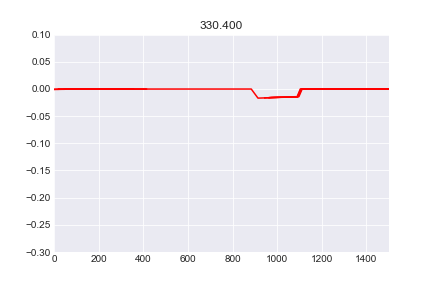
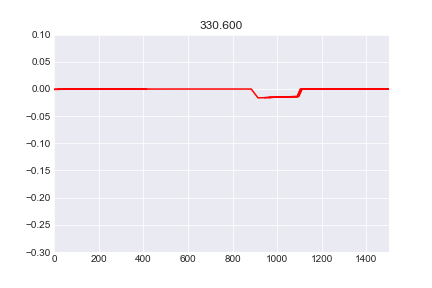
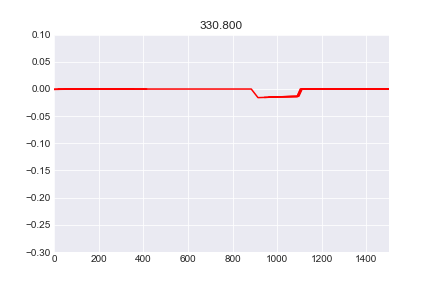
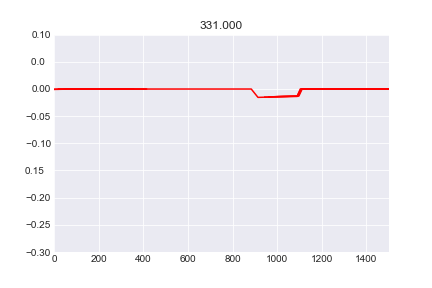
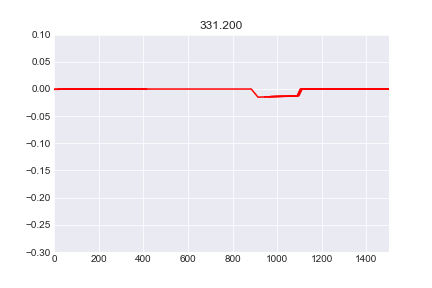
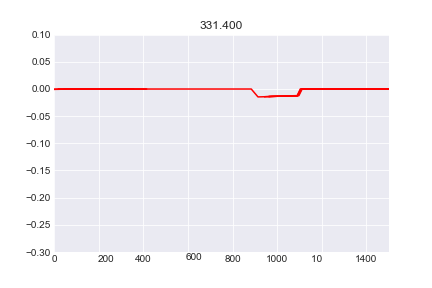
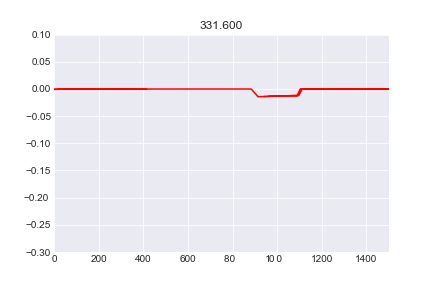
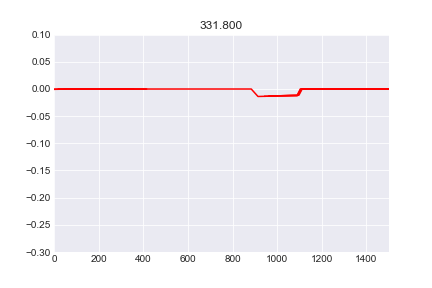
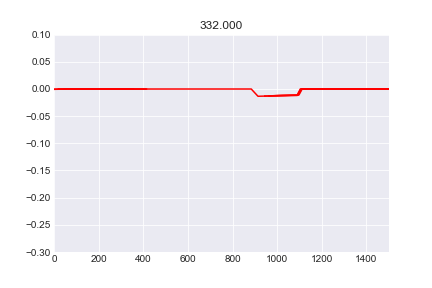
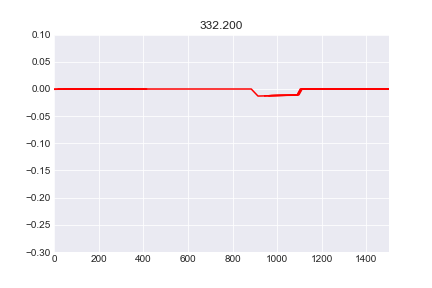
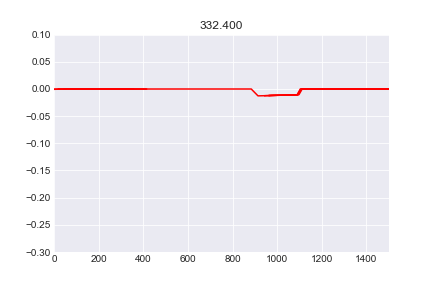
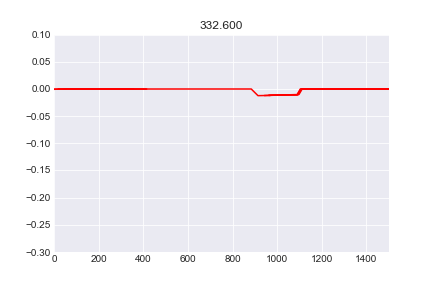
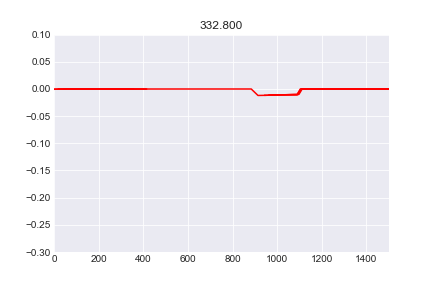
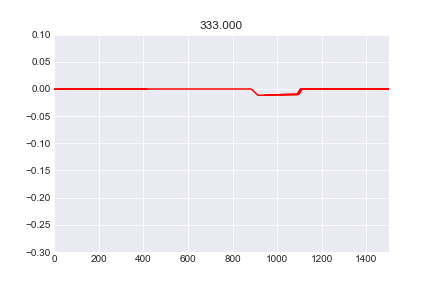
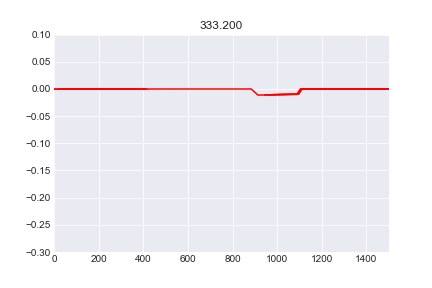
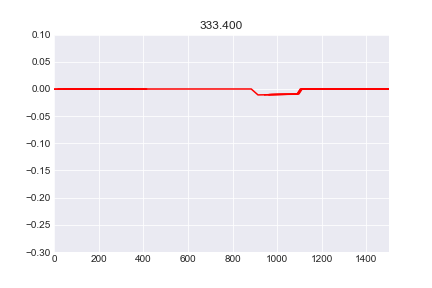
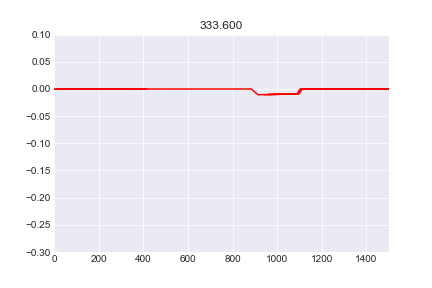
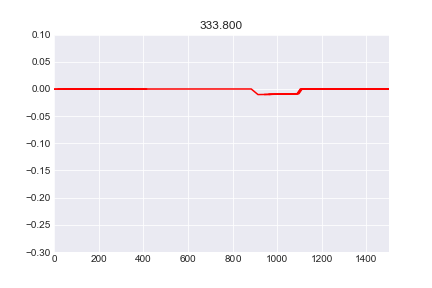
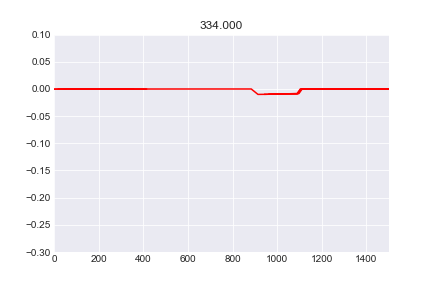
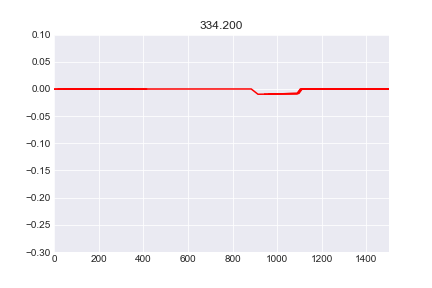
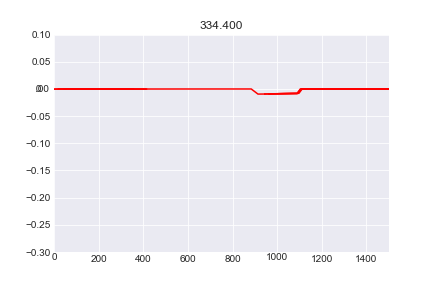
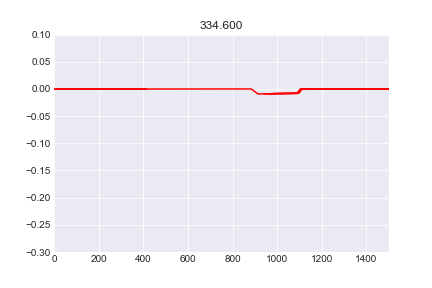
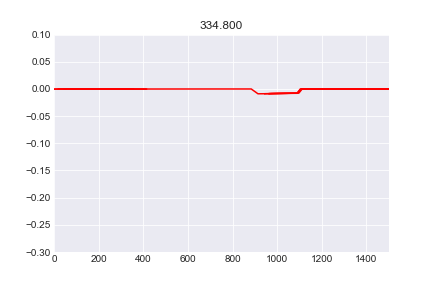
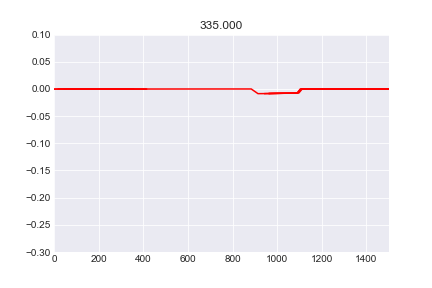
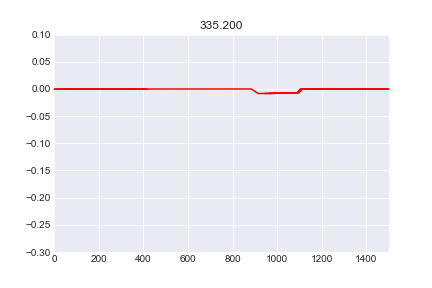
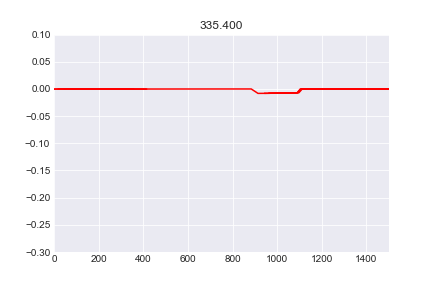
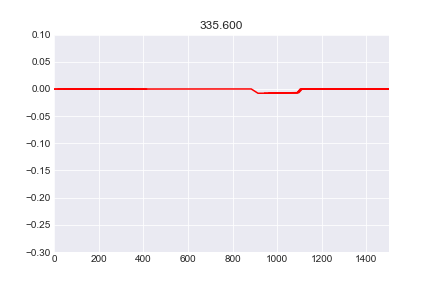
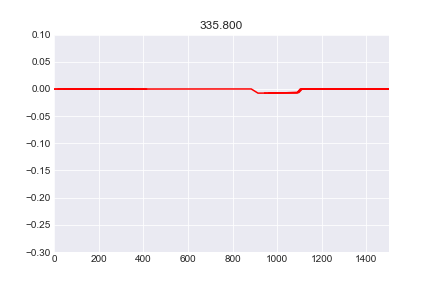
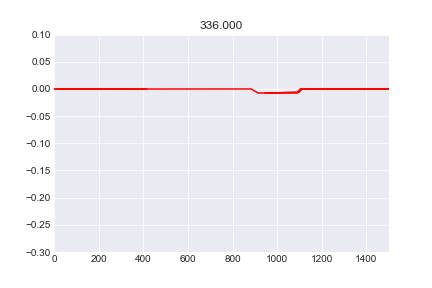
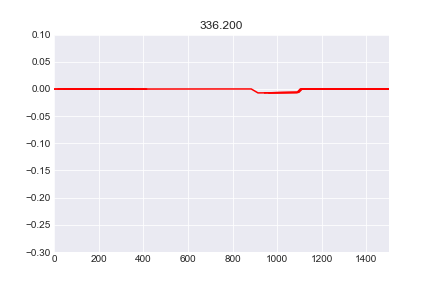
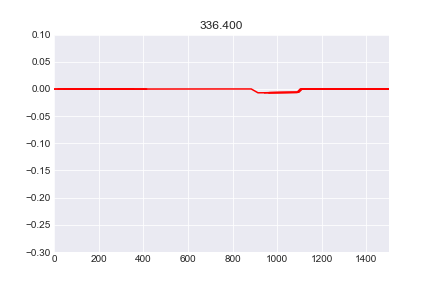
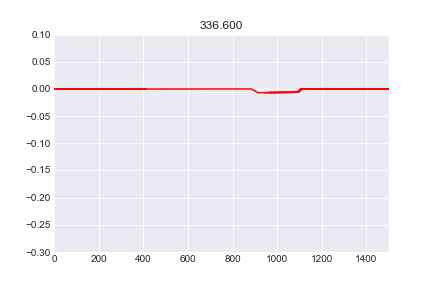
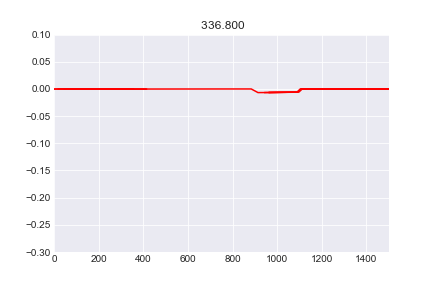
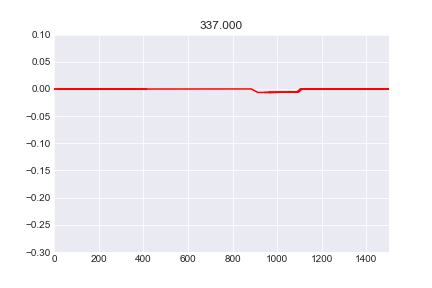
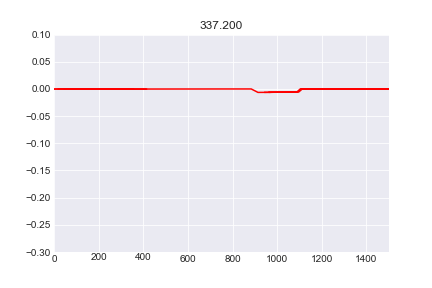
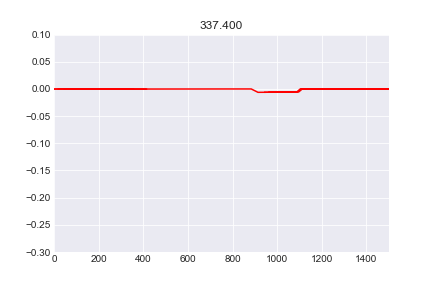
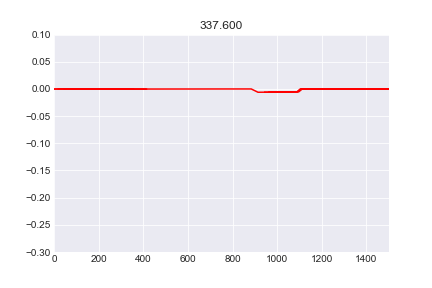
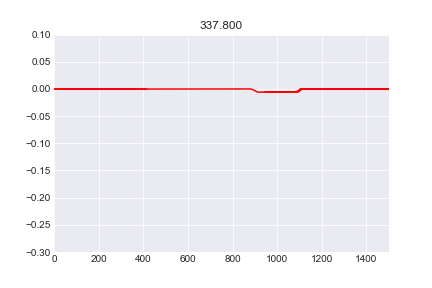
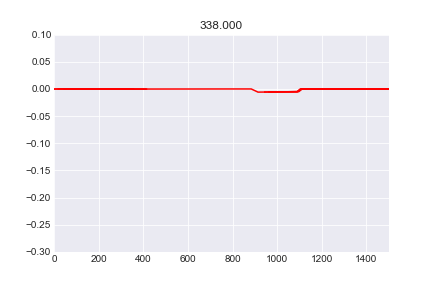
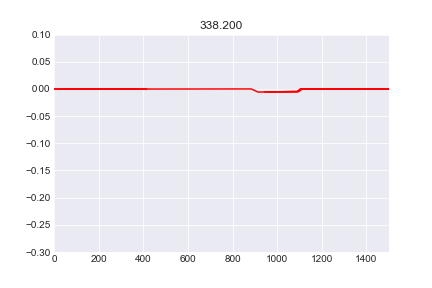
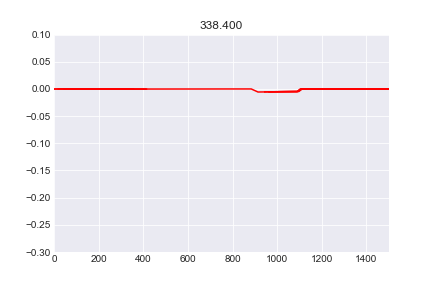
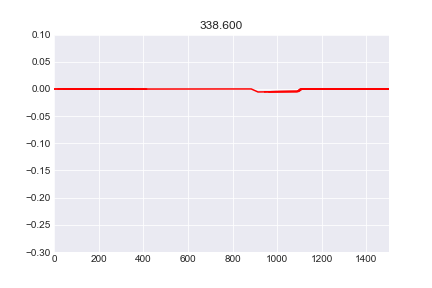
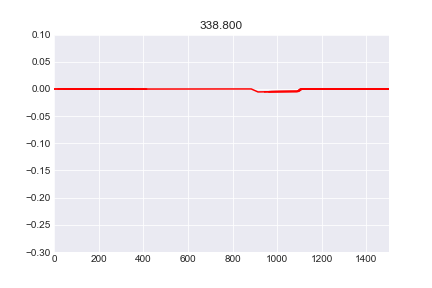
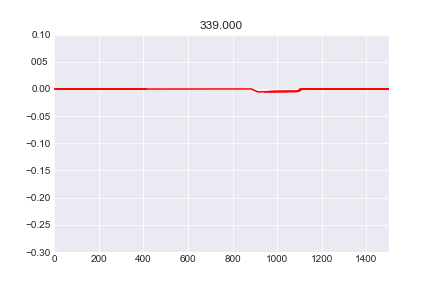
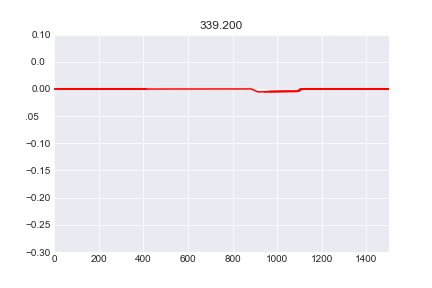
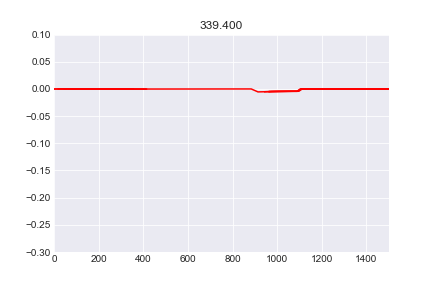
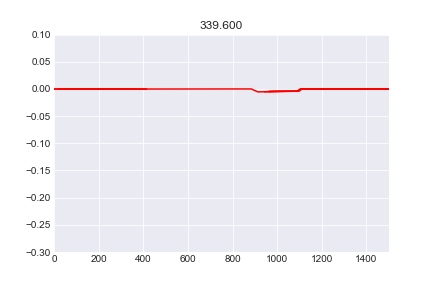
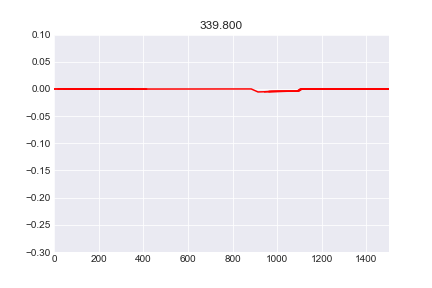
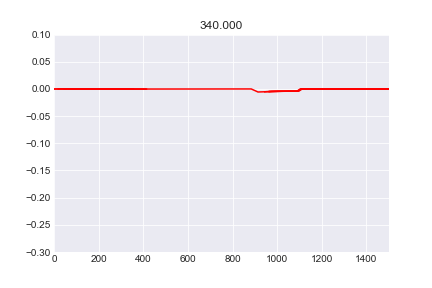
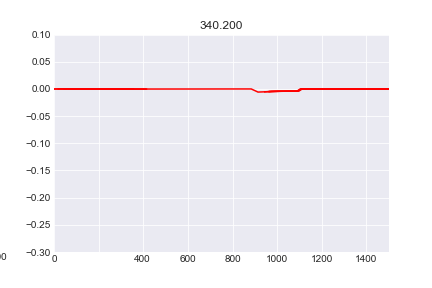
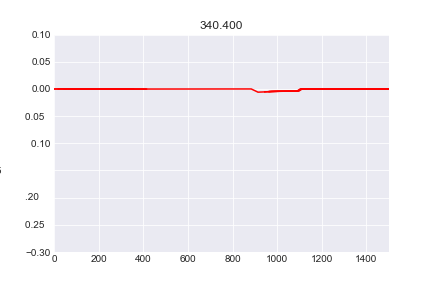
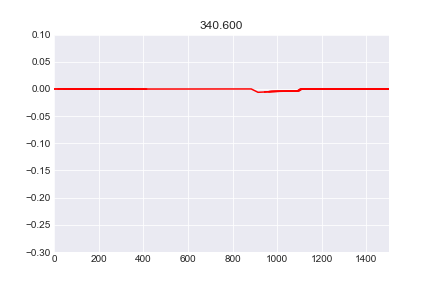
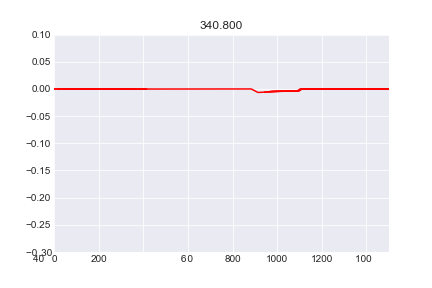
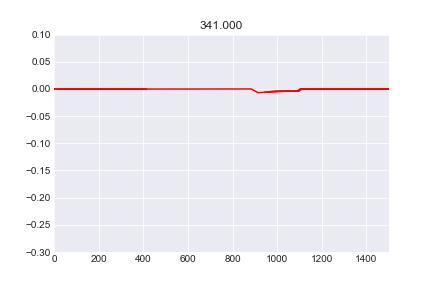
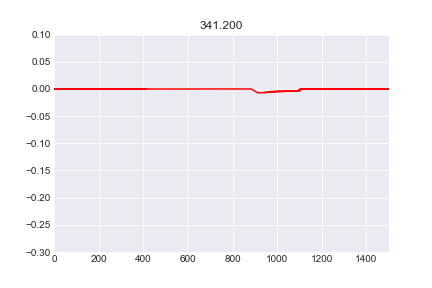
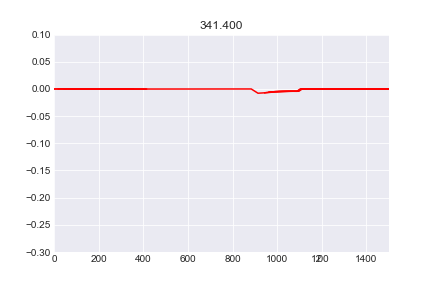
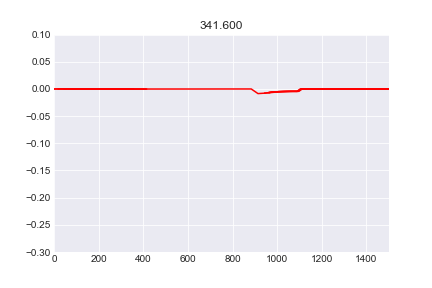
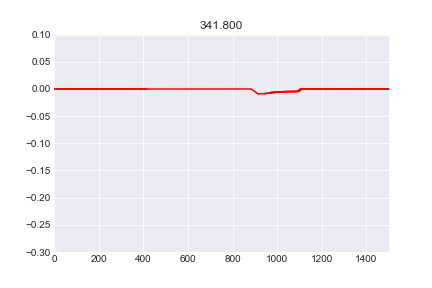
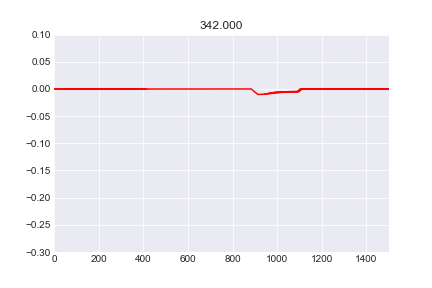
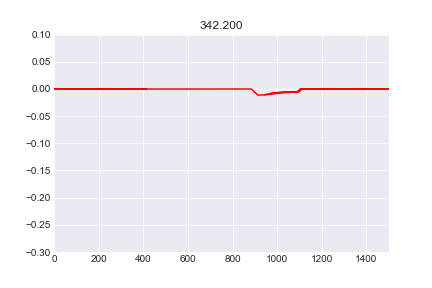
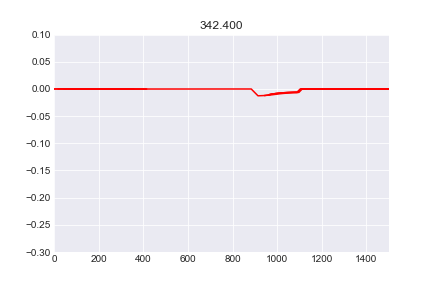
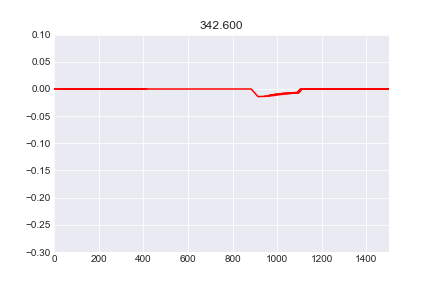
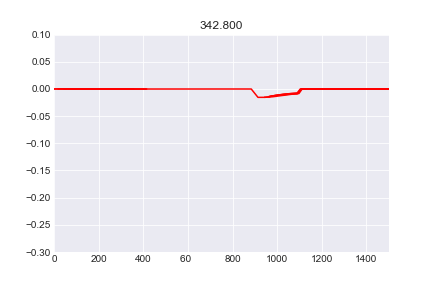
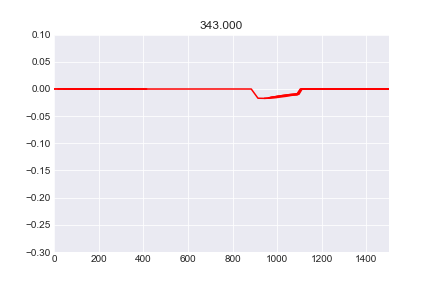
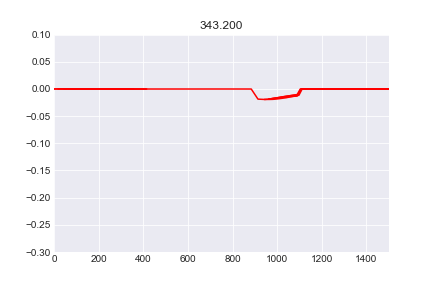
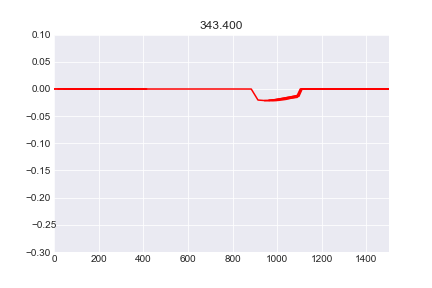
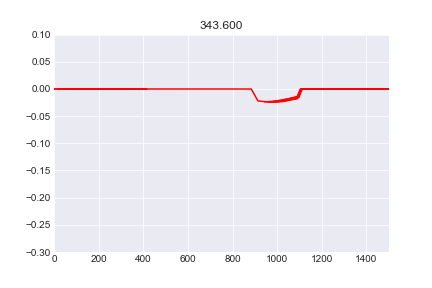
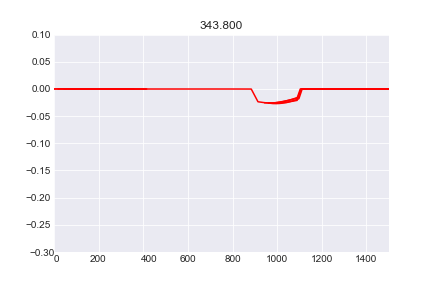
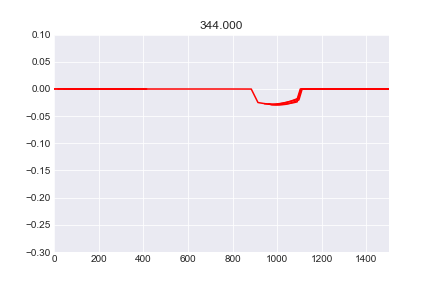
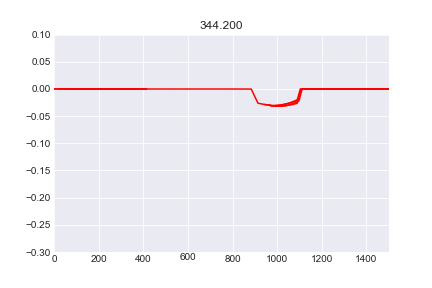
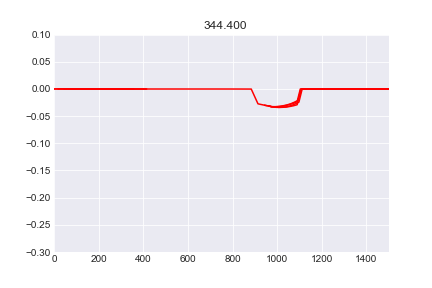
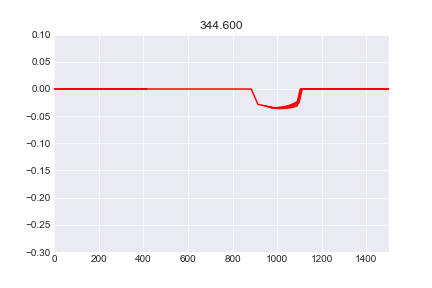
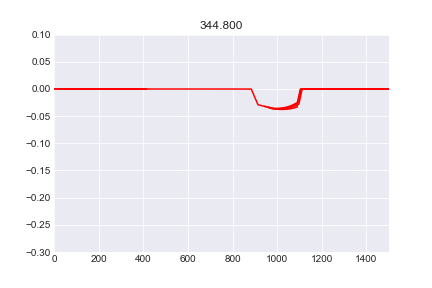
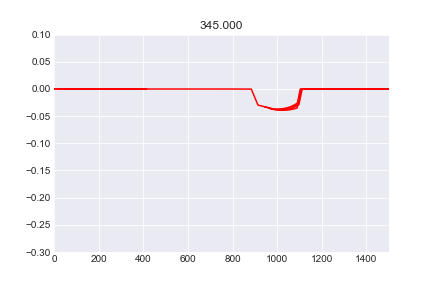
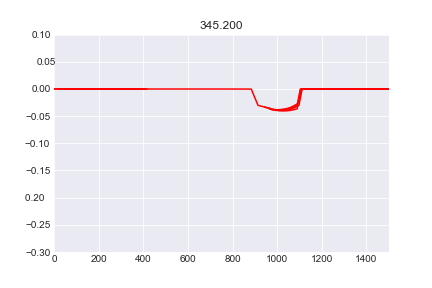
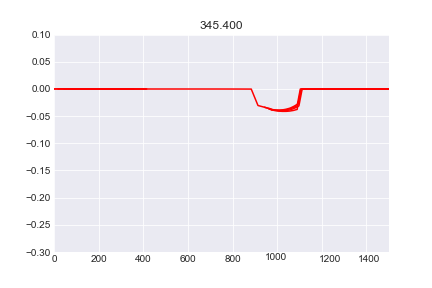
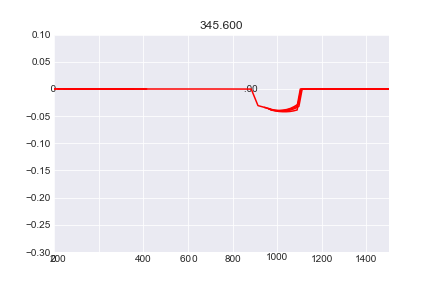
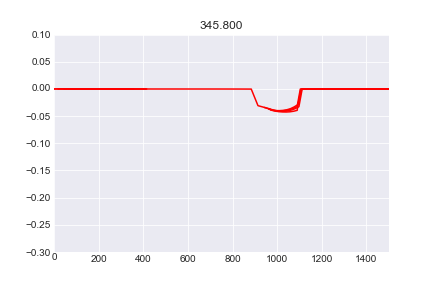
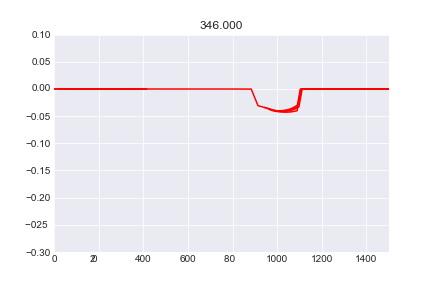
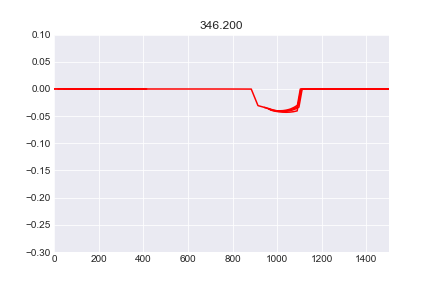
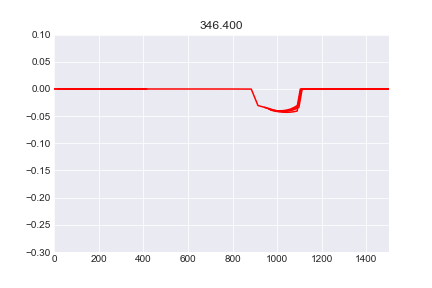
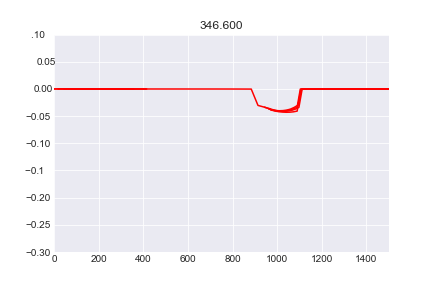
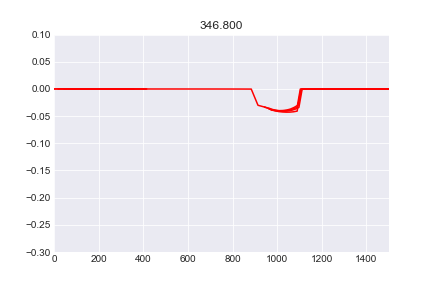
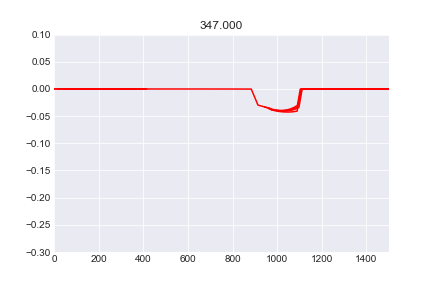
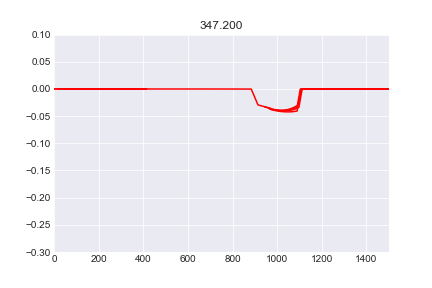
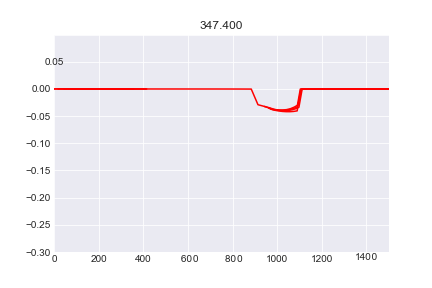
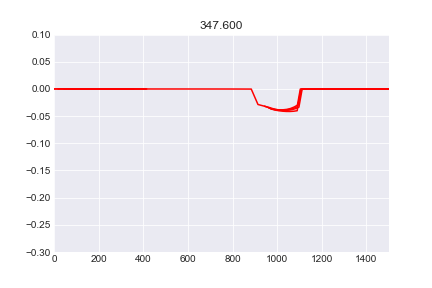
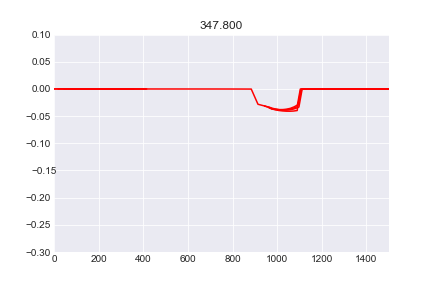
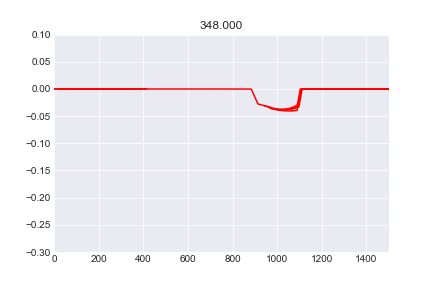
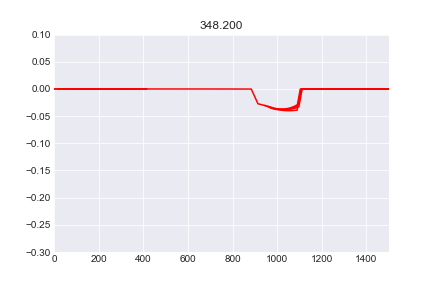
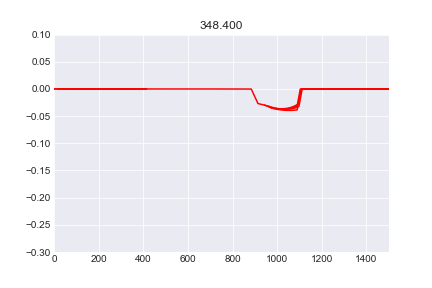
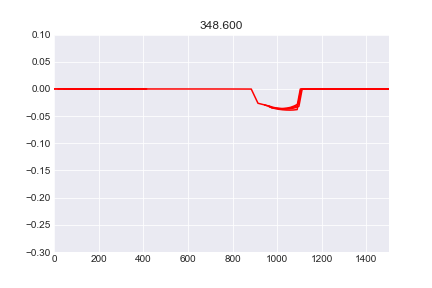
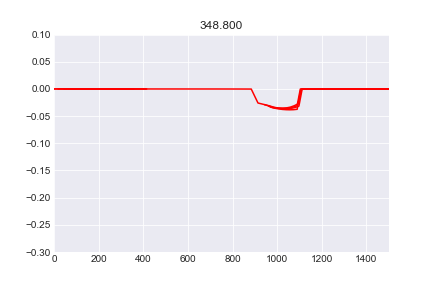
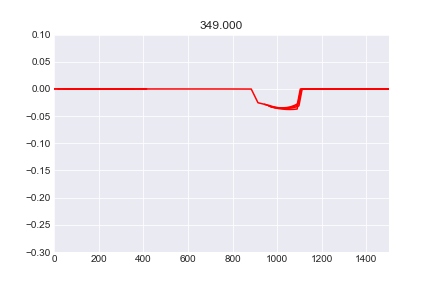
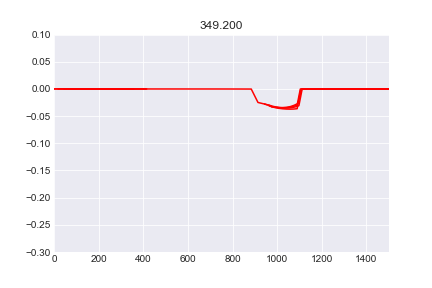
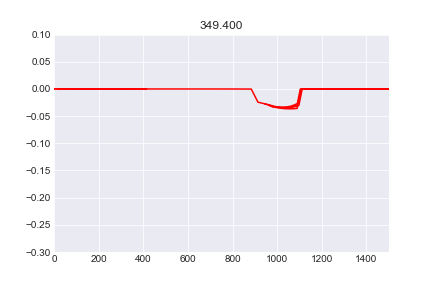
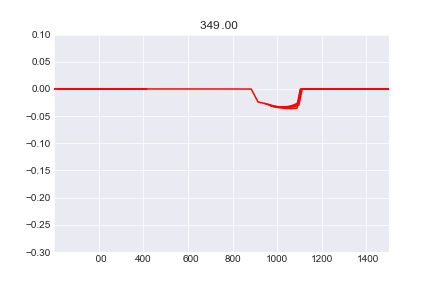
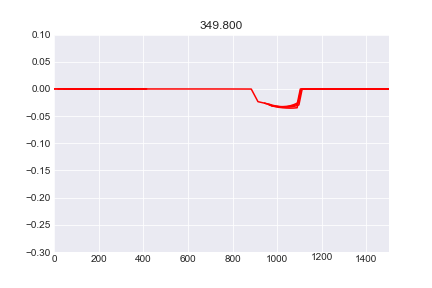

In [35]:
if not 'burst_trail_ca_current_video' in mdb.keys():
    cell.record_range_var('Ca_LVAst.ica') # have a look at the mechanisms folder to find available range vars
    I.scp.init_neuron_run(cell_param.sim, vardt=False)
    I.cell_to_animation(cell, \
                        xlim = [0,1500], \
                        ylim = [-0.3, 0.1], \
                        tstart = 295, \
                        tend = 350, \
                        tstep = 0.2, \
                        outdir = mdb.create_managed_folder('burst_trail_ca_current_video'),\
                        range_vars = 'Ca_LVAst.ica')    
I.display_animation(mdb['burst_trail_ca_current_video'].join('*', '*png'), embedded = True)

See section [display_animations](#display_animations) for caveats of creating animations


# Simulations with well-constrained synaptic input

Here, we place a cell in barrel cortex and compute an anatomical realization, which specifies, where synapses are located. Afterwards, we activate the synapses based on experimental measurements. Next, we import the simulation result in a ModelDataBase to analyze it. Whenever necessary, dask and distributed is used to parallelize the computation.

## Step 1: Register cell morphology
From external resources (e.g. the NeuroMorph pipeline), you need a hoc-file with the dendrite morphology you want to place in the barrel cortex model. The coordinates in the hoc morphology file needs to be choosen according to the coordinate system of the barrel cortex model, i.e. the cell should sit at the desired location. 

There is a morphology file in the getting_started/anatomical_constraints subfolder, which is registered such that the cell is in the center of the C2 column. For the following steps, this morphology is used:

In [25]:
I.os.listdir(I.os.path.join(getting_started_dir, 'anatomical_constraints'))

['86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc']

For building the anatomical model, we use '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc', for the simulation of the evoked activity, we need to use the morphology file with scaled apical trunk. Why the scaling is necessary is described [above](#WhyWeNeedScaling).

In [73]:
path_to_hoc = I.os.path.join(getting_started_dir, 'anatomical_constraints', \
                    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
path_to_scaled_hoc = I.os.path.join(getting_started_dir, 'anatomical_constraints', \
                    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc')

We copy both files to our ModelDataBase. 

In [36]:
mdb = I.ModelDataBase('/home/abast/my_mdb/')

if not 'anatomical_constraints' in mdb.keys():
    mdb.create_managed_folder('anatomical_constraints')
    I.shutil.copy(path_to_hoc, mdb['anatomical_constraints'])
    I.shutil.copy(path_to_scaled_hoc, mdb['anatomical_constraints'])

**Sidenote:** The copying step is optional, if we just want to run the simulation. To make the database self-containing (i.e. after copying it to another machine to an arbitrary path, all paths in all parameter files are stil valid and simulations can be rerun immediately), it is required that all files are in a ModelDataBase: In this case, we could use the following path to refer to the hoc file:
`mdb://2017-10-19_3728_uOGyyhY/anatomical_constraints/some_file.hoc`*

In [74]:
mdb.get_id()

'2017-10-19_3728_uOGyyhY'

mdb paths are described in more detail in section [todo]()

## Step 2: Generate anatomical model

We use the singlecell_input_mapper to create an anatomical model of how that cell is integrated in barrel cortex. The following code calculates the position of synapses onto the example cell. Under the hood, 50 anatomical realizations will be computed. Out of these, the one that is closest to the average is choosen, which then can be refered to as "representative realization". The result is saved in the same folder as the hoc morphology. This takes about 4 hrs to compute, but you can continue with a precomputed result.

In [ ]:
celltype = 'L5tt'
path = mdb['anatomical_constraints'].join('86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
with I.silence_stdout: # this creates > 1 GB of diagnostic information
    I.map_singlecell_inputs(path, celltype) # this takes some time

To use the precomputed result, just copy it from the getting started folder to the ModelDataBase:

In [62]:
from distutils.dir_util import copy_tree
path_to_anatomical_model = I.os.path.join(getting_started_dir, 'anatomical_constraints', \
                    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/')
silent = copy_tree(path_to_anatomical_model, mdb['anatomical_constraints'])

In [75]:
# adapt the path, if you have generated a new anatomical model
path_to_anatomical_model = mdb['anatomical_constraints'].join('86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389')

**What does the result of the map_singlecell_inputs script look like?**

In the directory generated by the singlecell_input_mapper, there are the following files:

In [71]:
I.os.listdir(path_to_anatomical_model)

['basal_synapses',
 'total_synapses',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.con',
 'presynaptic_somata',
 'NumberOfConnectedCells.csv',
 'presynaptic_somata.sh',
 'soma_synapses',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn',
 'apical_synapses',
 'presynaptic_somata.sh~',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_summary_20150504-1611_10389.csv']

- The most important files are the *.con file and the *.syn. These files are the relevant output of the SingleCellMapper for simulations of evoked activity.

- The  *_summary_*.csv file contains summary statistics about the connectivity between all presynaptic populations and our neuron.

The con file maps between presynaptic cells and synapses:

In [68]:
con_file_path = I.glob.glob(path_to_anatomical_model.join('*.con'))[0]

In [69]:
with open(con_file_path) as f:
    print f.read()[:300]

# Anatomical connectivity realization file; only valid with synapse realization:
# 86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn
# Type - cell ID - synapse ID

L6cc_A3	0	0
L6cc_A3	1	1
L6cc_A3	2	2
L6cc_A3	3	3
L6cc_A3	4	4
L6cc_A3	4	5
L6cc_A3	5	6


The .syn file specifies the exact position of each synapse on the hoc morphology:

In [70]:
syn_file_path = I.glob.glob(path_to_anatomical_model.join('*.syn'))[0]
with open(syn_file_path) as f:
    print f.read()[:300]

# Synapse distribution file
# corresponding to cell: 86_L5_86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center
# Type - section - section.x

VPM_E1	112	0.138046479525
VPM_E1	130	0.305058053119
VPM_E1	130	0.190509288017
VPM_E1	9	0.368760777084
VPM_E1	110	0.0
VPM_E1	11	0.120662910562


Here, section referes to the ID od the section in the cell object. x specifies, where along that section the synapse is placed. If x is 0, this is the beginning of the section, if x is one, this is the end of the section.

The subfolders in the directory contain Amira landmark files:
 - for the location of presynaptic_somata by celltype in the folder `presynaptic_somata`
 - for the location of synapses in the folders `total_synapses`, `soma_synapses`, `basal_synapses`, `apical_synapses`

**How to parallelize the generation of anatomical models?**

We can use a distributed Cluster:

In [160]:
I.cluster()

<Client: scheduler='tcp://127.0.0.1:43048' processes=4 cores=4>

In [ ]:
# make the single cell mapper a delayed function
delayed_map_singlecell_inputs = I.dask.delayed(I.map_singlecell_inputs)
# call it with the morphologies
delayeds = [delayed_map_singlecell_inputs(p, 'L5tt') for p in morphology_paths]
# bundle everything in one delayed object
delayeds = dask.delayed(delayeds) # just do it ...
# compute the result, in this case, all cores on the local machine are used.
futures = I.cluster().compute(delayeds)
# visualize the progress
I.distributed.progress(futures)

**Sidenotes**

I.cluster() returns a distributed.Client object, which can be used to execute a dask graph using all cores on the local machine. I.cluster() also "prepares" the cluster such that it fits the needs of doing single cell simulations: 
- [Work stealing](http://distributed.readthedocs.io/en/latest/work-stealing.html) is disabled, because otherwise, tasks might run more than once. This should change in the near future, [see this github issue](https://github.com/dask/distributed/issues/847). As soon as work-stealing is transactional, just comment out the respective lines in Interface.cluster, which disable work stealing.
- It imports matplotlib on all workers and sets the backend to 'agg'. This can be neccessary on compute servers that do nt provide the necessary graphical libraries, which would crash otherwise. After this, you can create figures on the computeservers.
- If I.cluster() is called more than once, it does not generate a new distributed.Client() object every time. Instead, it creates it when it is first called and returns the same client on all consecutive calls.
- You can set up a "real" cluster spanning hundrets of compute servers as described [here](http://distributed.readthedocs.io/en/latest/setup.html). In this case, you would connect to the cluster in the following way:

In [ ]:
I.cluster('server_name_on_which_scheduler_is_running:8786')

## Activate synapses
Now we need to activate the synapses according to experimental data, such that the synapse activation represents a passive touch experiment.

To do this, we need the following information
 1. A parameter file specifying charakteristics of the synaspses by celltype
 2. A parameterfile specifying the ongoing activity by celltype
 3. Parameterfiles specifying evoked response by stimulus, celltype and celllocation

### Synapse characteristics and ongoing activity
Synapse characteristics and ongoing activity are defined here:

In [87]:
ongoing_template_param_name = I.os.path.join(getting_started_dir, 'functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param')

In this parameter file, the following keys are defined

In [90]:
ongoing_template_param = I.scp.build_parameters(ongoing_template_param_name)
ongoing_template_param.keys()

['info', 'network', 'NMODL_mechanisms']

The most relevant information is specified in the network key:

In [92]:
print ongoing_template_param.network.keys()

['L6ct', 'L6cc', 'L56Trans', 'L5st', 'VPM', 'SymLocal6', 'SymLocal5', 'SymLocal4', 'SymLocal3', 'L4sp', 'L4ss', 'L23Trans', 'L2', 'L1', 'L5tt', 'L45Sym', 'SymLocal2', 'L34', 'SymLocal1', 'L45Peak', 'L6ccinv', 'L4py']


Here, parameters are defined for each presynaptic celltype:

In [93]:
ongoing_template_param.network.L5tt

{'celltype': 'spiketrain',
 'interval': 283.3,
 'synapses': {'receptors': {'glutamate_syn': {'delay': 0.0,
    'parameter': {'decayampa': 1.0,
     'decaynmda': 1.0,
     'facilampa': 0.0,
     'facilnmda': 0.0,
     'tau1': 26.0,
     'tau2': 2.0,
     'tau3': 2.0,
     'tau4': 0.1},
    'threshold': 0.0,
    'weight': [1.59, 1.59]}},
  'releaseProb': 0.6}}

 - interval: mean ongoing interspike interval
 - releaseProb: chance that synapse gets activated if presynaptic cell gets activated
 - synapses --> receptors --> glutamate_syn --> parameter: 
    - parameters for the NEURON mechanism defined here: mechanisms/channels/netglutamate.mod
      - tau1: NMDA decay time
      - tau2: NMDA rise time
      - tau3: AMPA decay time
      - tau4: AMPA rise time
 - synapses --> receptors --> weight
      - maximum conductance of the synapse for AMPA and NMDA, respectively

### PSTHs of evoked activity for passive touch by celltype and celllocation

Parameterfiles can be found here:

In [110]:
evokedPrefix = I.os.path.join(getting_started_dir, 'functional_constraints/evoked_activity/PW_SuW_RF_CDK/')
excitatory_PSTHs = [fname for fname in I.os.listdir(evokedPrefix) if fname.endswith('PSTH_UpState.param')]
inhibitory_PSTHs = [fname for fname in I.os.listdir(evokedPrefix) if fname.endswith('active_timing_normalized_PW_1.0_SuW_0.5.param')]
excitatory_PSTHs

['L2_3x3_PSTH_UpState.param',
 'L4py_3x3_PSTH_UpState.param',
 'L4sp_3x3_PSTH_UpState.param',
 'L5st_3x3_PSTH_UpState.param',
 'L34_3x3_PSTH_UpState.param',
 'L6ct_3x3_PSTH_UpState.param',
 'L6cc_3x3_PSTH_UpState.param',
 'L6ccinv_3x3_PSTH_UpState.param',
 'L4ss_3x3_PSTH_UpState.param',
 'L5tt_3x3_PSTH_UpState.param']

Let's have a look at a specific parameterfile:

In [113]:
example_PSTH = I.scp.build_parameters(I.os.path.join(evokedPrefix, excitatory_PSTHs[-1]))
example_PSTH.keys()

['L5tt_D3',
 'L5tt_D2',
 'L5tt_D1',
 'L5tt_C2',
 'L5tt_C3',
 'L5tt_C1',
 'L5tt_B1',
 'L5tt_B3',
 'L5tt_B2']

We have entries for each homecolumn, each containing the respective evoked PSTH in a C2 stimulus scenario:

In [118]:
example_PSTH.L5tt_C2.keys()

['probabilities', 'distribution', 'intervals']

In [120]:
for k,v in example_PSTH.L5tt_C2.iteritems():
    print '{}: {}\n'.format(k,v)

probabilities: [0.0009, 0.0009, 0.0035, 0.0111, 0.034, 0.0263, 0.0162, 0.006, 0.0035, 0.0111, 0.0035, 0.0009, 0.0009, 0.0009, 0.0086, 0.0035, 0.0009, 0.006, 0.0035, 0.0035, 0.0009, 0.0086, 0.0009, 0.0009, 0.0009, 0.0009, 0.006, 0.006, 0.0035, 0.0035, 0.0009, 0.006, 0.0035, 0.0009, 0.0035, 0.0009]

distribution: PSTH

intervals: [(5.0, 6.0), (9.0, 10.0), (11.0, 12.0), (12.0, 13.0), (13.0, 14.0), (14.0, 15.0), (15.0, 16.0), (16.0, 17.0), (18.0, 19.0), (19.0, 20.0), (20.0, 21.0), (21.0, 22.0), (22.0, 23.0), (23.0, 24.0), (24.0, 25.0), (25.0, 26.0), (26.0, 27.0), (27.0, 28.0), (28.0, 29.0), (29.0, 30.0), (31.0, 32.0), (32.0, 33.0), (33.0, 34.0), (34.0, 35.0), (35.0, 36.0), (37.0, 38.0), (38.0, 39.0), (40.0, 41.0), (41.0, 42.0), (43.0, 44.0), (44.0, 45.0), (45.0, 46.0), (46.0, 47.0), (47.0, 48.0), (48.0, 49.0), (49.0, 50.0)]



### Creating a parameterfile that fully defines a specific stimulus

Next, we combine all data, to one parameterfile, which then contains all information to describe the activatio of presynaptic cells and synapses during a passive whisker touch scenario, given our cellmorphology and the anatomical network realization. To so, we use the `create_evoked_network_parameter` function:

In [131]:
# the whisker stimulus we want to simulate. 
whisker = 'C2' # Cell is in C2 --> this is a principal whisker stimulus scenario
# defined above
ongoing_template_param_name 
syn_file_path
con_file_path
# cell number spreadsheet generated in anatomical realization step.
cell_number_file_name = path_to_anatomical_model.join('NumberOfConnectedCells.csv')
# output_path
if not 'network_param' in mdb.keys(): mdb.create_managed_folder('network_param')
out_file_name = mdb['network_param'].join('C2_stim.param')
I.create_evoked_network_parameter(ongoing_template_param_name, cell_number_file_name, \
                                  syn_file_path, con_file_path, whisker, out_file_name)

*************
creating network parameter file from template /nas1/Data_arco/project_src/in_silico_framework/getting_started/functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param
*************


Let's also generate parameterfiles for the surround whiskers!

In [140]:
with I.silence_stdout:
    for whisker in ['B1', 'B2', 'B3', 'C1', 'C3', 'D1', 'D2', 'D3']:
        I.create_evoked_network_parameter(ongoing_template_param_name, cell_number_file_name, \
                                          syn_file_path, con_file_path, whisker,\
                                          mdb['network_param'].join('{}_stim.param'.format(whisker)))

##### what does the result look like?

In [132]:
network_param = I.scp.build_parameters(mdb['network_param'].join('C2_stim.param'))

In [133]:
network_param.keys()

['info', 'network', 'NMODL_mechanisms']

In [136]:
print network_param.network.keys()[:10]

['L45Peak_D1', 'L45Peak_D2', 'L5tt_B3', 'L45Peak_Delta', 'L2_C1', 'L6ct_E3', 'L2_C3', 'L2_C2', 'L2_C4', 'L6cc_Gamma']


We just printed a subset of the keys here. Lets have a look at what the parameterfile specifies about L5tt cells in C2

In [138]:
for k, v in network_param.network.L5tt_C2.iteritems():
    print '{}: {}\n'.format(k,v)

synapses: {'releaseProb': 0.6, 'distributionFile': '/home/abast/my_mdb/anatomical_constraints_F9EisD_/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn', 'receptors': {'glutamate_syn': {'threshold': 0.0, 'delay': 0.0, 'parameter': {'decayampa': 1.0, 'facilnmda': 0.0, 'tau2': 2.0, 'tau3': 2.0, 'tau1': 26.0, 'tau4': 0.1, 'decaynmda': 1.0, 'facilampa': 0.0}, 'weight': [1.59, 1.59]}}, 'connectionFile': '/home/abast/my_mdb/anatomical_constraints_F9EisD_/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.con'}

cellNr: 379

celltype: {'pointcell': {'probabilities': [0.0009, 0.0009, 0.0035, 0.0111, 0.034, 0.0263, 0.0162, 0.006, 0.0035, 0.0111, 0.0035, 0.0009, 0.0009, 0.0009, 0.0086, 0.0035, 0.0009, 

As you see, all information is integrated

 - network --> [population] --> celltype --> pointcell --> offset: timepoint at which the evoked activity starts 

## Determine channel densities such that the cell exhibits certain properties measured in slice data

Currently, the parameters are determined using a MOO approach. The result is writen manually in the cell parameter file, which we have already seen above.

In [145]:
# We copy it to the model data base
if not 'biophysical_constraints' in mdb.keys():
    cell_parameter_file = I.os.path.join(getting_started.parent, 'biophysical_constraints', \
                                     '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')
    I.shutil.copy(cell_parameter_file, mdb.create_managed_folder('biophysical_constraints'))
cell_parameter_file = mdb['biophysical_constraints'].join('86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')

### run the simulation

we simulate one single trail for each whisker stimulus and save the result in the database under the simrun key:

In [165]:
delayeds = []
if 'simrun' in mdb.keys(): 
    del mdb['simrun']
mdb.create_managed_folder('simrun')
for whisker in ['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3']:
    network_file = mdb['network_param'].join('{}_stim.param'.format(whisker))
    cell_parameter_file # defined above
    dir_prefix = mdb['simrun'].join('stim_{}'.format(whisker))
    nSweeps = 1 # number of consecutive simulations per process
    nprocs = 1 # number of processes simulating that task in parallel    
    tStop = 300 # stop the simulation at 300ms
    d = I.simrun_run_new_simulations(cell_parameter_file, network_file, dirPrefix = dir_prefix, \
                                     nSweeps = nSweeps, nprocs = nprocs, tStop = tStop, silent = False)
    delayeds.append(d)

I.simrun_run_new_simulations returns dask.delayed objects, i.e. they result describes *how* the computation can be run, but it is not computed yet. We send it to our local cluster:

In [ ]:
delayeds[0].compute(get = I.cluster().get)

The result is a dask delayed object, in which a **plan** how to compute the result is stored. To compute it, call `compute`. The get keyword allows to specify a scheduler, here the multiprocessing scheduler is used. To run it on a cluster, an instance of `distributed.Client` could be used.

In [ ]:
import dask
d.compute(get = dask.multiprocessing.get) # run the simulation using the multiprocessing scheduler

In [ ]:
I.mdb_init_simrun_general.init(mdb, os.path.join(getting_started_files, 'results'))

The mdb object can be used like a dictionary. The database contains dask dataframes giving access to the simulation data.

In [89]:
mdb.keys()

['Vm_distal',
 'Vm_proximal',
 'burst_times',
 'cell_activation',
 'dendritic_voltage_traces_keys',
 'file_list',
 'metadata',
 'parameterfiles',
 'parameterfiles_cell_folder',
 'parameterfiles_network_folder',
 'sim_trail_index',
 'simresult_path',
 'spike_times',
 'synapse_activation',
 'voltage_traces']

In [88]:
mdb['synapse_activation'].head()

[########################################] | 100% Completed |  0.1s


synapse_type  synapse_ID  soma_distance  \
sim_trail_index                                                              
20170327-0745_seed122328974/000000        L1_C1           6    1417.471240   
20170327-0745_seed122328974/000000        L1_C1          18    1508.620514   
20170327-0745_seed122328974/000000        L1_C1          21    1494.761607   
20170327-0745_seed122328974/000000        L1_C1          25    1389.264410   
20170327-0745_seed122328974/000000        L1_C2           9    1423.024481   

                                    section_ID  section_pt_ID  dendrite_label  \
sim_trail_index                                                                 
20170327-0745_seed122328974/000000          47              9  ApicalDendrite   
20170327-0745_seed122328974/000000          50             63  ApicalDendrite   
20170327-0745_seed122328974/000000          49             48  ApicalDendrite   
20170327-0745_seed122328974/000000          50              7  ApicalDendrite   
20170327-0745_seed122328974/000000          74              5  ApicalDendrite   

                                             0   1   2   3   4   5   6   7  
sim_trail_index                                                             
20170327-0745_seed122328974/000000  208.348580 NaN NaN NaN NaN NaN NaN NaN  
20170327-0745_seed122328974/000000  240.685555 NaN NaN NaN NaN NaN NaN NaN  
20170327-0745_seed122328974/000000  174.886361 NaN NaN NaN NaN NaN NaN NaN  
20170327-0745_seed122328974/000000  228.604036 NaN NaN NaN NaN NaN NaN NaN  
20170327-0745_seed122328974/000000   74.905120 NaN NaN NaN NaN NaN NaN NaN

##### plot the PSTH

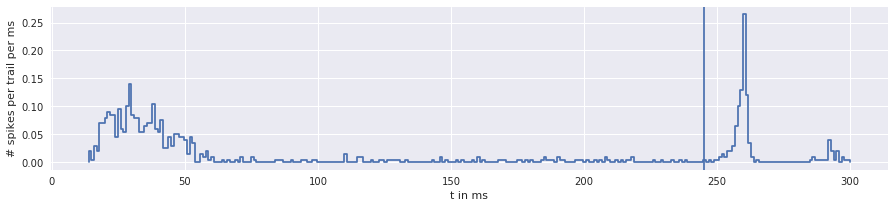

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,3))
bins = I.temporal_binning(mdb['spike_times'])
I.histogram(bins, fig = fig)
fig.axes[-1].set_xlabel('t in ms')
fig.axes[-1].set_ylabel('# spikes per trail per ms')
fig.add_subplot(111).axvline(245)
fig

Usually, we discard the first 100ms of simulation since the cell needs that time to reach a "steady state". At 245ms, a C2 whisker stimulus occurs, followed by a strong evoked response at ~260 ms.

##### plot single voltage traces, mean and std

In [8]:
import dask
import matplotlib.pyplot as plt
mean = mdb['voltage_traces'].mean(axis = 0).compute(get = dask.multiprocessing.get)
std = mdb['voltage_traces'].std(axis = 0).compute(get = dask.multiprocessing.get)

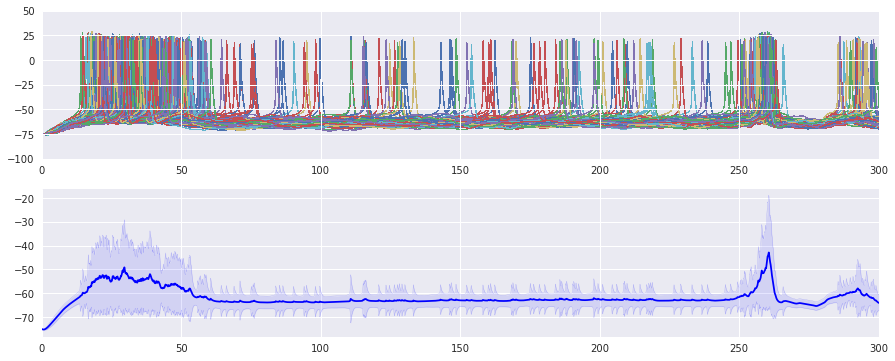

In [31]:
fig = plt.figure(figsize = (15,6))
I.manylines(mdb['voltage_traces'], fig = fig.add_subplot(211), axis = [0, 300, -100, 50])
I.average_std(mean, std, fig = fig.add_subplot(212))
fig.axes[-1].set_xlim(0,300)
fig

##### How many trails have a spike in the interval 245ms to 265 ms?

In [28]:
# here is what the spike times dataframe looks like
st = mdb['spike_times']
st.head()

0       1        2       3        4  \
sim_trail_index                                                                
20170327-0745_seed122328974/000000  17.950  31.825  253.650  260.75      NaN   
20170327-0745_seed122328974/000001  26.175  33.525   41.975   51.90      NaN   
20170327-0745_seed122328974/000002  28.950  40.925  120.700  257.30      NaN   
20170327-0745_seed122328974/000003  18.050  25.000   33.050   44.35  190.250   
20170327-0745_seed122328974/000004  29.550  39.350   94.800  124.50  259.325   

                                     5  
sim_trail_index                         
20170327-0745_seed122328974/000000 NaN  
20170327-0745_seed122328974/000001 NaN  
20170327-0745_seed122328974/000002 NaN  
20170327-0745_seed122328974/000003 NaN  
20170327-0745_seed122328974/000004 NaN

In [ ]:
# pandas provides a powerful syntax to calculate the number of trails (i.e. rows) to calculate the number
# of trails exhibiting a spike in the interval 245ms to 265ms.
st.apply(lambda x: ((x >= 245) & (x < 265)).any(), axis = 1).value_counts()

# ModelDataBase
<a id='ModelDataBase'></a>

This section documents the API of the ModelDataBase class

To create a ModelDataBase, call the ModelDataBase oject with the path, where it is supposed to save it's files.

In [26]:
mdb = I.ModelDataBase('/home/abast/my_mdb/')

### store data

We can use the mdb object like a dictionary. However, all data will be instantly saved to / loaded from disk:

In [38]:
mdb['something'] = 'some text i want to save'
mdb['something']

'some text i want to save'

By default, the ModelDataBase uses cloudpickle to store data on disk. While this allows to store arbitrary python objects, it is not well suited for large datasets. For these cases, you can choose different methods to store the data:

 - **I.dumper_to_pickle**: this uses cPickle to serialize aribtrary python objects. While this is faster than cloudpickle, it only works for a much more limited set of python objects compared to cloudpickle.
 - **I.dumper_pandas_to_pickle**: saves a pandas dataframe using pandas [to_pickle](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_pickle.html) method.
 - **I.dumper_pandas_to_msgpack**: saves a pandas dataframe using pandas [to_msgpack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_msgpack.html) method with blosc compression. This usually provides the best performance.
 - **I.dumper_dask_to_csv **: saves a dask dataframe to csv. Each partition is stored as csv file using the pands [to_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html) method. If the dataframe has more than 10000 partitions, it is repartitioned to 5000 partitions (i.e. the data is saved with not more than 10000 chunks). Metadata (dtypes, column names, ...) is stored seperately.
 - **I.dumper_dask_to_msgpack**: saves dask dataframe to msgpack. Each partition is stored as csv file using the pandas [to_msgpack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_msgpack.html) method with blosc compression. If the dataframe has more than 10000 partitions, it is repartitioned to 5000 partitions (i.e. the data is saved with not more than 10000 chunks).
 - **I.dumper_dask_to_categorized_msgpack**: This method is similar to I.dumper_dask_to_msgpack, however, before storing the data, it is preprocessed: All columns of dtype 'object' (i.e. the all columns containing strings including the index) are categorized, which means, repeated occurences of the same string value are replaced by integer values. This allows to compress dataframes containing lots of repeated string values much better.
 - **I.dumper_numpy_to_npy**: This method can be used to store numpy arrays.
 - **I.dumper_cell**: this saves a single_cell_parser.Cell object by first replacing all neuron.Vector instances with numpy.array and afterwards using pickle to save it to disk. 
 - **'self'**: save objects directly to the backend sqlite database. Don't use it for large objects, since writing to the database blocks it for other processes.



To specify a dumper, the syntax mdb['someting'] = ... is not powerfull enough. Use mdb.setitem instead:

In [29]:
# this is the same as mdb['something'] = 'some text i want to save'
mdb.setitem('something', 'some text i want to save', dumper = I.dumper_to_cloudpickle) 

### delete items
To delete items, you can use

In [15]:
del mdb['something']

If you overwrite an existing key, the folder where the old data has been saved is removed automatically.

### metadata and integration with git version management

The model data base also stores metadata for each item about the time and exact `in_silico_framework` version used at creation time. You can access metadata of *something* in the following way:

In [39]:
mdb.metadata['something']

defaultdict(<function model_data_base.model_data_base.<lambda>>,
            {'dirty': True,
             'dumper': 'to_cloudpickle',
             'error': None,
             'full-revisionid': '8d54a85af82bf3a1893a6cc70140052ae9735edf',
             'metadata_creation_time': 'together_with_new_key',
             'time': (2017, 11, 11, 18, 15, 57, 5, 315, -1),
             'version': 'v0.0.1+94.g8d54a85.dirty'})

The most relevant parts here are:
    - dumper: the method how the data was saved in the database
    - time: Timepoint (UTC) when the data was added
    - version: version of the in_silico_framework repository at the timepoint the data was added
    - dirty: whether there where uncommited changes at the timepoint the data was added

You can access the code that was used at the time the data was saved in the model data base. Use the short hash, which starts in 'version' directly after the 'g' and type into your browser:
https://github.com/abast/in_silico_framework/tree/8d54a85

Alternatively, use the full revision id:
https://github.com/abast/in_silico_framework/tree/[full_revisionid]

### How ModelDataBase works internally

If we put data in the database, a subdirectory is created. The foldername is the key (reduced to characters supported by the file system) plus some random suffix.

In [41]:
print I.os.listdir(mdb.basedir)

['dbcore.pickle', 'sqlitedict.db.lock', 'sqlitedict.db', 'metadata.db.lock', 'metadata.db', 'burst_trail_video_He6P9E_', 'burst_trail_ca_current_video_r9fSGP_', 'something_F6bt2F_']


Then, the dumper is called with the data and the path to that subfolder. It saves the data in the subfolder together with a Loader.pickle file. The Loader.pickle file contains an object, which is defined in the same module as the dumper. The Loader-object contains all information necessary to load in the data. It provides a get-method. Then, the key is saved in the sqlite database, together with the name of the subfolder. Metadata is saved accordingly.

To load the data, the foldername is requested from the sqlite database. Afterwards, the Loader.pickle file is loaded and the get-method is called with the absolute path to the respective subfolder. If the database is moved from one location to another, the absolute path is automatically adapted, i.e. the ModelDataBase object takes care of it, while the get method may rely on absolute paths.

Reading and writing to sqlite is handled by the class _sql_backend. Since the locking mechanism of sqlite is not safe on nfs mounts, an additional file based locking mechanism has been implemented (therefore, we need the fasteners module). Currently, we only allow sequential reading and writing. If the model data base is used on a large cluster, this does not have a substantial impact on the overall performance, as long as the access time to the database per process is small. Since all dumpers listed above (except 'self') only write a small amount of data to sqlite (i.e. the key and the subfolder), this does not impact performance: Reading and writing the actual data can happen concurrently.

Using  dumper = 'self' is discouraged. Reasons:  All dumpers except 'self' only save the path to the subfolder in sqlite (short access time), while the dumper 'self' stores the whole python object there (can require to open a sql connection for a long time, blocking access for other processes).

Currently, sqlite is not used directly, instead the module tuplecloudsqlitedict is used. Opposite to sqlite, this is thread-safe. Also, it allows to save python objects directly to the sqlite database (this is, what enables dumper = 'self'). 

Todo: Get rid of tuplecloudsqlitedict and the dumper 'self'

### Not documented yet:
    - model_data_base_register
    - get_id()
    - mdb://[unique_id]/path
    - create sub_mdb
    - create managed folder
    - maybe_calculate

### model data base in more detail

We can use the mdb like a dictionary. However, all data will be instantly saved to / loaded from disk:

In [22]:
mdb['something'] = 'some text i want to save'

In [23]:
mdb['something']

'some text i want to save'

The model data base also stores metadata for each item, which is tightly integrated with the git version control:

In [26]:
mdb.metadata['something']

defaultdict(<function model_data_base.model_data_base.<lambda>>,
            {'dirty': True,
             'dumper': 'to_cloudpickle',
             'error': None,
             'full-revisionid': '6b077e6bdc0f559d05de7b969191a622b1be960b',
             'metadata_creation_time': 'together_with_new_key',
             'time': (2017, 10, 21, 13, 7, 28, 5, 294, -1),
             'version': 'v0.0.1+66.g6b077e6.dirty'})

# Creating videos using I.display_animation
<a id='display_animations'></a>
**CAVEAT** if you use display_animation with embedded = False, you should use relative paths. The reason is, that the paths are not resolved by IPython but by the browser. Therefore they should be stored in the same folder as the IPython notebook

**CAVEAT** if you use embedded = True, all the image data will be saved in the ipynb-file / html-file directly using base64 encoding. While it is nice to have everything in one file, this is less memory efficient. Very quickly you end up with very large notebooks. Sometimes, jupyter seems to have difficulties to handle such files. If you use a version control system for the ipynb-files, this will slow down performance.

I usually use embedded = False during development and embedded = True to send the notebook around.

**Troubleshooting** Because of a matplotlib bug, the exact posistion of the tick labels is not constant, instead they are "jumping around". Use I.sns.set_style("darkgrid") to get rid of that.

# Robert fagen
 - Marcel sagt, wir haben spike initiaion im AIS, im Video ist das AIS jedoch stets weniger depolarisiert, als das Soma
     - Robert, hast du nicht mal gesagt, wir haben spike initiation im Soma?
 - Ich habe das *scaled* hoc file genommen, das im Ordner postsynaptic_location/3x3_C2_sampling/C2center zu finden ist. Ist das richtig?
 - Synapsen von L5tt sind facilitierend (richtig?). Wie spiegelt sich das in den Parametern wieder?
 - Zwischen Sections scheint es Zwischenraum zu geben. Was, wenn dort eine synapse liegt?
